# Forest and Fire Data 1: Forest and Fire Data Merging/Interpolation
## Overview of Notebook
This notebook takes the compiled Ontario Forest Data within the Ontario boundary, and outputs a final dataframe that is modified to make better used of the data in the dataframe.

## 1) Import Modules and Packages

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## 2) Get Path and Data
Here we will open both the Ontario Forest Data DataFrame and the Ontario Boundary shapfile. The latter will be used as a visual tool for plotting when needed.

In [2]:
path = r"I:\CME538 Project\CME538 Project\processed data ontario only\250m"

In [3]:
os.listdir(path)

['Approximations',
 'ONage2001_250m',
 'ONage2001_250m.tif',
 'ONage2001_250m.tif.aux.xml',
 'ONage2011_250m',
 'ONage2011_250m.tif',
 'ONage2011_250m.tif.aux.xml',
 'Onage2019_250m',
 'Onage2019_250m.tif',
 'Onage2019_250m.tif.aux.xml',
 'ONharvest1985_2020_250m',
 'ONharvest1985_2020_250m.tif',
 'ONharvest1985_2020_250m.tif.aux.xml',
 'Ontario_fire_in_forest_coordinates.csv.gz',
 'Ontario_Forest_Data.csv.gz',
 'Ontario_Forest_Data_Points.csv.gz',
 'ONvol2001_250m',
 'ONvol2001_250m.tif',
 'ONvol2001_250m.tif.aux.xml',
 'ONvol2011_250m',
 'ONvol2011_250m.tif',
 'ONvol2011_250m.tif.aux.xml',
 'ONvol2015_250m',
 'ONvol2015_250m.tif',
 'ONvol2015_250m.tif.aux.xml',
 'ON_forest_and_fires.csv.gz']

In [ ]:
filenames = os.listdir(path)[12:15]
filenames

In [ ]:
ON_boundary = gpd.read_file(r"I:\CME538 Project\CME538 Project\ontario boundary\Province\Province.shp")

In [ ]:
ON_boundary = ON_boundary.to_crs(4269)

In [ ]:
ON_boundary.plot()

In [ ]:
ON_forest = pd.read_csv(path+"\\"+filenames[2],compression='gzip',index_col=0)
ON_forest.head()

In [ ]:
ON_forest.info()

We can acually drop the lat and lon columns for the poly shape (the last 8 columns) 

In [ ]:
ON_forest.drop(columns=['lon1','lon2','lon3','lon4','lat1','lat2','lat3','lat4'],inplace=True)

In [ ]:
ON_fire = pd.read_csv(path+"\\"+filenames[0],index_col=0)
ON_fire.head()

In [ ]:
ON_fire.info()

## 3) Exploring and Modifying the Fire Data 

The ON_fire dataframe consists of fire data that were spatially joined to our current forest pixel grid. This one done sjoinging the forest data onto the fire data. A buffer polygon was created based on the area of the fire, centered at its cendroid. Then the joinging was done to see how many of our 250mx250m pixels coordinates intersected with the fire area polygon. We can now map the fires based on there areas on our coordinate grid. 

So the important geometry to keep for the ON_fire data is the last geometry column, which is the same grid as our fores data.

In [ ]:
ON_fire.columns

We can get rid of some columns that we may not need like:
- Unamed: 0
- point_geometry
- buffer_geometry
- buffer_radius
- index_right

In [ ]:
ON_fire.drop(columns=['point_geometry', 'buffer_radius', 'buffer_geometry'],inplace=True)

Let rename the lat,lon, LATITUDE and LONGITUDE columns to something better, and uncapitalize all the columns

In [ ]:
ON_fire.rename(columns={"LATITUDE":'original_lat',"LONGITUDE":'original_lon'},inplace=True)
ON_fire.columns = ON_fire.columns.str.lower()
ON_fire.head()

## 4) Merging Forest and Fire DataSets

Now we have two data sets:
1) ON_forest, crs = 4269
2) ON_fire, crs = 3347

We want to merge the fire data to the forest data. But first, we need to do some manipulation on the fire data. The column 'index' has a unique number associated with each fire, so we can check how many fires there are

In [ ]:
print("There are {} unique fires".format(ON_fire['index'].nunique()))
print("But there are {} row in the ON_fire data".format(len(ON_fire)))

This checks out, there were 20866 fire in our original datasets and we have 20595. We have lost a few fires because some may have been errors or on lake or boundary edges. But there are over 500000 rows in our dataset! that is because some fire cover many 250mx250m pixel. We are not worried about duplication here because out grid matched our forest grid.

We are however interested in any data that has duplicate fires that happened in the same year or different years at the same location. Lets filter the dataframe to see how this looks.

In [ ]:
ON_fire[ON_fire.duplicated('pixel_geometry',keep=False)]

Here we can see that we have ducplicate columns, because multiple fires were reported arround this coordinate. For example, the first two rows (index = 96800) had a fire reported late july and early augus. 

Another case (index= 98679) show a fire in 2011 and 2016. 

For simplicity, if there are two fires reported in the same year, we will assume that only one occured. 

If there are multiple fires reported for different years, we need to figure out a way to deal with this.

Let filter out all the unnessecarry information at this stage. We are only interested about the date of the fire and the locaiton (geometry)

In [ ]:
#ON_fire.rename(columns={'pixel_geometry':'geometry'},inplace=True)
ON_fire = ON_fire[['year','month','day','area_intersect_perc']]
ON_fire.head()

Now lets create a funciton that will return an array of dates for each coordinates that can have multiple fires reported

In [ ]:
unique_index_duplicate = ON_fire.index.unique()
year = []
month = []
day = []
area_perc = []

def get_duplicate_fire_dates(data):
    """
    """
    year,month,day,area= [],[],[],[]
    if isinstance(data,pd.Series) == True:
        year.append(int(data[0]))
        month.append(int(data[1]))
        day.append((data[2]))
        area.append((data[3]))
    
    else:
        for i in range(len(data)):
            year.append((data.iloc[i,0]))
            month.append((data.iloc[i,1]))
            day.append((data.iloc[i,2]))
            area.append((data.iloc[i,3]))
        
    return year,month,day,area

for ind in unique_index_duplicate:
    
    year_temp,month_temp,day_temp,area_temp= get_duplicate_fire_dates(ON_fire.loc[ind][:])
    
    year.append(year_temp)
    month.append(month_temp)
    day.append(day_temp)
    area_perc.append(area_temp)

Check that our returned arrays are same length as the number of unique rows in ON_fire

In [ ]:
print("length of year: {} month: {} day: {} and area: {} match the number of unique rows in ON_fire: {}".format(len(year),len(month),len(day),len(area_perc),len(ON_fire.index.unique())))

Now lets filter the ON_fire data to the just the unique rows and replace the year month and day columns with our arrays

In [ ]:
ON_fire=ON_fire[~ON_fire.index.duplicated()]
ON_fire.year = year
ON_fire.month = month
ON_fire.day = day
ON_fire.area_intersect_perc = area_perc
ON_fire

No we can join the ON_fire to the ON_forest data frame on the index, which is a unique code for each pixel. Lets create a new dataframe called ON_forest_and_fires

In [ ]:
ON_forest_and_fires = ON_forest.join(ON_fire,lsuffix=" ")

In [ ]:
ON_forest_and_fires.head()

lets take a look and see how non nan rows look

In [ ]:
ON_forest_and_fires[~ON_forest_and_fires.year.isna()]

We can also take a look at the rows which have multiple fires lets add a column called number_fires

In [ ]:
ON_forest_and_fires['number_fires'] = ON_forest_and_fires[~ON_forest_and_fires.year.isna()].year.apply(lambda row: len(row))

Lets also see what the max number of fires is and lets see what having more then 10 fires on a pixel looks like

In [ ]:
ON_forest_and_fires.number_fires.unique()

In [ ]:
ON_forest_and_fires[ON_forest_and_fires.number_fires > 10]

In [ ]:
ON_forest_and_fires.head()

In [ ]:
ON_forest_and_fires[(~ON_forest_and_fires.year.isna()) & (ON_forest_and_fires.number_fires > 1)].head()

Everything looks good. Lets go ahead and save it to our drive as a safekeep.

In [ ]:
ON_forest_and_fires.to_csv(path+"\\"+"ON_forest_and_fires.csv.gz",compression='gzip',header=ON_forest_and_fires.columns)

## 5) Exploring the Data
Lets take a look at some of the columns. We have two main categories, aside from the harvest years columns; (1) the age of forests and (2) the volume density of forests in Ontario. For each catergory, we have three points in time. 

Lets take a look at how this data looks. To make visualization easier, lets only look that the rows without nan value.

### 5 alternate) Only do cell 179 to 181 if you need to re-import the data

In [4]:
ON_forest_and_fires = pd.read_csv(path+"\\"+"ON_forest_and_fires.csv.gz",compression='gzip',index_col=0)
ON_forest_and_fires.head()

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_15640\841440765.py:1: DtypeWarning: Columns (11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  ON_forest_and_fires = pd.read_csv(path+"\\"+"ON_forest_and_fires.csv.gz",compression='gzip',index_col=0)


age_2001  age_2011  age_2019  year_harvested  vol_2001  vol_2011  vol_2015  \
0     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
1     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
2     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
3     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
4      57.0       NaN       NaN             NaN     38.69       NaN       NaN   

         lon        lat                                           geometry  \
0 -84.890501  46.906052  POLYGON ((-84.88863710751139 46.90697579711416...   
1 -84.885743  46.912303  POLYGON ((-84.88387922029249 46.91322718112671...   
2 -84.887410  46.919261  POLYGON ((-84.88554623463179 46.92018483757417...   
3 -84.884197  46.918908  POLYGON ((-84.88233307531861 46.91983171613633...   
4 -84.748565  46.962634  POLYGON ((-84.74669588337325 46.96355596569322...   

  year month  day area_intersect_perc  number_fires  
0  NaN   NaN  NaN                 NaN           NaN  
1  NaN   NaN  NaN                 NaN           NaN  
2  NaN   NaN  NaN                 NaN           NaN  
3  NaN   NaN  NaN                 NaN           NaN  
4  NaN   NaN  NaN                 NaN           NaN

In [5]:
ON_forest_and_fires['year']=ON_forest_and_fires.year.str.strip("][")
ON_forest_and_fires['year']=ON_forest_and_fires.year.str.split(", ")
ON_forest_and_fires['month']=ON_forest_and_fires.month.str.strip("][")
ON_forest_and_fires['month']=ON_forest_and_fires.month.str.split(", ")
ON_forest_and_fires['day']=ON_forest_and_fires.day.str.strip("][")
ON_forest_and_fires['day']=ON_forest_and_fires.day.str.split(", ")
ON_forest_and_fires['area_intersect_perc']=ON_forest_and_fires.area_intersect_perc.str.strip("][")
ON_forest_and_fires['area_intersect_perc']=ON_forest_and_fires.area_intersect_perc.str.split(", ")
ON_forest_and_fires.head()

age_2001  age_2011  age_2019  year_harvested  vol_2001  vol_2011  vol_2015  \
0     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
1     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
2     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
3     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
4      57.0       NaN       NaN             NaN     38.69       NaN       NaN   

         lon        lat                                           geometry  \
0 -84.890501  46.906052  POLYGON ((-84.88863710751139 46.90697579711416...   
1 -84.885743  46.912303  POLYGON ((-84.88387922029249 46.91322718112671...   
2 -84.887410  46.919261  POLYGON ((-84.88554623463179 46.92018483757417...   
3 -84.884197  46.918908  POLYGON ((-84.88233307531861 46.91983171613633...   
4 -84.748565  46.962634  POLYGON ((-84.74669588337325 46.96355596569322...   

  year month  day area_intersect_perc  number_fires  
0  NaN   NaN  NaN                 NaN           NaN  
1  NaN   NaN  NaN                 NaN           NaN  
2  NaN   NaN  NaN                 NaN           NaN  
3  NaN   NaN  NaN                 NaN           NaN  
4  NaN   NaN  NaN                 NaN           NaN

Lets also get rid of harvest years below 2001, because we cant use them

In [6]:
ON_forest_and_fires['year_harvested'].replace([year for year in range(1985,2001)],np.nan,inplace=True)
ON_forest_and_fires[ON_forest_and_fires['year_harvested']<2001]

Empty DataFrame
Columns: [age_2001, age_2011, age_2019, year_harvested, vol_2001, vol_2011, vol_2015, lon, lat, geometry, year, month, day, area_intersect_perc, number_fires]
Index: []

Good to continue

In [7]:
ON_forest_and_fires.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15123785 entries, 0 to 15123784
Data columns (total 15 columns):
 #   Column               Dtype  
---  ------               -----  
 0   age_2001             float64
 1   age_2011             float64
 2   age_2019             float64
 3   year_harvested       float64
 4   vol_2001             float64
 5   vol_2011             float64
 6   vol_2015             float64
 7   lon                  float64
 8   lat                  float64
 9   geometry             object 
 10  year                 object 
 11  month                object 
 12  day                  object 
 13  area_intersect_perc  object 
 14  number_fires         float64
dtypes: float64(10), object(5)
memory usage: 1.8+ GB


In [26]:
ON_forest_and_fires.index.nunique()

15123785

In [27]:
ON_forest_and_fires.iloc[15000000:,:]

age_2001  age_2011  age_2019  year_harvested  vol_2001  vol_2011  \
15000000      17.0      16.0       NaN             NaN     10.76     11.50   
15000001      14.0      11.0       NaN             NaN      8.85      6.17   
15000002      33.0      32.0       NaN             NaN     26.46     34.47   
15000003      39.0      54.0       NaN             NaN     58.84     94.27   
15000004      65.0      47.0       NaN             NaN     99.05     83.97   
...            ...       ...       ...             ...       ...       ...   
15123780      20.0      38.0       NaN             NaN      0.10      5.19   
15123781      40.0      40.0       NaN             NaN      2.54      1.09   
15123782      20.0      21.0       NaN             NaN      9.75     12.93   
15123783      25.0      24.0       NaN             NaN     17.41     15.08   
15123784      20.0      38.0       NaN             NaN      0.10      5.19   

          vol_2015        lon        lat  \
15000000       NaN -76.127740  44.953829   
15000001       NaN -76.130717  44.954475   
15000002       NaN -76.129807  44.956589   
15000003       NaN -76.128897  44.958703   
15000004       NaN -76.125919  44.958057   
...            ...        ...        ...   
15123780       NaN -74.921919  44.991627   
15123781       NaN -74.924881  44.992314   
15123782       NaN -74.927843  44.993000   
15123783       NaN -74.930805  44.993686   
15123784       NaN -74.928810  44.990898   

                                                   geometry year month  day  \
15000000  POLYGON ((-76.12579593211674 44.95456299020972...  NaN   NaN  NaN   
15000001  POLYGON ((-76.1287731443899 44.95520931146511,...  NaN   NaN  NaN   
15000002  POLYGON ((-76.12786291964187 44.95732331010808...  NaN   NaN  NaN   
15000003  POLYGON ((-76.12695260967524 44.95943732005073...  NaN   NaN  NaN   
15000004  POLYGON ((-76.12397514472701 44.95879092571881...  NaN   NaN  NaN   
...                                                     ...  ...   ...  ...   
15123780  POLYGON ((-74.91995458529998 44.99233487913157...  NaN   NaN  NaN   
15123781  POLYGON ((-74.92291648535686 44.99302127787519...  NaN   NaN  NaN   
15123782  POLYGON ((-74.92587847549926 44.9937075809101,...  NaN   NaN  NaN   
15123783  POLYGON ((-74.92884055571841 44.99439378823094...  NaN   NaN  NaN   
15123784  POLYGON ((-74.92684557552529 44.9916058204785,...  NaN   NaN  NaN   

         area_intersect_perc  number_fires  
15000000                 NaN           NaN  
15000001                 NaN           NaN  
15000002                 NaN           NaN  
15000003                 NaN           NaN  
15000004                 NaN           NaN  
...                      ...           ...  
15123780                 NaN           NaN  
15123781                 NaN           NaN  
15123782                 NaN           NaN  
15123783                 NaN           NaN  
15123784                 NaN           NaN  

[123785 rows x 15 columns]

In [12]:
ON_forest_and_fires[~ON_forest_and_fires.isnull().any(axis=1)].head()

age_2001  age_2011  age_2019  year_harvested  vol_2001  vol_2011  \
37433      58.0      15.0      16.0          2003.0    106.51     18.07   
37443      91.0      27.0      47.0          2003.0    168.01     73.06   
41341      32.0      25.0      18.0          2001.0     20.62     10.13   
41775      70.0      64.0      17.0          2002.0    117.95     24.30   
42793     115.0      67.0     110.0          2020.0    198.29    118.21   

       vol_2015        lon        lat  \
37433      17.5 -84.848203  48.226017   
37443      17.7 -84.851515  48.226373   
41341     133.4 -84.930238  48.266584   
41775      15.8 -84.959025  48.274188   
42793      48.3 -85.016441  48.318860   

                                                geometry      year  month  \
37433  POLYGON ((-84.84628034743098 48.22694487022099...  [2004.0]  [6.0]   
37443  POLYGON ((-84.84959228555931 48.22730110451564...  [2004.0]  [6.0]   
41341  POLYGON ((-84.92831500888651 48.26751368669805...  [2014.0]  [8.0]   
41775  POLYGON ((-84.95710307661832 48.27511836207139...  [2001.0]  [8.0]   
42793  POLYGON ((-85.01451835632157 48.31979233664763...  [2005.0]  [8.0]   

          day   area_intersect_perc  number_fires  
37433  [19.0]  [0.1087929503554119]           1.0  
37443  [19.0]  [0.0349758384347726]           1.0  
41341   [3.0]  [0.0022646724981402]           1.0  
41775   [8.0]  [0.0159743105264925]           1.0  
42793  [26.0]  [0.0001354122240778]           1.0

We can see that the data is not fool proof. For example, row 19896 has the following information:
- Age in 2001: 78.0
- Age in 2011: 39.0 
- Age in 2019: 19.0
- Year Harvested: 2000
- Vol in 2001: 79.8
- Vol in 2011: 92.13
- Vol in 2015: 22.3

There is also a fire that happened in 2012 that burned about 0.3 % of the coordinate geometry.

So, in general the data goes in the right direction, but it is not 100% accurate. If base everything from an age of 78 in 2011, then in 2011 the forest should be 88 years old, but the data says 39 years. Also, since it was harvested in 2000, then the age in 2019 should be 19, which is correct. But these two sets dont agree. Further, the volume should increase if not harvested, which it does from 2001 to 2011, but then decreases in 2015. Also, there was a partial fire in these coordinates in 2012.

So we cannot directly use each column for our analytics and modelling. Our goal is to generate an estimated age and volume for each year, weather or not the pixel was harvested, if there was a forest fire, etc. For that we need to interpolate bewteen the data we actually have

## 6) Manipulating the Data
That being said, based on some quick research the follwoing can be said about age and volume density:
- Age: age is linear, on a 1 to 1 slope, defined by the folowing equation: [Y = mx + b] where Y is the age, x is the year m is the slope of 1 and b is the y axis intercept (i.e age in 2001).
- Volume: volume/size/hieght to age relationships can be defined as sigmoidal, and can be grossly defined by the following equation:  [ln Y = a +  b x (1 / A)](https://fennerschool-associated.anu.edu.au/mensuration/BrackandWood1998/T_GROWTH.HTM#:~:text=Equations%20to%20predict%20size%2Fage,a%20and%20b%20denote%20coefficients.) where Y is a parameter of growth (dbh, height, volume), A is age and a and b denote coefficients.

We are goind to make the following assumtion while we interpolate the data:
- Age is one to one slope
- Volumne is sigmoidal distribution with ranges of coefficients specified as a>0 and b<0.
- When a coordinate is harvested, we will add a data point of that harvest year as the age being zero to compute the avearge age intercep term for linerization beyond that point
- When a fire occured on a coordinate, its age and volume will be reduced byt the percent of area that was burned. 

### Age Data Linear Interpolation

We need to come up with a way to calculate the average intercept based on a slope. This funciton can be used in the future to interpolate with the data. Here is an example of how it is built, followed by the function itself. 

In [8]:
x = np.array([2001,2011,2019])
x

array([2001, 2011, 2019])

In [9]:
y = np.array(ON_forest_and_fires.loc[1000][['age_2001','age_2011','age_2019']])
y

array([63.0, 85.0, 65.0], dtype=object)

We can compute the average intercep by getting the b intercept for each point and taking average, by fixing our slope to 1

In [10]:
b_array = (y-x)

In [11]:
np.mean(b_array)

-1939.3333333333333

Now, lets create a plot that contains the actual data and the interpolation

In [12]:
x_int = np.arange(2000,2025,1)
y_int = x_int + np.mean(b_array)

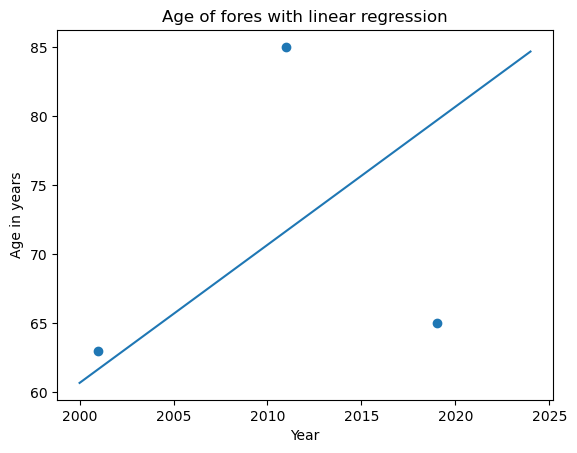

In [13]:
ax = plt.scatter(x,y)
plt.title("Age of fores with linear regression")
plt.xlabel('Year')
plt.ylabel('Age in years')
plt.plot(x_int,y_int)

Our pipeline is good. We can now build a function

In [14]:
def linear_reg_fixed_slope(x_list,y_list,m):
    """This funciton takes in two arrays x and y, and a fixed slope and calculates the intercep b that best fits the data.
    This funciton only workd for linear regression, that is y=mx+b. x and y must be 1D arrays with same length.
    Parameters: 
        x_list: np.array of fixed x values
        y_list: np.array of y data values
        m: slope of linear regression, fixed
    Output:
        b: best b intercept for the given data
    """
    #get the indexes of not nan values
    z = (y_list-x_list*m)
    b = np.nanmean(z)
    
    return b

### Volumn Data Sigmoidal Interpolation

As previously explained, volume to age relationships can be deinfed as sigmoidal, with the following equation: [ln(Y)=a+b*(1/A)] where Y is the volume, A is age and a and b are coefficients. Based on some research of volume to age plots of forests, the coefficient a has to be positive and the coeffocient b has to benegative in the range of about -5 to -15. This is a gross assumption at this stage to generate some usefull data.

In [15]:
y_vol = np.array(ON_forest_and_fires.loc[1000][['vol_2001','vol_2011','vol_2015']],dtype='float')
y_vol = np.log(y_vol)
y_vol

array([4.82076532, 5.45694373, 4.56226268])

We will use our interpolated data to calucalte the age of these volumes

In [16]:
x_vol_age = np.array([2001,2011,2015])

Generate the x-axis age for the volume years

In [17]:
x_vol = x_vol_age + np.mean(b_array)
x_vol

array([61.66666667, 71.66666667, 75.66666667])

In [18]:
import math
from scipy.optimize import curve_fit
def volume_age(x,,a,b,m):
    return (a*(1-np.exp(b*x))**m)

popt, pcov=curve_fit(volume_age,x_vol, y_vol, method='dogbox',bounds=((1,-20),(1000,-1)))

x_vol_fit = np.arange(1,200,1)
y_vol_fit = np.exp(volume_age(x_vol_fit,popt[0],popt[1]))
plt.plot(x_vol_fit,y_vol_fit)
plt.scatter(x_vol,np.exp(y_vol),color='red')

SyntaxError: invalid syntax (290581317.py, line 3)

In [19]:
popt

array([ 4.9611191, -1.       ])

 Now that we have our interpolation functions, we need to come up with a pipeline and some functions to go throught our data and generate the required information for each year. Lets remind oursleve of what our data looks like

In [21]:
ON_forest_and_fires.head()

age_2001  age_2011  age_2019  year_harvested  vol_2001  vol_2011  vol_2015  \
0     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
1     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
2     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
3     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
4      57.0       NaN       NaN             NaN     38.69       NaN       NaN   

         lon        lat                                           geometry  \
0 -84.890501  46.906052  POLYGON ((-84.88863710751139 46.90697579711416...   
1 -84.885743  46.912303  POLYGON ((-84.88387922029249 46.91322718112671...   
2 -84.887410  46.919261  POLYGON ((-84.88554623463179 46.92018483757417...   
3 -84.884197  46.918908  POLYGON ((-84.88233307531861 46.91983171613633...   
4 -84.748565  46.962634  POLYGON ((-84.74669588337325 46.96355596569322...   

  year month  day area_intersect_perc  number_fires  
0  NaN   NaN  NaN                 NaN           NaN  
1  NaN   NaN  NaN                 NaN           NaN  
2  NaN   NaN  NaN                 NaN           NaN  
3  NaN   NaN  NaN                 NaN           NaN  
4  NaN   NaN  NaN                 NaN           NaN

We want a dunction that will loop through each row, and get the relevant data and boundary/initial conditions for interpolation. To make things easier, lets build one that will get the initial conditions (harves, and fires), one that will get the information for age and one for volume.

   At the end, it would be ideal to have an array for each year that contains the age, volume, harvested or not, fire or not, and maybe percent burned to put in a  dataframe that looks like this, for each year

In [22]:
pd.DataFrame(columns=['age','vol','harvested','burned','percent burned'])

Empty DataFrame
Columns: [age, vol, harvested, burned, percent burned]
Index: []

Then, we will be able to look at each year, do some EDA, visualization and some machine learning to predict if a certain coordinate is succestible to a forest fire or not

Lets get going with our pipeline. The function age_forest loops through evey line of data, and generates a years vs age array based on the fixed slope of 1, initial boundary conditions as assumed from disturbances (harvesiting, forest fires) 

In [21]:
def age_forest(data,n_years,year_sep = 12):
    """
    """
    n_years = n_years+1
    m=1
    inc = 1/12
    #Firts condition is if there are no fires and no harvest
    if (data.isna()['number_fires'] == True) & (data.isna()['year_harvested'] == True):
        set_years = np.array([2001,2011,2019])
        set_ages = np.array(data[['age_2001','age_2011','age_2019']])
        b = linear_reg_fixed_slope(set_years,set_ages,m)
        years = np.arange(2001,2001+n_years-1,inc)
        if str(b) != 'nan':
            ages = (years*m+b)
            harvested = np.zeros((n_years-1)*year_sep)
            fires = np.zeros((n_years-1)*year_sep)
            day = np.empty((n_years-1)*year_sep)
            day[:] = np.nan
            disturbance_weight = np.empty((n_years-1)*year_sep)
            disturbance_weight[:] = np.nan
            return ages,fires,harvested,disturbance_weight,day,years
        else:
            ages = np.empty((n_years-1)*year_sep)
            ages[:] = np.nan
            harvested = np.zeros((n_years-1)*year_sep)
            fires = np.zeros((n_years-1)*year_sep)
            day = np.empty((n_years-1)*year_sep)
            day[:] = np.nan
            disturbance_weight = np.empty((n_years-1)*year_sep)
            disturbance_weight[:] = np.nan
            
            return ages,fires,harvested,disturbance_weight,day,years
        
    #next condition is if it was not harvested, but fires occured
    elif (data.isna()['number_fires'] == False) | (data.isna()['year_harvested'] == False):
        if data.isna()['year_harvested'] == True:
            disturbance_years= np.array(data['year'],dtype='float')
            disturbance_months = np.array(data['month'],dtype='float')
            disturbance_years_months = np.round(disturbance_years+disturbance_months/year_sep,2)
            disturbance_factors = np.array(data['area_intersect_perc'],dtype='float')
            
            disturbance_years_months, inv = np.unique(disturbance_years_months, return_inverse=True)      
            temp_df = np.zeros(len(disturbance_years_months), dtype=disturbance_factors.dtype)
            np.add.at(temp_df, inv, disturbance_factors)  
            disturbance_factors=temp_df
            
            #print(disturbance_years)
            #print(disturbance_years_months)
            #print(disturbance_factors)
            
        elif data.isna()['number_fires'] == True:
            disturbance_years= np.array(data[['year_harvested']],dtype='float')
            disturbance_months = np.array([6])
            disturbance_years_months = np.round(disturbance_years + disturbance_months/12,2)
            disturbance_factors = np.array([1])
            #print(disturbance_years)
            #print(disturbance_years_months)
            #print(disturbance_factors)
            
        else:
            
            disturbance_years= np.append(np.array(data['year'],dtype='float'),data['year_harvested'])
            disturbance_factors = np.append(np.array(data['area_intersect_perc'],dtype='float'),1.0)
            disturbance_months = np.append(np.array(data['month'],dtype='float'),6)
            disturbance_years_months = np.round(disturbance_years+disturbance_months/12,2)
            
            disturbance_years_months, inv = np.unique(disturbance_years_months, return_inverse=True)      
            temp_df = np.zeros(len(disturbance_years_months), dtype=disturbance_factors.dtype)
            np.add.at(temp_df, inv, disturbance_factors)  
            disturbance_factors=temp_df
            
            #print(disturbance_years)
            #print(disturbance_years_months)
            #print(disturbance_factors)

        #Create arrays of 1 and 0 for fires and harvest, and the month/day for the fire
        fires,harvested,disturbance_weight,day = [],[],[],[]
        j=0
        for i in np.arange(2001,2001+n_years-1,inc):
            i = np.round(i,2)
            if i in list(disturbance_years_months):
                if i == (np.array(data['year_harvested'],dtype='float')+0.5):
                    harvested.append(1)
                else:
                    fires.append(1)
                    day.append(data['day'])
                    disturbance_weight.append(disturbance_factors[j])
                    j = j+1
            else:
                fires.append(0)
                harvested.append(0)
                day.append(np.nan)
                disturbance_weight.append(np.nan)
        year = 2001
        #print("Starting new pixel at age {}".format(year))
        j=0
        for fire,area,month,i in zip(disturbance_years_months,disturbance_factors,disturbance_months,range(len(disturbance_years))):
            
            #print("abcdefg:",len(disturbance_years))
            #print("year is currently {}".format(year))
            fire = float(fire)
            area = float(area)
            
            if area > 1:
                area = 0.9999
            #print("area of fire is:",area)
            #print("year of distrubance is {} with {}% reductions".format(fire,area*100))
            #print("we are on the {}th fire on this pixel out of {}".format(i+1,len(disturbance_years)))
            
                              
            
            if fire < 2001:
                #print("Years are out of bounds")
                j=0
                continue
            elif (fire >= 2001) & (fire < 2011):
                if (i == 0) | (j==0):
                    set_years=np.array([2001])
                    set_ages=np.array(data['age_2001'])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    if str(b) == 'nan':
                        years = np.arange(year,fire,inc)
                        years[:] = np.nan
                        ages = (years*m+b)
                        year = fire
                        year_age = int((fire)*(1-area))
                    else:
                        years = np.arange(year,fire,inc)
                        ages = (years*m+b)
                        year = fire
                        year_age = int((fire*m+b)*(1-area))

                    j=1

                    continue
                else:
                    set_years=np.array([year])
                    set_ages=np.array([year_age])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    temp_years = np.arange(year,fire,inc)
                    years = np.append(years,temp_years)
                    ages = np.append(ages,(temp_years*m+b))
                    year = fire
                    year_age = int((fire*m+b)*(1-area))

                    j=1
                    continue
            
            elif (fire >= 2011) & (fire < 2019):
                if (i == 0) | (j==0):
                    set_years=np.array([2001,2011])
                    set_ages=np.array(data[['age_2001','age_2011']])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    if str(b) == 'nan':
                        years = np.arange(year,fire,inc)
                        years[:] = np.nan
                        ages = (years*m+b)
                        year = fire
                        year_age = int((fire)*(1-area))
                    else:
                        years = np.arange(year,fire,inc)
                        ages = (years*m+b)
                        year = fire
                        year_age = int((fire*m+b)*(1-area))

                    j=1
                    continue
                else:
                    set_years=np.array([year])
                    set_ages=np.array([year_age])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    temp_years = np.arange(year,fire,inc)
                    years = np.append(years,temp_years)
                    ages = np.append(ages,(temp_years*m+b))
                    year = fire
                    year_age = int((fire*m+b)*(1-area))

                    j=1
                    continue
                
            elif (fire >= 2019) & (fire < (2001+n_years-1)):
                if (i == 0) | (j==0):
                    set_years=np.array([2001,2011,2019])
                    set_ages=np.array(data[['age_2001','age_2011','age_2019']])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    if str(b) == 'nan':
                        years = np.arange(year,fire,inc)
                        years[:] = np.nan
                        ages = (years*m+b)
                        year = fire
                        year_age = int((fire)*(1-area))
                    else:
                        years = np.arange(year,fire,inc)
                        ages = (years*m+b)
                        year = fire
                        year_age = int((fire*m+b)*(1-area))

                    j=1
                    continue
                else:
                    set_years=np.array([year])
                    set_ages=np.array([year_age])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    temp_years = np.arange(year,fire,inc)
                    years = np.append(years,temp_years)
                    ages = np.append(ages,(temp_years*m+b))
                    year = fire
                    year_age = int((fire*m+b)*(1-area))
                    print(year_age)

                    j=1
                    continue
                
        #print("we are finishing approximation")
        if year < 2011:
            set_years=np.array([year,2011,2019])
            set_ages=np.append(year_age,np.array(data[['age_2011','age_2019']]))
            b = linear_reg_fixed_slope(set_years,set_ages,m)
            temp_years = np.arange(year,2001+n_years-1,inc)
            years = np.append(years,temp_years)
            ages = np.append(ages,(temp_years*m+b))
        elif (year >= 2011) & (year < 2019):

            set_years=np.array([year,2019])
            set_ages=np.append(year_age,np.array(data[['age_2019']]))
            b = linear_reg_fixed_slope(set_years,set_ages,m)
            temp_years = np.arange(year,2001+n_years-1,inc)
            years = np.append(years,temp_years)
            ages = np.append(ages,(temp_years*m+b))
        elif (year >= 2019) & (year < (2001+n_years-1)):

            set_years=np.array([year])
            set_ages=np.array(year_age)
            b = linear_reg_fixed_slope(set_years,set_ages,m)
            temp_years = np.arange(year,2001+n_years-1,inc)
            years = np.append(years,temp_years)
            ages = np.append(ages,(temp_years*m+b))
        
        return ages,fires,harvested,disturbance_weight,day,years  
    
    #last condition is if it was harvested, and fires occured
    #elif (data.isna()['number_fires'] == False) & (data.isna()['year_harvested'] == False):
    
    

We can loop through the rows of ON data, and save in increments to save on ram so it doesnt crash

In [22]:
ON_forest_and_fires.iloc[15000000:,:]

age_2001  age_2011  age_2019  year_harvested  vol_2001  vol_2011  \
15000000      17.0      16.0       NaN             NaN     10.76     11.50   
15000001      14.0      11.0       NaN             NaN      8.85      6.17   
15000002      33.0      32.0       NaN             NaN     26.46     34.47   
15000003      39.0      54.0       NaN             NaN     58.84     94.27   
15000004      65.0      47.0       NaN             NaN     99.05     83.97   
...            ...       ...       ...             ...       ...       ...   
15123780      20.0      38.0       NaN             NaN      0.10      5.19   
15123781      40.0      40.0       NaN             NaN      2.54      1.09   
15123782      20.0      21.0       NaN             NaN      9.75     12.93   
15123783      25.0      24.0       NaN             NaN     17.41     15.08   
15123784      20.0      38.0       NaN             NaN      0.10      5.19   

          vol_2015        lon        lat  \
15000000       NaN -76.127740  44.953829   
15000001       NaN -76.130717  44.954475   
15000002       NaN -76.129807  44.956589   
15000003       NaN -76.128897  44.958703   
15000004       NaN -76.125919  44.958057   
...            ...        ...        ...   
15123780       NaN -74.921919  44.991627   
15123781       NaN -74.924881  44.992314   
15123782       NaN -74.927843  44.993000   
15123783       NaN -74.930805  44.993686   
15123784       NaN -74.928810  44.990898   

                                                   geometry year month  day  \
15000000  POLYGON ((-76.12579593211674 44.95456299020972...  NaN   NaN  NaN   
15000001  POLYGON ((-76.1287731443899 44.95520931146511,...  NaN   NaN  NaN   
15000002  POLYGON ((-76.12786291964187 44.95732331010808...  NaN   NaN  NaN   
15000003  POLYGON ((-76.12695260967524 44.95943732005073...  NaN   NaN  NaN   
15000004  POLYGON ((-76.12397514472701 44.95879092571881...  NaN   NaN  NaN   
...                                                     ...  ...   ...  ...   
15123780  POLYGON ((-74.91995458529998 44.99233487913157...  NaN   NaN  NaN   
15123781  POLYGON ((-74.92291648535686 44.99302127787519...  NaN   NaN  NaN   
15123782  POLYGON ((-74.92587847549926 44.9937075809101,...  NaN   NaN  NaN   
15123783  POLYGON ((-74.92884055571841 44.99439378823094...  NaN   NaN  NaN   
15123784  POLYGON ((-74.92684557552529 44.9916058204785,...  NaN   NaN  NaN   

         area_intersect_perc  number_fires  
15000000                 NaN           NaN  
15000001                 NaN           NaN  
15000002                 NaN           NaN  
15000003                 NaN           NaN  
15000004                 NaN           NaN  
...                      ...           ...  
15123780                 NaN           NaN  
15123781                 NaN           NaN  
15123782                 NaN           NaN  
15123783                 NaN           NaN  
15123784                 NaN           NaN  

[123785 rows x 15 columns]

In [23]:

pixels = 15000000
num_blocks = 31
inter = 500000
for j in range(30,num_blocks):
    ages,fires,harvested,disturbance_weight,month,day,years = [],[],[],[],[],[],[]
    if j == (num_blocks-1):
        data = ON_forest_and_fires.iloc[j*inter:,:]
    elif j == 0:
        data = ON_forest_and_fires.iloc[j:inter,:]
    else:
        data = ON_forest_and_fires.iloc[j*inter:inter*(j+1),:]
    for i in range(len(data)):
        print("\n we are on data row",i)
        result = age_forest(data.iloc[i,:],21,12)
        ages.append(result[0])
        fires.append(result[1])
        harvested.append(result[2])
        disturbance_weight.append(result[3])
        day.append(result[4])
    pd.DataFrame(ages).to_csv(path+"\\ages"+str(j)+".csv.gz",compression='gzip')
    pd.DataFrame(fires).to_csv(path+"\\fires"+str(j)+".csv.gz",compression='gzip')
    pd.DataFrame(harvested).to_csv(path+"\\harvested"+str(j)+".csv.gz",compression='gzip')
    pd.DataFrame(disturbance_weight).to_csv(path+"\\disturbance_weight"+str(j)+".csv.gz",compression='gzip')
    pd.DataFrame(day).to_csv(path+"\\day"+str(j)+".csv.gz",compression='gzip')
    



 we are on data row 0

 we are on data row 1

 we are on data row 2

 we are on data row 3

 we are on data row 4

 we are on data row 5

 we are on data row 6

 we are on data row 7

 we are on data row 8

 we are on data row 9

 we are on data row 10

 we are on data row 11

 we are on data row 12

 we are on data row 13

 we are on data row 14

 we are on data row 15

 we are on data row 16

 we are on data row 17

 we are on data row 18

 we are on data row 19

 we are on data row 20

 we are on data row 21

 we are on data row 22

 we are on data row 23

 we are on data row 24

 we are on data row 25

 we are on data row 26

 we are on data row 27

 we are on data row 28

 we are on data row 29

 we are on data row 30

 we are on data row 31

 we are on data row 32

 we are on data row 33

 we are on data row 34

 we are on data row 35

 we are on data row 36

 we are on data row 37

 we are on data row 38

 we are on data row 39

 we are on data row 40

 we are on data row 41

 

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 2250

 we are on data row 2251

 we are on data row 2252

 we are on data row 2253

 we are on data row 2254

 we are on data row 2255

 we are on data row 2256

 we are on data row 2257

 we are on data row 2258

 we are on data row 2259

 we are on data row 2260

 we are on data row 2261

 we are on data row 2262

 we are on data row 2263

 we are on data row 2264

 we are on data row 2265

 we are on data row 2266

 we are on data row 2267

 we are on data row 2268

 we are on data row 2269

 we are on data row 2270

 we are on data row 2271

 we are on data row 2272

 we are on data row 2273

 we are on data row 2274

 we are on data row 2275

 we are on data row 2276

 we are on data row 2277

 we are on data row 2278

 we are on data row 2279

 we are on data row 2280

 we are on data row 2281

 we are on data row 2282

 we are on data row 2283

 we are on data row 2284

 we are on data row 2285

 we are on data row 2286

 we are on data row 2287

 we are on 

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 3286

 we are on data row 3287

 we are on data row 3288

 we are on data row 3289

 we are on data row 3290

 we are on data row 3291

 we are on data row 3292

 we are on data row 3293

 we are on data row 3294

 we are on data row 3295

 we are on data row 3296

 we are on data row 3297

 we are on data row 3298

 we are on data row 3299

 we are on data row 3300

 we are on data row 3301

 we are on data row 3302

 we are on data row 3303

 we are on data row 3304

 we are on data row 3305

 we are on data row 3306

 we are on data row 3307

 we are on data row 3308

 we are on data row 3309

 we are on data row 3310

 we are on data row 3311

 we are on data row 3312

 we are on data row 3313

 we are on data row 3314

 we are on data row 3315

 we are on data row 3316

 we are on data row 3317

 we are on data row 3318

 we are on data row 3319

 we are on data row 3320

 we are on data row 3321

 we are on data row 3322

 we are on data row 3323

 we are on 

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 8987

 we are on data row 8988

 we are on data row 8989

 we are on data row 8990

 we are on data row 8991

 we are on data row 8992

 we are on data row 8993

 we are on data row 8994

 we are on data row 8995

 we are on data row 8996

 we are on data row 8997

 we are on data row 8998

 we are on data row 8999

 we are on data row 9000

 we are on data row 9001

 we are on data row 9002

 we are on data row 9003

 we are on data row 9004

 we are on data row 9005

 we are on data row 9006

 we are on data row 9007

 we are on data row 9008

 we are on data row 9009

 we are on data row 9010

 we are on data row 9011

 we are on data row 9012

 we are on data row 9013

 we are on data row 9014

 we are on data row 9015

 we are on data row 9016

 we are on data row 9017

 we are on data row 9018

 we are on data row 9019

 we are on data row 9020

 we are on data row 9021

 we are on data row 9022

 we are on data row 9023

 we are on data row 9024

 we are on 

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 14354

 we are on data row 14355

 we are on data row 14356

 we are on data row 14357

 we are on data row 14358

 we are on data row 14359

 we are on data row 14360

 we are on data row 14361

 we are on data row 14362

 we are on data row 14363

 we are on data row 14364

 we are on data row 14365

 we are on data row 14366

 we are on data row 14367

 we are on data row 14368

 we are on data row 14369

 we are on data row 14370

 we are on data row 14371

 we are on data row 14372

 we are on data row 14373

 we are on data row 14374

 we are on data row 14375

 we are on data row 14376

 we are on data row 14377

 we are on data row 14378

 we are on data row 14379

 we are on data row 14380

 we are on data row 14381

 we are on data row 14382

 we are on data row 14383

 we are on data row 14384

 we are on data row 14385

 we are on data row 14386

 we are on data row 14387

 we are on data row 14388

 we are on data row 14389

 we are on data row 14390



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 14892

 we are on data row 14893

 we are on data row 14894

 we are on data row 14895

 we are on data row 14896

 we are on data row 14897

 we are on data row 14898

 we are on data row 14899

 we are on data row 14900

 we are on data row 14901

 we are on data row 14902

 we are on data row 14903

 we are on data row 14904

 we are on data row 14905

 we are on data row 14906

 we are on data row 14907

 we are on data row 14908

 we are on data row 14909

 we are on data row 14910

 we are on data row 14911

 we are on data row 14912

 we are on data row 14913

 we are on data row 14914

 we are on data row 14915

 we are on data row 14916

 we are on data row 14917

 we are on data row 14918

 we are on data row 14919

 we are on data row 14920

 we are on data row 14921

 we are on data row 14922

 we are on data row 14923

 we are on data row 14924

 we are on data row 14925

 we are on data row 14926

 we are on data row 14927

 we are on data row 14928



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 15539

 we are on data row 15540

 we are on data row 15541

 we are on data row 15542

 we are on data row 15543

 we are on data row 15544

 we are on data row 15545

 we are on data row 15546

 we are on data row 15547

 we are on data row 15548

 we are on data row 15549

 we are on data row 15550

 we are on data row 15551

 we are on data row 15552

 we are on data row 15553

 we are on data row 15554

 we are on data row 15555

 we are on data row 15556

 we are on data row 15557

 we are on data row 15558

 we are on data row 15559

 we are on data row 15560

 we are on data row 15561

 we are on data row 15562

 we are on data row 15563

 we are on data row 15564

 we are on data row 15565

 we are on data row 15566

 we are on data row 15567

 we are on data row 15568

 we are on data row 15569

 we are on data row 15570

 we are on data row 15571

 we are on data row 15572

 we are on data row 15573

 we are on data row 15574

 we are on data row 15575



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 16780

 we are on data row 16781

 we are on data row 16782

 we are on data row 16783

 we are on data row 16784

 we are on data row 16785

 we are on data row 16786

 we are on data row 16787

 we are on data row 16788

 we are on data row 16789

 we are on data row 16790

 we are on data row 16791

 we are on data row 16792

 we are on data row 16793

 we are on data row 16794

 we are on data row 16795

 we are on data row 16796

 we are on data row 16797

 we are on data row 16798

 we are on data row 16799

 we are on data row 16800

 we are on data row 16801

 we are on data row 16802

 we are on data row 16803

 we are on data row 16804

 we are on data row 16805

 we are on data row 16806

 we are on data row 16807

 we are on data row 16808

 we are on data row 16809

 we are on data row 16810

 we are on data row 16811

 we are on data row 16812

 we are on data row 16813

 we are on data row 16814

 we are on data row 16815

 we are on data row 16816



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 18382

 we are on data row 18383

 we are on data row 18384

 we are on data row 18385

 we are on data row 18386

 we are on data row 18387

 we are on data row 18388

 we are on data row 18389

 we are on data row 18390

 we are on data row 18391

 we are on data row 18392

 we are on data row 18393

 we are on data row 18394

 we are on data row 18395

 we are on data row 18396

 we are on data row 18397

 we are on data row 18398

 we are on data row 18399

 we are on data row 18400

 we are on data row 18401

 we are on data row 18402

 we are on data row 18403

 we are on data row 18404

 we are on data row 18405

 we are on data row 18406

 we are on data row 18407

 we are on data row 18408

 we are on data row 18409

 we are on data row 18410

 we are on data row 18411

 we are on data row 18412

 we are on data row 18413

 we are on data row 18414

 we are on data row 18415

 we are on data row 18416

 we are on data row 18417

 we are on data row 18418



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 20450

 we are on data row 20451

 we are on data row 20452

 we are on data row 20453

 we are on data row 20454

 we are on data row 20455

 we are on data row 20456

 we are on data row 20457

 we are on data row 20458

 we are on data row 20459

 we are on data row 20460

 we are on data row 20461

 we are on data row 20462

 we are on data row 20463

 we are on data row 20464

 we are on data row 20465

 we are on data row 20466

 we are on data row 20467

 we are on data row 20468

 we are on data row 20469

 we are on data row 20470

 we are on data row 20471

 we are on data row 20472

 we are on data row 20473

 we are on data row 20474

 we are on data row 20475

 we are on data row 20476

 we are on data row 20477

 we are on data row 20478

 we are on data row 20479

 we are on data row 20480

 we are on data row 20481

 we are on data row 20482

 we are on data row 20483

 we are on data row 20484

 we are on data row 20485

 we are on data row 20486



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 21018

 we are on data row 21019

 we are on data row 21020

 we are on data row 21021

 we are on data row 21022

 we are on data row 21023

 we are on data row 21024

 we are on data row 21025

 we are on data row 21026

 we are on data row 21027

 we are on data row 21028

 we are on data row 21029

 we are on data row 21030

 we are on data row 21031

 we are on data row 21032

 we are on data row 21033

 we are on data row 21034

 we are on data row 21035

 we are on data row 21036

 we are on data row 21037

 we are on data row 21038

 we are on data row 21039

 we are on data row 21040

 we are on data row 21041

 we are on data row 21042

 we are on data row 21043

 we are on data row 21044

 we are on data row 21045

 we are on data row 21046

 we are on data row 21047

 we are on data row 21048

 we are on data row 21049

 we are on data row 21050

 we are on data row 21051

 we are on data row 21052

 we are on data row 21053

 we are on data row 21054



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 21665

 we are on data row 21666

 we are on data row 21667

 we are on data row 21668

 we are on data row 21669

 we are on data row 21670

 we are on data row 21671

 we are on data row 21672

 we are on data row 21673

 we are on data row 21674

 we are on data row 21675

 we are on data row 21676

 we are on data row 21677

 we are on data row 21678

 we are on data row 21679

 we are on data row 21680

 we are on data row 21681

 we are on data row 21682

 we are on data row 21683

 we are on data row 21684

 we are on data row 21685

 we are on data row 21686

 we are on data row 21687

 we are on data row 21688

 we are on data row 21689

 we are on data row 21690

 we are on data row 21691

 we are on data row 21692

 we are on data row 21693

 we are on data row 21694

 we are on data row 21695

 we are on data row 21696

 we are on data row 21697

 we are on data row 21698

 we are on data row 21699

 we are on data row 21700

 we are on data row 21701



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 21974

 we are on data row 21975

 we are on data row 21976

 we are on data row 21977

 we are on data row 21978

 we are on data row 21979

 we are on data row 21980

 we are on data row 21981

 we are on data row 21982

 we are on data row 21983

 we are on data row 21984

 we are on data row 21985

 we are on data row 21986

 we are on data row 21987

 we are on data row 21988

 we are on data row 21989

 we are on data row 21990

 we are on data row 21991

 we are on data row 21992

 we are on data row 21993

 we are on data row 21994

 we are on data row 21995

 we are on data row 21996

 we are on data row 21997

 we are on data row 21998

 we are on data row 21999

 we are on data row 22000

 we are on data row 22001

 we are on data row 22002

 we are on data row 22003

 we are on data row 22004

 we are on data row 22005

 we are on data row 22006

 we are on data row 22007

 we are on data row 22008

 we are on data row 22009

 we are on data row 22010



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 22274

 we are on data row 22275

 we are on data row 22276

 we are on data row 22277

 we are on data row 22278

 we are on data row 22279

 we are on data row 22280

 we are on data row 22281

 we are on data row 22282

 we are on data row 22283

 we are on data row 22284

 we are on data row 22285

 we are on data row 22286

 we are on data row 22287

 we are on data row 22288

 we are on data row 22289

 we are on data row 22290

 we are on data row 22291

 we are on data row 22292

 we are on data row 22293

 we are on data row 22294

 we are on data row 22295

 we are on data row 22296

 we are on data row 22297

 we are on data row 22298

 we are on data row 22299

 we are on data row 22300

 we are on data row 22301

 we are on data row 22302

 we are on data row 22303

 we are on data row 22304

 we are on data row 22305

 we are on data row 22306

 we are on data row 22307

 we are on data row 22308

 we are on data row 22309

 we are on data row 22310



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 23221

 we are on data row 23222

 we are on data row 23223

 we are on data row 23224

 we are on data row 23225

 we are on data row 23226

 we are on data row 23227

 we are on data row 23228

 we are on data row 23229

 we are on data row 23230

 we are on data row 23231

 we are on data row 23232

 we are on data row 23233

 we are on data row 23234

 we are on data row 23235

 we are on data row 23236

 we are on data row 23237

 we are on data row 23238

 we are on data row 23239

 we are on data row 23240

 we are on data row 23241

 we are on data row 23242

 we are on data row 23243

 we are on data row 23244

 we are on data row 23245

 we are on data row 23246

 we are on data row 23247

 we are on data row 23248

 we are on data row 23249

 we are on data row 23250

 we are on data row 23251

 we are on data row 23252

 we are on data row 23253

 we are on data row 23254

 we are on data row 23255

 we are on data row 23256

 we are on data row 23257



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 24527

 we are on data row 24528

 we are on data row 24529

 we are on data row 24530

 we are on data row 24531

 we are on data row 24532

 we are on data row 24533

 we are on data row 24534

 we are on data row 24535

 we are on data row 24536

 we are on data row 24537

 we are on data row 24538

 we are on data row 24539

 we are on data row 24540

 we are on data row 24541

 we are on data row 24542

 we are on data row 24543

 we are on data row 24544

 we are on data row 24545

 we are on data row 24546

 we are on data row 24547

 we are on data row 24548

 we are on data row 24549

 we are on data row 24550

 we are on data row 24551

 we are on data row 24552

 we are on data row 24553

 we are on data row 24554

 we are on data row 24555

 we are on data row 24556

 we are on data row 24557

 we are on data row 24558

 we are on data row 24559

 we are on data row 24560

 we are on data row 24561

 we are on data row 24562

 we are on data row 24563



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 26463

 we are on data row 26464

 we are on data row 26465

 we are on data row 26466

 we are on data row 26467

 we are on data row 26468

 we are on data row 26469

 we are on data row 26470

 we are on data row 26471

 we are on data row 26472

 we are on data row 26473

 we are on data row 26474

 we are on data row 26475

 we are on data row 26476

 we are on data row 26477

 we are on data row 26478

 we are on data row 26479

 we are on data row 26480

 we are on data row 26481

 we are on data row 26482

 we are on data row 26483

 we are on data row 26484

 we are on data row 26485

 we are on data row 26486

 we are on data row 26487

 we are on data row 26488

 we are on data row 26489

 we are on data row 26490

 we are on data row 26491

 we are on data row 26492

 we are on data row 26493

 we are on data row 26494

 we are on data row 26495

 we are on data row 26496

 we are on data row 26497

 we are on data row 26498

 we are on data row 26499



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 29303

 we are on data row 29304

 we are on data row 29305

 we are on data row 29306

 we are on data row 29307

 we are on data row 29308

 we are on data row 29309

 we are on data row 29310

 we are on data row 29311

 we are on data row 29312

 we are on data row 29313

 we are on data row 29314

 we are on data row 29315

 we are on data row 29316

 we are on data row 29317

 we are on data row 29318

 we are on data row 29319

 we are on data row 29320

 we are on data row 29321

 we are on data row 29322

 we are on data row 29323

 we are on data row 29324

 we are on data row 29325

 we are on data row 29326

 we are on data row 29327

 we are on data row 29328

 we are on data row 29329

 we are on data row 29330

 we are on data row 29331

 we are on data row 29332

 we are on data row 29333

 we are on data row 29334

 we are on data row 29335

 we are on data row 29336

 we are on data row 29337

 we are on data row 29338

 we are on data row 29339



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 30078

 we are on data row 30079

 we are on data row 30080

 we are on data row 30081

 we are on data row 30082

 we are on data row 30083

 we are on data row 30084

 we are on data row 30085

 we are on data row 30086

 we are on data row 30087

 we are on data row 30088

 we are on data row 30089

 we are on data row 30090

 we are on data row 30091

 we are on data row 30092

 we are on data row 30093

 we are on data row 30094

 we are on data row 30095

 we are on data row 30096

 we are on data row 30097

 we are on data row 30098

 we are on data row 30099

 we are on data row 30100

 we are on data row 30101

 we are on data row 30102

 we are on data row 30103

 we are on data row 30104

 we are on data row 30105

 we are on data row 30106

 we are on data row 30107

 we are on data row 30108

 we are on data row 30109

 we are on data row 30110

 we are on data row 30111

 we are on data row 30112

 we are on data row 30113

 we are on data row 30114



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 31908

 we are on data row 31909

 we are on data row 31910

 we are on data row 31911

 we are on data row 31912

 we are on data row 31913

 we are on data row 31914

 we are on data row 31915

 we are on data row 31916

 we are on data row 31917

 we are on data row 31918

 we are on data row 31919

 we are on data row 31920

 we are on data row 31921

 we are on data row 31922

 we are on data row 31923

 we are on data row 31924

 we are on data row 31925

 we are on data row 31926

 we are on data row 31927

 we are on data row 31928

 we are on data row 31929

 we are on data row 31930

 we are on data row 31931

 we are on data row 31932

 we are on data row 31933

 we are on data row 31934

 we are on data row 31935

 we are on data row 31936

 we are on data row 31937

 we are on data row 31938

 we are on data row 31939

 we are on data row 31940

 we are on data row 31941

 we are on data row 31942

 we are on data row 31943

 we are on data row 31944



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 32230

 we are on data row 32231

 we are on data row 32232

 we are on data row 32233

 we are on data row 32234

 we are on data row 32235

 we are on data row 32236

 we are on data row 32237

 we are on data row 32238

 we are on data row 32239

 we are on data row 32240

 we are on data row 32241

 we are on data row 32242

 we are on data row 32243

 we are on data row 32244

 we are on data row 32245

 we are on data row 32246

 we are on data row 32247

 we are on data row 32248

 we are on data row 32249

 we are on data row 32250

 we are on data row 32251

 we are on data row 32252

 we are on data row 32253

 we are on data row 32254

 we are on data row 32255

 we are on data row 32256

 we are on data row 32257

 we are on data row 32258

 we are on data row 32259

 we are on data row 32260

 we are on data row 32261

 we are on data row 32262

 we are on data row 32263

 we are on data row 32264

 we are on data row 32265

 we are on data row 32266



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 34261

 we are on data row 34262

 we are on data row 34263

 we are on data row 34264

 we are on data row 34265

 we are on data row 34266

 we are on data row 34267

 we are on data row 34268

 we are on data row 34269

 we are on data row 34270

 we are on data row 34271

 we are on data row 34272

 we are on data row 34273

 we are on data row 34274

 we are on data row 34275

 we are on data row 34276

 we are on data row 34277

 we are on data row 34278

 we are on data row 34279

 we are on data row 34280

 we are on data row 34281

 we are on data row 34282

 we are on data row 34283

 we are on data row 34284

 we are on data row 34285

 we are on data row 34286

 we are on data row 34287

 we are on data row 34288

 we are on data row 34289

 we are on data row 34290

 we are on data row 34291

 we are on data row 34292

 we are on data row 34293

 we are on data row 34294

 we are on data row 34295

 we are on data row 34296

 we are on data row 34297



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 34638

 we are on data row 34639

 we are on data row 34640

 we are on data row 34641

 we are on data row 34642

 we are on data row 34643

 we are on data row 34644

 we are on data row 34645

 we are on data row 34646

 we are on data row 34647

 we are on data row 34648

 we are on data row 34649

 we are on data row 34650

 we are on data row 34651

 we are on data row 34652

 we are on data row 34653

 we are on data row 34654

 we are on data row 34655

 we are on data row 34656

 we are on data row 34657

 we are on data row 34658

 we are on data row 34659

 we are on data row 34660

 we are on data row 34661

 we are on data row 34662

 we are on data row 34663

 we are on data row 34664

 we are on data row 34665

 we are on data row 34666

 we are on data row 34667

 we are on data row 34668

 we are on data row 34669

 we are on data row 34670

 we are on data row 34671

 we are on data row 34672

 we are on data row 34673

 we are on data row 34674



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 35325

 we are on data row 35326

 we are on data row 35327

 we are on data row 35328

 we are on data row 35329

 we are on data row 35330

 we are on data row 35331

 we are on data row 35332

 we are on data row 35333

 we are on data row 35334

 we are on data row 35335

 we are on data row 35336

 we are on data row 35337

 we are on data row 35338

 we are on data row 35339

 we are on data row 35340

 we are on data row 35341

 we are on data row 35342

 we are on data row 35343

 we are on data row 35344

 we are on data row 35345

 we are on data row 35346

 we are on data row 35347

 we are on data row 35348

 we are on data row 35349

 we are on data row 35350

 we are on data row 35351

 we are on data row 35352

 we are on data row 35353

 we are on data row 35354

 we are on data row 35355

 we are on data row 35356

 we are on data row 35357

 we are on data row 35358

 we are on data row 35359

 we are on data row 35360

 we are on data row 35361



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 35692

 we are on data row 35693

 we are on data row 35694

 we are on data row 35695

 we are on data row 35696

 we are on data row 35697

 we are on data row 35698

 we are on data row 35699

 we are on data row 35700

 we are on data row 35701

 we are on data row 35702

 we are on data row 35703

 we are on data row 35704

 we are on data row 35705

 we are on data row 35706

 we are on data row 35707

 we are on data row 35708

 we are on data row 35709

 we are on data row 35710

 we are on data row 35711

 we are on data row 35712

 we are on data row 35713

 we are on data row 35714

 we are on data row 35715

 we are on data row 35716

 we are on data row 35717

 we are on data row 35718

 we are on data row 35719

 we are on data row 35720

 we are on data row 35721

 we are on data row 35722

 we are on data row 35723

 we are on data row 35724

 we are on data row 35725

 we are on data row 35726

 we are on data row 35727

 we are on data row 35728



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 36004

 we are on data row 36005

 we are on data row 36006

 we are on data row 36007

 we are on data row 36008

 we are on data row 36009

 we are on data row 36010

 we are on data row 36011

 we are on data row 36012

 we are on data row 36013

 we are on data row 36014

 we are on data row 36015

 we are on data row 36016

 we are on data row 36017

 we are on data row 36018

 we are on data row 36019

 we are on data row 36020

 we are on data row 36021

 we are on data row 36022

 we are on data row 36023

 we are on data row 36024

 we are on data row 36025

 we are on data row 36026

 we are on data row 36027

 we are on data row 36028

 we are on data row 36029

 we are on data row 36030

 we are on data row 36031

 we are on data row 36032

 we are on data row 36033

 we are on data row 36034

 we are on data row 36035

 we are on data row 36036

 we are on data row 36037

 we are on data row 36038

 we are on data row 36039

 we are on data row 36040



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 37139

 we are on data row 37140

 we are on data row 37141

 we are on data row 37142

 we are on data row 37143

 we are on data row 37144

 we are on data row 37145

 we are on data row 37146

 we are on data row 37147

 we are on data row 37148

 we are on data row 37149

 we are on data row 37150

 we are on data row 37151

 we are on data row 37152

 we are on data row 37153

 we are on data row 37154

 we are on data row 37155

 we are on data row 37156

 we are on data row 37157

 we are on data row 37158

 we are on data row 37159

 we are on data row 37160

 we are on data row 37161

 we are on data row 37162

 we are on data row 37163

 we are on data row 37164

 we are on data row 37165

 we are on data row 37166

 we are on data row 37167

 we are on data row 37168

 we are on data row 37169

 we are on data row 37170

 we are on data row 37171

 we are on data row 37172

 we are on data row 37173

 we are on data row 37174

 we are on data row 37175



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 37513

 we are on data row 37514

 we are on data row 37515

 we are on data row 37516

 we are on data row 37517

 we are on data row 37518

 we are on data row 37519

 we are on data row 37520

 we are on data row 37521

 we are on data row 37522

 we are on data row 37523

 we are on data row 37524

 we are on data row 37525

 we are on data row 37526

 we are on data row 37527

 we are on data row 37528

 we are on data row 37529

 we are on data row 37530

 we are on data row 37531

 we are on data row 37532

 we are on data row 37533

 we are on data row 37534

 we are on data row 37535

 we are on data row 37536

 we are on data row 37537

 we are on data row 37538

 we are on data row 37539

 we are on data row 37540

 we are on data row 37541

 we are on data row 37542

 we are on data row 37543

 we are on data row 37544

 we are on data row 37545

 we are on data row 37546

 we are on data row 37547

 we are on data row 37548

 we are on data row 37549



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 38551

 we are on data row 38552

 we are on data row 38553

 we are on data row 38554

 we are on data row 38555

 we are on data row 38556

 we are on data row 38557

 we are on data row 38558

 we are on data row 38559

 we are on data row 38560

 we are on data row 38561

 we are on data row 38562

 we are on data row 38563

 we are on data row 38564

 we are on data row 38565

 we are on data row 38566

 we are on data row 38567

 we are on data row 38568

 we are on data row 38569

 we are on data row 38570

 we are on data row 38571

 we are on data row 38572

 we are on data row 38573

 we are on data row 38574

 we are on data row 38575

 we are on data row 38576

 we are on data row 38577

 we are on data row 38578

 we are on data row 38579

 we are on data row 38580

 we are on data row 38581

 we are on data row 38582

 we are on data row 38583

 we are on data row 38584

 we are on data row 38585

 we are on data row 38586

 we are on data row 38587



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 39502

 we are on data row 39503

 we are on data row 39504

 we are on data row 39505

 we are on data row 39506

 we are on data row 39507

 we are on data row 39508

 we are on data row 39509

 we are on data row 39510

 we are on data row 39511

 we are on data row 39512

 we are on data row 39513

 we are on data row 39514

 we are on data row 39515

 we are on data row 39516

 we are on data row 39517

 we are on data row 39518

 we are on data row 39519

 we are on data row 39520

 we are on data row 39521

 we are on data row 39522

 we are on data row 39523

 we are on data row 39524

 we are on data row 39525

 we are on data row 39526

 we are on data row 39527

 we are on data row 39528

 we are on data row 39529

 we are on data row 39530

 we are on data row 39531

 we are on data row 39532

 we are on data row 39533

 we are on data row 39534

 we are on data row 39535

 we are on data row 39536

 we are on data row 39537

 we are on data row 39538



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 39811

 we are on data row 39812

 we are on data row 39813

 we are on data row 39814

 we are on data row 39815

 we are on data row 39816

 we are on data row 39817

 we are on data row 39818

 we are on data row 39819

 we are on data row 39820

 we are on data row 39821

 we are on data row 39822

 we are on data row 39823

 we are on data row 39824

 we are on data row 39825

 we are on data row 39826

 we are on data row 39827

 we are on data row 39828

 we are on data row 39829

 we are on data row 39830

 we are on data row 39831

 we are on data row 39832

 we are on data row 39833

 we are on data row 39834

 we are on data row 39835

 we are on data row 39836

 we are on data row 39837

 we are on data row 39838

 we are on data row 39839

 we are on data row 39840

 we are on data row 39841

 we are on data row 39842

 we are on data row 39843

 we are on data row 39844

 we are on data row 39845

 we are on data row 39846

 we are on data row 39847



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 40254

 we are on data row 40255

 we are on data row 40256

 we are on data row 40257

 we are on data row 40258

 we are on data row 40259

 we are on data row 40260

 we are on data row 40261

 we are on data row 40262

 we are on data row 40263

 we are on data row 40264

 we are on data row 40265

 we are on data row 40266

 we are on data row 40267

 we are on data row 40268

 we are on data row 40269

 we are on data row 40270

 we are on data row 40271

 we are on data row 40272

 we are on data row 40273

 we are on data row 40274

 we are on data row 40275

 we are on data row 40276

 we are on data row 40277

 we are on data row 40278

 we are on data row 40279

 we are on data row 40280

 we are on data row 40281

 we are on data row 40282

 we are on data row 40283

 we are on data row 40284

 we are on data row 40285

 we are on data row 40286

 we are on data row 40287

 we are on data row 40288

 we are on data row 40289

 we are on data row 40290



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 40600

 we are on data row 40601

 we are on data row 40602

 we are on data row 40603

 we are on data row 40604

 we are on data row 40605

 we are on data row 40606

 we are on data row 40607

 we are on data row 40608

 we are on data row 40609

 we are on data row 40610

 we are on data row 40611

 we are on data row 40612

 we are on data row 40613

 we are on data row 40614

 we are on data row 40615

 we are on data row 40616

 we are on data row 40617

 we are on data row 40618

 we are on data row 40619

 we are on data row 40620

 we are on data row 40621

 we are on data row 40622

 we are on data row 40623

 we are on data row 40624

 we are on data row 40625

 we are on data row 40626

 we are on data row 40627

 we are on data row 40628

 we are on data row 40629

 we are on data row 40630

 we are on data row 40631

 we are on data row 40632

 we are on data row 40633

 we are on data row 40634

 we are on data row 40635

 we are on data row 40636



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 40903

 we are on data row 40904

 we are on data row 40905

 we are on data row 40906

 we are on data row 40907

 we are on data row 40908

 we are on data row 40909

 we are on data row 40910

 we are on data row 40911

 we are on data row 40912

 we are on data row 40913

 we are on data row 40914

 we are on data row 40915

 we are on data row 40916

 we are on data row 40917

 we are on data row 40918

 we are on data row 40919

 we are on data row 40920

 we are on data row 40921

 we are on data row 40922

 we are on data row 40923

 we are on data row 40924

 we are on data row 40925

 we are on data row 40926

 we are on data row 40927

 we are on data row 40928

 we are on data row 40929

 we are on data row 40930

 we are on data row 40931

 we are on data row 40932

 we are on data row 40933

 we are on data row 40934

 we are on data row 40935

 we are on data row 40936

 we are on data row 40937

 we are on data row 40938

 we are on data row 40939



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 41243

 we are on data row 41244

 we are on data row 41245

 we are on data row 41246

 we are on data row 41247

 we are on data row 41248

 we are on data row 41249

 we are on data row 41250

 we are on data row 41251

 we are on data row 41252

 we are on data row 41253

 we are on data row 41254

 we are on data row 41255

 we are on data row 41256

 we are on data row 41257

 we are on data row 41258

 we are on data row 41259

 we are on data row 41260

 we are on data row 41261

 we are on data row 41262

 we are on data row 41263

 we are on data row 41264

 we are on data row 41265

 we are on data row 41266

 we are on data row 41267

 we are on data row 41268

 we are on data row 41269

 we are on data row 41270

 we are on data row 41271

 we are on data row 41272

 we are on data row 41273

 we are on data row 41274

 we are on data row 41275

 we are on data row 41276

 we are on data row 41277

 we are on data row 41278

 we are on data row 41279



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 41534

 we are on data row 41535

 we are on data row 41536

 we are on data row 41537

 we are on data row 41538

 we are on data row 41539

 we are on data row 41540

 we are on data row 41541

 we are on data row 41542

 we are on data row 41543

 we are on data row 41544

 we are on data row 41545

 we are on data row 41546

 we are on data row 41547

 we are on data row 41548

 we are on data row 41549

 we are on data row 41550

 we are on data row 41551

 we are on data row 41552

 we are on data row 41553

 we are on data row 41554

 we are on data row 41555

 we are on data row 41556

 we are on data row 41557

 we are on data row 41558

 we are on data row 41559

 we are on data row 41560

 we are on data row 41561

 we are on data row 41562

 we are on data row 41563

 we are on data row 41564

 we are on data row 41565

 we are on data row 41566

 we are on data row 41567

 we are on data row 41568

 we are on data row 41569

 we are on data row 41570



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 41860

 we are on data row 41861

 we are on data row 41862

 we are on data row 41863

 we are on data row 41864

 we are on data row 41865

 we are on data row 41866

 we are on data row 41867

 we are on data row 41868

 we are on data row 41869

 we are on data row 41870

 we are on data row 41871

 we are on data row 41872

 we are on data row 41873

 we are on data row 41874

 we are on data row 41875

 we are on data row 41876

 we are on data row 41877

 we are on data row 41878

 we are on data row 41879

 we are on data row 41880

 we are on data row 41881

 we are on data row 41882

 we are on data row 41883

 we are on data row 41884

 we are on data row 41885

 we are on data row 41886

 we are on data row 41887

 we are on data row 41888

 we are on data row 41889

 we are on data row 41890

 we are on data row 41891

 we are on data row 41892

 we are on data row 41893

 we are on data row 41894

 we are on data row 41895

 we are on data row 41896



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 42140

 we are on data row 42141

 we are on data row 42142

 we are on data row 42143

 we are on data row 42144

 we are on data row 42145

 we are on data row 42146

 we are on data row 42147

 we are on data row 42148

 we are on data row 42149

 we are on data row 42150

 we are on data row 42151

 we are on data row 42152

 we are on data row 42153

 we are on data row 42154

 we are on data row 42155

 we are on data row 42156

 we are on data row 42157

 we are on data row 42158

 we are on data row 42159

 we are on data row 42160

 we are on data row 42161

 we are on data row 42162

 we are on data row 42163

 we are on data row 42164

 we are on data row 42165

 we are on data row 42166

 we are on data row 42167

 we are on data row 42168

 we are on data row 42169

 we are on data row 42170

 we are on data row 42171

 we are on data row 42172

 we are on data row 42173

 we are on data row 42174

 we are on data row 42175

 we are on data row 42176



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 42414

 we are on data row 42415

 we are on data row 42416

 we are on data row 42417

 we are on data row 42418

 we are on data row 42419

 we are on data row 42420

 we are on data row 42421

 we are on data row 42422

 we are on data row 42423

 we are on data row 42424

 we are on data row 42425

 we are on data row 42426

 we are on data row 42427

 we are on data row 42428

 we are on data row 42429

 we are on data row 42430

 we are on data row 42431

 we are on data row 42432

 we are on data row 42433

 we are on data row 42434

 we are on data row 42435

 we are on data row 42436

 we are on data row 42437

 we are on data row 42438

 we are on data row 42439

 we are on data row 42440

 we are on data row 42441

 we are on data row 42442

 we are on data row 42443

 we are on data row 42444

 we are on data row 42445

 we are on data row 42446

 we are on data row 42447

 we are on data row 42448

 we are on data row 42449

 we are on data row 42450



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 42742

 we are on data row 42743

 we are on data row 42744

 we are on data row 42745

 we are on data row 42746

 we are on data row 42747

 we are on data row 42748

 we are on data row 42749

 we are on data row 42750

 we are on data row 42751

 we are on data row 42752

 we are on data row 42753

 we are on data row 42754

 we are on data row 42755

 we are on data row 42756

 we are on data row 42757

 we are on data row 42758

 we are on data row 42759

 we are on data row 42760

 we are on data row 42761

 we are on data row 42762

 we are on data row 42763

 we are on data row 42764

 we are on data row 42765

 we are on data row 42766

 we are on data row 42767

 we are on data row 42768

 we are on data row 42769

 we are on data row 42770

 we are on data row 42771

 we are on data row 42772

 we are on data row 42773

 we are on data row 42774

 we are on data row 42775

 we are on data row 42776

 we are on data row 42777

 we are on data row 42778



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 43067

 we are on data row 43068

 we are on data row 43069

 we are on data row 43070

 we are on data row 43071

 we are on data row 43072

 we are on data row 43073

 we are on data row 43074

 we are on data row 43075

 we are on data row 43076

 we are on data row 43077

 we are on data row 43078

 we are on data row 43079

 we are on data row 43080

 we are on data row 43081

 we are on data row 43082

 we are on data row 43083

 we are on data row 43084

 we are on data row 43085

 we are on data row 43086

 we are on data row 43087

 we are on data row 43088

 we are on data row 43089

 we are on data row 43090

 we are on data row 43091

 we are on data row 43092

 we are on data row 43093

 we are on data row 43094

 we are on data row 43095

 we are on data row 43096

 we are on data row 43097

 we are on data row 43098

 we are on data row 43099

 we are on data row 43100

 we are on data row 43101

 we are on data row 43102

 we are on data row 43103



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 43725

 we are on data row 43726

 we are on data row 43727

 we are on data row 43728

 we are on data row 43729

 we are on data row 43730

 we are on data row 43731

 we are on data row 43732

 we are on data row 43733

 we are on data row 43734

 we are on data row 43735

 we are on data row 43736

 we are on data row 43737

 we are on data row 43738

 we are on data row 43739

 we are on data row 43740

 we are on data row 43741

 we are on data row 43742

 we are on data row 43743

 we are on data row 43744

 we are on data row 43745

 we are on data row 43746

 we are on data row 43747

 we are on data row 43748

 we are on data row 43749

 we are on data row 43750

 we are on data row 43751

 we are on data row 43752

 we are on data row 43753

 we are on data row 43754

 we are on data row 43755

 we are on data row 43756

 we are on data row 43757

 we are on data row 43758

 we are on data row 43759

 we are on data row 43760

 we are on data row 43761



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 43988

 we are on data row 43989

 we are on data row 43990

 we are on data row 43991

 we are on data row 43992

 we are on data row 43993

 we are on data row 43994

 we are on data row 43995

 we are on data row 43996

 we are on data row 43997

 we are on data row 43998

 we are on data row 43999

 we are on data row 44000

 we are on data row 44001

 we are on data row 44002

 we are on data row 44003

 we are on data row 44004

 we are on data row 44005

 we are on data row 44006

 we are on data row 44007

 we are on data row 44008

 we are on data row 44009

 we are on data row 44010

 we are on data row 44011

 we are on data row 44012

 we are on data row 44013

 we are on data row 44014

 we are on data row 44015

 we are on data row 44016

 we are on data row 44017

 we are on data row 44018

 we are on data row 44019

 we are on data row 44020

 we are on data row 44021

 we are on data row 44022

 we are on data row 44023

 we are on data row 44024



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 44499

 we are on data row 44500

 we are on data row 44501

 we are on data row 44502

 we are on data row 44503

 we are on data row 44504

 we are on data row 44505

 we are on data row 44506

 we are on data row 44507

 we are on data row 44508

 we are on data row 44509

 we are on data row 44510

 we are on data row 44511

 we are on data row 44512

 we are on data row 44513

 we are on data row 44514

 we are on data row 44515

 we are on data row 44516

 we are on data row 44517

 we are on data row 44518

 we are on data row 44519

 we are on data row 44520

 we are on data row 44521

 we are on data row 44522

 we are on data row 44523

 we are on data row 44524

 we are on data row 44525

 we are on data row 44526

 we are on data row 44527

 we are on data row 44528

 we are on data row 44529

 we are on data row 44530

 we are on data row 44531

 we are on data row 44532

 we are on data row 44533

 we are on data row 44534

 we are on data row 44535



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 44780

 we are on data row 44781

 we are on data row 44782

 we are on data row 44783

 we are on data row 44784

 we are on data row 44785

 we are on data row 44786

 we are on data row 44787

 we are on data row 44788

 we are on data row 44789

 we are on data row 44790

 we are on data row 44791

 we are on data row 44792

 we are on data row 44793

 we are on data row 44794

 we are on data row 44795

 we are on data row 44796

 we are on data row 44797

 we are on data row 44798

 we are on data row 44799

 we are on data row 44800

 we are on data row 44801

 we are on data row 44802

 we are on data row 44803

 we are on data row 44804

 we are on data row 44805

 we are on data row 44806

 we are on data row 44807

 we are on data row 44808

 we are on data row 44809

 we are on data row 44810

 we are on data row 44811

 we are on data row 44812

 we are on data row 44813

 we are on data row 44814

 we are on data row 44815

 we are on data row 44816



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 45347

 we are on data row 45348

 we are on data row 45349

 we are on data row 45350

 we are on data row 45351

 we are on data row 45352

 we are on data row 45353

 we are on data row 45354

 we are on data row 45355

 we are on data row 45356

 we are on data row 45357

 we are on data row 45358

 we are on data row 45359

 we are on data row 45360

 we are on data row 45361

 we are on data row 45362

 we are on data row 45363

 we are on data row 45364

 we are on data row 45365

 we are on data row 45366

 we are on data row 45367

 we are on data row 45368

 we are on data row 45369

 we are on data row 45370

 we are on data row 45371

 we are on data row 45372

 we are on data row 45373

 we are on data row 45374

 we are on data row 45375

 we are on data row 45376

 we are on data row 45377

 we are on data row 45378

 we are on data row 45379

 we are on data row 45380

 we are on data row 45381

 we are on data row 45382

 we are on data row 45383



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 45579

 we are on data row 45580

 we are on data row 45581

 we are on data row 45582

 we are on data row 45583

 we are on data row 45584

 we are on data row 45585

 we are on data row 45586

 we are on data row 45587

 we are on data row 45588

 we are on data row 45589

 we are on data row 45590

 we are on data row 45591

 we are on data row 45592

 we are on data row 45593

 we are on data row 45594

 we are on data row 45595

 we are on data row 45596

 we are on data row 45597

 we are on data row 45598

 we are on data row 45599

 we are on data row 45600

 we are on data row 45601

 we are on data row 45602

 we are on data row 45603

 we are on data row 45604

 we are on data row 45605

 we are on data row 45606

 we are on data row 45607

 we are on data row 45608

 we are on data row 45609

 we are on data row 45610

 we are on data row 45611

 we are on data row 45612

 we are on data row 45613

 we are on data row 45614

 we are on data row 45615



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 45855

 we are on data row 45856

 we are on data row 45857

 we are on data row 45858

 we are on data row 45859

 we are on data row 45860

 we are on data row 45861

 we are on data row 45862

 we are on data row 45863

 we are on data row 45864

 we are on data row 45865

 we are on data row 45866

 we are on data row 45867

 we are on data row 45868

 we are on data row 45869

 we are on data row 45870

 we are on data row 45871

 we are on data row 45872

 we are on data row 45873

 we are on data row 45874

 we are on data row 45875

 we are on data row 45876

 we are on data row 45877

 we are on data row 45878

 we are on data row 45879

 we are on data row 45880

 we are on data row 45881

 we are on data row 45882

 we are on data row 45883

 we are on data row 45884

 we are on data row 45885

 we are on data row 45886

 we are on data row 45887

 we are on data row 45888

 we are on data row 45889

 we are on data row 45890

 we are on data row 45891



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 46409

 we are on data row 46410

 we are on data row 46411

 we are on data row 46412

 we are on data row 46413

 we are on data row 46414

 we are on data row 46415

 we are on data row 46416

 we are on data row 46417

 we are on data row 46418

 we are on data row 46419

 we are on data row 46420

 we are on data row 46421

 we are on data row 46422

 we are on data row 46423

 we are on data row 46424

 we are on data row 46425

 we are on data row 46426

 we are on data row 46427

 we are on data row 46428

 we are on data row 46429

 we are on data row 46430

 we are on data row 46431

 we are on data row 46432

 we are on data row 46433

 we are on data row 46434

 we are on data row 46435

 we are on data row 46436

 we are on data row 46437

 we are on data row 46438

 we are on data row 46439

 we are on data row 46440

 we are on data row 46441

 we are on data row 46442

 we are on data row 46443

 we are on data row 46444

 we are on data row 46445



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 47464

 we are on data row 47465

 we are on data row 47466

 we are on data row 47467

 we are on data row 47468

 we are on data row 47469

 we are on data row 47470

 we are on data row 47471

 we are on data row 47472

 we are on data row 47473

 we are on data row 47474

 we are on data row 47475

 we are on data row 47476

 we are on data row 47477

 we are on data row 47478

 we are on data row 47479

 we are on data row 47480

 we are on data row 47481

 we are on data row 47482

 we are on data row 47483

 we are on data row 47484

 we are on data row 47485

 we are on data row 47486

 we are on data row 47487

 we are on data row 47488

 we are on data row 47489

 we are on data row 47490

 we are on data row 47491

 we are on data row 47492

 we are on data row 47493

 we are on data row 47494

 we are on data row 47495

 we are on data row 47496

 we are on data row 47497

 we are on data row 47498

 we are on data row 47499

 we are on data row 47500



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 49629

 we are on data row 49630

 we are on data row 49631

 we are on data row 49632

 we are on data row 49633

 we are on data row 49634

 we are on data row 49635

 we are on data row 49636

 we are on data row 49637

 we are on data row 49638

 we are on data row 49639

 we are on data row 49640

 we are on data row 49641

 we are on data row 49642

 we are on data row 49643

 we are on data row 49644

 we are on data row 49645

 we are on data row 49646

 we are on data row 49647

 we are on data row 49648

 we are on data row 49649

 we are on data row 49650

 we are on data row 49651

 we are on data row 49652

 we are on data row 49653

 we are on data row 49654

 we are on data row 49655

 we are on data row 49656

 we are on data row 49657

 we are on data row 49658

 we are on data row 49659

 we are on data row 49660

 we are on data row 49661

 we are on data row 49662

 we are on data row 49663

 we are on data row 49664

 we are on data row 49665



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 50134

 we are on data row 50135

 we are on data row 50136

 we are on data row 50137

 we are on data row 50138

 we are on data row 50139

 we are on data row 50140

 we are on data row 50141

 we are on data row 50142

 we are on data row 50143

 we are on data row 50144

 we are on data row 50145

 we are on data row 50146

 we are on data row 50147

 we are on data row 50148

 we are on data row 50149

 we are on data row 50150

 we are on data row 50151

 we are on data row 50152

 we are on data row 50153

 we are on data row 50154

 we are on data row 50155

 we are on data row 50156

 we are on data row 50157

 we are on data row 50158

 we are on data row 50159

 we are on data row 50160

 we are on data row 50161

 we are on data row 50162

 we are on data row 50163

 we are on data row 50164

 we are on data row 50165

 we are on data row 50166

 we are on data row 50167

 we are on data row 50168

 we are on data row 50169

 we are on data row 50170



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 50350

 we are on data row 50351

 we are on data row 50352

 we are on data row 50353

 we are on data row 50354

 we are on data row 50355

 we are on data row 50356

 we are on data row 50357

 we are on data row 50358

 we are on data row 50359

 we are on data row 50360

 we are on data row 50361

 we are on data row 50362

 we are on data row 50363

 we are on data row 50364

 we are on data row 50365

 we are on data row 50366

 we are on data row 50367

 we are on data row 50368

 we are on data row 50369

 we are on data row 50370

 we are on data row 50371

 we are on data row 50372

 we are on data row 50373

 we are on data row 50374

 we are on data row 50375

 we are on data row 50376

 we are on data row 50377

 we are on data row 50378

 we are on data row 50379

 we are on data row 50380

 we are on data row 50381

 we are on data row 50382

 we are on data row 50383

 we are on data row 50384

 we are on data row 50385

 we are on data row 50386



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 51672

 we are on data row 51673

 we are on data row 51674

 we are on data row 51675

 we are on data row 51676

 we are on data row 51677

 we are on data row 51678

 we are on data row 51679

 we are on data row 51680

 we are on data row 51681

 we are on data row 51682

 we are on data row 51683

 we are on data row 51684

 we are on data row 51685

 we are on data row 51686

 we are on data row 51687

 we are on data row 51688

 we are on data row 51689

 we are on data row 51690

 we are on data row 51691

 we are on data row 51692

 we are on data row 51693

 we are on data row 51694

 we are on data row 51695

 we are on data row 51696

 we are on data row 51697

 we are on data row 51698

 we are on data row 51699

 we are on data row 51700

 we are on data row 51701

 we are on data row 51702

 we are on data row 51703

 we are on data row 51704

 we are on data row 51705

 we are on data row 51706

 we are on data row 51707

 we are on data row 51708



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 51966

 we are on data row 51967

 we are on data row 51968

 we are on data row 51969

 we are on data row 51970

 we are on data row 51971

 we are on data row 51972

 we are on data row 51973

 we are on data row 51974

 we are on data row 51975

 we are on data row 51976

 we are on data row 51977

 we are on data row 51978

 we are on data row 51979

 we are on data row 51980

 we are on data row 51981

 we are on data row 51982

 we are on data row 51983

 we are on data row 51984

 we are on data row 51985

 we are on data row 51986

 we are on data row 51987

 we are on data row 51988

 we are on data row 51989

 we are on data row 51990

 we are on data row 51991

 we are on data row 51992

 we are on data row 51993

 we are on data row 51994

 we are on data row 51995

 we are on data row 51996

 we are on data row 51997

 we are on data row 51998

 we are on data row 51999

 we are on data row 52000

 we are on data row 52001

 we are on data row 52002



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 52231

 we are on data row 52232

 we are on data row 52233

 we are on data row 52234

 we are on data row 52235

 we are on data row 52236

 we are on data row 52237

 we are on data row 52238

 we are on data row 52239

 we are on data row 52240

 we are on data row 52241

 we are on data row 52242

 we are on data row 52243

 we are on data row 52244

 we are on data row 52245

 we are on data row 52246

 we are on data row 52247

 we are on data row 52248

 we are on data row 52249

 we are on data row 52250

 we are on data row 52251

 we are on data row 52252

 we are on data row 52253

 we are on data row 52254

 we are on data row 52255

 we are on data row 52256

 we are on data row 52257

 we are on data row 52258

 we are on data row 52259

 we are on data row 52260

 we are on data row 52261

 we are on data row 52262

 we are on data row 52263

 we are on data row 52264

 we are on data row 52265

 we are on data row 52266

 we are on data row 52267



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 52582

 we are on data row 52583

 we are on data row 52584

 we are on data row 52585

 we are on data row 52586

 we are on data row 52587

 we are on data row 52588

 we are on data row 52589

 we are on data row 52590

 we are on data row 52591

 we are on data row 52592

 we are on data row 52593

 we are on data row 52594

 we are on data row 52595

 we are on data row 52596

 we are on data row 52597

 we are on data row 52598

 we are on data row 52599

 we are on data row 52600

 we are on data row 52601

 we are on data row 52602

 we are on data row 52603

 we are on data row 52604

 we are on data row 52605

 we are on data row 52606

 we are on data row 52607

 we are on data row 52608

 we are on data row 52609

 we are on data row 52610

 we are on data row 52611

 we are on data row 52612

 we are on data row 52613

 we are on data row 52614

 we are on data row 52615

 we are on data row 52616

 we are on data row 52617

 we are on data row 52618



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 53141

 we are on data row 53142

 we are on data row 53143

 we are on data row 53144

 we are on data row 53145

 we are on data row 53146

 we are on data row 53147

 we are on data row 53148

 we are on data row 53149

 we are on data row 53150

 we are on data row 53151

 we are on data row 53152

 we are on data row 53153

 we are on data row 53154

 we are on data row 53155

 we are on data row 53156

 we are on data row 53157

 we are on data row 53158

 we are on data row 53159

 we are on data row 53160

 we are on data row 53161

 we are on data row 53162

 we are on data row 53163

 we are on data row 53164

 we are on data row 53165

 we are on data row 53166

 we are on data row 53167

 we are on data row 53168

 we are on data row 53169

 we are on data row 53170

 we are on data row 53171

 we are on data row 53172

 we are on data row 53173

 we are on data row 53174

 we are on data row 53175

 we are on data row 53176

 we are on data row 53177



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 53402

 we are on data row 53403

 we are on data row 53404

 we are on data row 53405

 we are on data row 53406

 we are on data row 53407

 we are on data row 53408

 we are on data row 53409

 we are on data row 53410

 we are on data row 53411

 we are on data row 53412

 we are on data row 53413

 we are on data row 53414

 we are on data row 53415

 we are on data row 53416

 we are on data row 53417

 we are on data row 53418

 we are on data row 53419

 we are on data row 53420

 we are on data row 53421

 we are on data row 53422

 we are on data row 53423

 we are on data row 53424

 we are on data row 53425

 we are on data row 53426

 we are on data row 53427

 we are on data row 53428

 we are on data row 53429

 we are on data row 53430

 we are on data row 53431

 we are on data row 53432

 we are on data row 53433

 we are on data row 53434

 we are on data row 53435

 we are on data row 53436

 we are on data row 53437

 we are on data row 53438



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 53923

 we are on data row 53924

 we are on data row 53925

 we are on data row 53926

 we are on data row 53927

 we are on data row 53928

 we are on data row 53929

 we are on data row 53930

 we are on data row 53931

 we are on data row 53932

 we are on data row 53933

 we are on data row 53934

 we are on data row 53935

 we are on data row 53936

 we are on data row 53937

 we are on data row 53938

 we are on data row 53939

 we are on data row 53940

 we are on data row 53941

 we are on data row 53942

 we are on data row 53943

 we are on data row 53944

 we are on data row 53945

 we are on data row 53946

 we are on data row 53947

 we are on data row 53948

 we are on data row 53949

 we are on data row 53950

 we are on data row 53951

 we are on data row 53952

 we are on data row 53953

 we are on data row 53954

 we are on data row 53955

 we are on data row 53956

 we are on data row 53957

 we are on data row 53958

 we are on data row 53959



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 54202

 we are on data row 54203

 we are on data row 54204

 we are on data row 54205

 we are on data row 54206

 we are on data row 54207

 we are on data row 54208

 we are on data row 54209

 we are on data row 54210

 we are on data row 54211

 we are on data row 54212

 we are on data row 54213

 we are on data row 54214

 we are on data row 54215

 we are on data row 54216

 we are on data row 54217

 we are on data row 54218

 we are on data row 54219

 we are on data row 54220

 we are on data row 54221

 we are on data row 54222

 we are on data row 54223

 we are on data row 54224

 we are on data row 54225

 we are on data row 54226

 we are on data row 54227

 we are on data row 54228

 we are on data row 54229

 we are on data row 54230

 we are on data row 54231

 we are on data row 54232

 we are on data row 54233

 we are on data row 54234

 we are on data row 54235

 we are on data row 54236

 we are on data row 54237

 we are on data row 54238



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 54526

 we are on data row 54527

 we are on data row 54528

 we are on data row 54529

 we are on data row 54530

 we are on data row 54531

 we are on data row 54532

 we are on data row 54533

 we are on data row 54534

 we are on data row 54535

 we are on data row 54536

 we are on data row 54537

 we are on data row 54538

 we are on data row 54539

 we are on data row 54540

 we are on data row 54541

 we are on data row 54542

 we are on data row 54543

 we are on data row 54544

 we are on data row 54545

 we are on data row 54546

 we are on data row 54547

 we are on data row 54548

 we are on data row 54549

 we are on data row 54550

 we are on data row 54551

 we are on data row 54552

 we are on data row 54553

 we are on data row 54554

 we are on data row 54555

 we are on data row 54556

 we are on data row 54557

 we are on data row 54558

 we are on data row 54559

 we are on data row 54560

 we are on data row 54561

 we are on data row 54562



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 54831

 we are on data row 54832

 we are on data row 54833

 we are on data row 54834

 we are on data row 54835

 we are on data row 54836

 we are on data row 54837

 we are on data row 54838

 we are on data row 54839

 we are on data row 54840

 we are on data row 54841

 we are on data row 54842

 we are on data row 54843

 we are on data row 54844

 we are on data row 54845

 we are on data row 54846

 we are on data row 54847

 we are on data row 54848

 we are on data row 54849

 we are on data row 54850

 we are on data row 54851

 we are on data row 54852

 we are on data row 54853

 we are on data row 54854

 we are on data row 54855

 we are on data row 54856

 we are on data row 54857

 we are on data row 54858

 we are on data row 54859

 we are on data row 54860

 we are on data row 54861

 we are on data row 54862

 we are on data row 54863

 we are on data row 54864

 we are on data row 54865

 we are on data row 54866

 we are on data row 54867



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 55101

 we are on data row 55102

 we are on data row 55103

 we are on data row 55104

 we are on data row 55105

 we are on data row 55106

 we are on data row 55107

 we are on data row 55108

 we are on data row 55109

 we are on data row 55110

 we are on data row 55111

 we are on data row 55112

 we are on data row 55113

 we are on data row 55114

 we are on data row 55115

 we are on data row 55116

 we are on data row 55117

 we are on data row 55118

 we are on data row 55119

 we are on data row 55120

 we are on data row 55121

 we are on data row 55122

 we are on data row 55123

 we are on data row 55124

 we are on data row 55125

 we are on data row 55126

 we are on data row 55127

 we are on data row 55128

 we are on data row 55129

 we are on data row 55130

 we are on data row 55131

 we are on data row 55132

 we are on data row 55133

 we are on data row 55134

 we are on data row 55135

 we are on data row 55136

 we are on data row 55137



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 55411

 we are on data row 55412

 we are on data row 55413

 we are on data row 55414

 we are on data row 55415

 we are on data row 55416

 we are on data row 55417

 we are on data row 55418

 we are on data row 55419

 we are on data row 55420

 we are on data row 55421

 we are on data row 55422

 we are on data row 55423

 we are on data row 55424

 we are on data row 55425

 we are on data row 55426

 we are on data row 55427

 we are on data row 55428

 we are on data row 55429

 we are on data row 55430

 we are on data row 55431

 we are on data row 55432

 we are on data row 55433

 we are on data row 55434

 we are on data row 55435

 we are on data row 55436

 we are on data row 55437

 we are on data row 55438

 we are on data row 55439

 we are on data row 55440

 we are on data row 55441

 we are on data row 55442

 we are on data row 55443

 we are on data row 55444

 we are on data row 55445

 we are on data row 55446

 we are on data row 55447



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 55759

 we are on data row 55760

 we are on data row 55761

 we are on data row 55762

 we are on data row 55763

 we are on data row 55764

 we are on data row 55765

 we are on data row 55766

 we are on data row 55767

 we are on data row 55768

 we are on data row 55769

 we are on data row 55770

 we are on data row 55771

 we are on data row 55772

 we are on data row 55773

 we are on data row 55774

 we are on data row 55775

 we are on data row 55776

 we are on data row 55777

 we are on data row 55778

 we are on data row 55779

 we are on data row 55780

 we are on data row 55781

 we are on data row 55782

 we are on data row 55783

 we are on data row 55784

 we are on data row 55785

 we are on data row 55786

 we are on data row 55787

 we are on data row 55788

 we are on data row 55789

 we are on data row 55790

 we are on data row 55791

 we are on data row 55792

 we are on data row 55793

 we are on data row 55794

 we are on data row 55795



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 56559

 we are on data row 56560

 we are on data row 56561

 we are on data row 56562

 we are on data row 56563

 we are on data row 56564

 we are on data row 56565

 we are on data row 56566

 we are on data row 56567

 we are on data row 56568

 we are on data row 56569

 we are on data row 56570

 we are on data row 56571

 we are on data row 56572

 we are on data row 56573

 we are on data row 56574

 we are on data row 56575

 we are on data row 56576

 we are on data row 56577

 we are on data row 56578

 we are on data row 56579

 we are on data row 56580

 we are on data row 56581

 we are on data row 56582

 we are on data row 56583

 we are on data row 56584

 we are on data row 56585

 we are on data row 56586

 we are on data row 56587

 we are on data row 56588

 we are on data row 56589

 we are on data row 56590

 we are on data row 56591

 we are on data row 56592

 we are on data row 56593

 we are on data row 56594

 we are on data row 56595



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 56848

 we are on data row 56849

 we are on data row 56850

 we are on data row 56851

 we are on data row 56852

 we are on data row 56853

 we are on data row 56854

 we are on data row 56855

 we are on data row 56856

 we are on data row 56857

 we are on data row 56858

 we are on data row 56859

 we are on data row 56860

 we are on data row 56861

 we are on data row 56862

 we are on data row 56863

 we are on data row 56864

 we are on data row 56865

 we are on data row 56866

 we are on data row 56867

 we are on data row 56868

 we are on data row 56869

 we are on data row 56870

 we are on data row 56871

 we are on data row 56872

 we are on data row 56873

 we are on data row 56874

 we are on data row 56875

 we are on data row 56876

 we are on data row 56877

 we are on data row 56878

 we are on data row 56879

 we are on data row 56880

 we are on data row 56881

 we are on data row 56882

 we are on data row 56883

 we are on data row 56884



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 57166

 we are on data row 57167

 we are on data row 57168

 we are on data row 57169

 we are on data row 57170

 we are on data row 57171

 we are on data row 57172

 we are on data row 57173

 we are on data row 57174

 we are on data row 57175

 we are on data row 57176

 we are on data row 57177

 we are on data row 57178

 we are on data row 57179

 we are on data row 57180

 we are on data row 57181

 we are on data row 57182

 we are on data row 57183

 we are on data row 57184

 we are on data row 57185

 we are on data row 57186

 we are on data row 57187

 we are on data row 57188

 we are on data row 57189

 we are on data row 57190

 we are on data row 57191

 we are on data row 57192

 we are on data row 57193

 we are on data row 57194

 we are on data row 57195

 we are on data row 57196

 we are on data row 57197

 we are on data row 57198

 we are on data row 57199

 we are on data row 57200

 we are on data row 57201

 we are on data row 57202



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 57459

 we are on data row 57460

 we are on data row 57461

 we are on data row 57462

 we are on data row 57463

 we are on data row 57464

 we are on data row 57465

 we are on data row 57466

 we are on data row 57467

 we are on data row 57468

 we are on data row 57469

 we are on data row 57470

 we are on data row 57471

 we are on data row 57472

 we are on data row 57473

 we are on data row 57474

 we are on data row 57475

 we are on data row 57476

 we are on data row 57477

 we are on data row 57478

 we are on data row 57479

 we are on data row 57480

 we are on data row 57481

 we are on data row 57482

 we are on data row 57483

 we are on data row 57484

 we are on data row 57485

 we are on data row 57486

 we are on data row 57487

 we are on data row 57488

 we are on data row 57489

 we are on data row 57490

 we are on data row 57491

 we are on data row 57492

 we are on data row 57493

 we are on data row 57494

 we are on data row 57495



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 57764

 we are on data row 57765

 we are on data row 57766

 we are on data row 57767

 we are on data row 57768

 we are on data row 57769

 we are on data row 57770

 we are on data row 57771

 we are on data row 57772

 we are on data row 57773

 we are on data row 57774

 we are on data row 57775

 we are on data row 57776

 we are on data row 57777

 we are on data row 57778

 we are on data row 57779

 we are on data row 57780

 we are on data row 57781

 we are on data row 57782

 we are on data row 57783

 we are on data row 57784

 we are on data row 57785

 we are on data row 57786

 we are on data row 57787

 we are on data row 57788

 we are on data row 57789

 we are on data row 57790

 we are on data row 57791

 we are on data row 57792

 we are on data row 57793

 we are on data row 57794

 we are on data row 57795

 we are on data row 57796

 we are on data row 57797

 we are on data row 57798

 we are on data row 57799

 we are on data row 57800



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 58065

 we are on data row 58066

 we are on data row 58067

 we are on data row 58068

 we are on data row 58069

 we are on data row 58070

 we are on data row 58071

 we are on data row 58072

 we are on data row 58073

 we are on data row 58074

 we are on data row 58075

 we are on data row 58076

 we are on data row 58077

 we are on data row 58078

 we are on data row 58079

 we are on data row 58080

 we are on data row 58081

 we are on data row 58082

 we are on data row 58083

 we are on data row 58084

 we are on data row 58085

 we are on data row 58086

 we are on data row 58087

 we are on data row 58088

 we are on data row 58089

 we are on data row 58090

 we are on data row 58091

 we are on data row 58092

 we are on data row 58093

 we are on data row 58094

 we are on data row 58095

 we are on data row 58096

 we are on data row 58097

 we are on data row 58098

 we are on data row 58099

 we are on data row 58100

 we are on data row 58101



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 58406

 we are on data row 58407

 we are on data row 58408

 we are on data row 58409

 we are on data row 58410

 we are on data row 58411

 we are on data row 58412

 we are on data row 58413

 we are on data row 58414

 we are on data row 58415

 we are on data row 58416

 we are on data row 58417

 we are on data row 58418

 we are on data row 58419

 we are on data row 58420

 we are on data row 58421

 we are on data row 58422

 we are on data row 58423

 we are on data row 58424

 we are on data row 58425

 we are on data row 58426

 we are on data row 58427

 we are on data row 58428

 we are on data row 58429

 we are on data row 58430

 we are on data row 58431

 we are on data row 58432

 we are on data row 58433

 we are on data row 58434

 we are on data row 58435

 we are on data row 58436

 we are on data row 58437

 we are on data row 58438

 we are on data row 58439

 we are on data row 58440

 we are on data row 58441

 we are on data row 58442



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 58765

 we are on data row 58766

 we are on data row 58767

 we are on data row 58768

 we are on data row 58769

 we are on data row 58770

 we are on data row 58771

 we are on data row 58772

 we are on data row 58773

 we are on data row 58774

 we are on data row 58775

 we are on data row 58776

 we are on data row 58777

 we are on data row 58778

 we are on data row 58779

 we are on data row 58780

 we are on data row 58781

 we are on data row 58782

 we are on data row 58783

 we are on data row 58784

 we are on data row 58785

 we are on data row 58786

 we are on data row 58787

 we are on data row 58788

 we are on data row 58789

 we are on data row 58790

 we are on data row 58791

 we are on data row 58792

 we are on data row 58793

 we are on data row 58794

 we are on data row 58795

 we are on data row 58796

 we are on data row 58797

 we are on data row 58798

 we are on data row 58799

 we are on data row 58800

 we are on data row 58801



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 59092

 we are on data row 59093

 we are on data row 59094

 we are on data row 59095

 we are on data row 59096

 we are on data row 59097

 we are on data row 59098

 we are on data row 59099

 we are on data row 59100

 we are on data row 59101

 we are on data row 59102

 we are on data row 59103

 we are on data row 59104

 we are on data row 59105

 we are on data row 59106

 we are on data row 59107

 we are on data row 59108

 we are on data row 59109

 we are on data row 59110

 we are on data row 59111

 we are on data row 59112

 we are on data row 59113

 we are on data row 59114

 we are on data row 59115

 we are on data row 59116

 we are on data row 59117

 we are on data row 59118

 we are on data row 59119

 we are on data row 59120

 we are on data row 59121

 we are on data row 59122

 we are on data row 59123

 we are on data row 59124

 we are on data row 59125

 we are on data row 59126

 we are on data row 59127

 we are on data row 59128



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 59971

 we are on data row 59972

 we are on data row 59973

 we are on data row 59974

 we are on data row 59975

 we are on data row 59976

 we are on data row 59977

 we are on data row 59978

 we are on data row 59979

 we are on data row 59980

 we are on data row 59981

 we are on data row 59982

 we are on data row 59983

 we are on data row 59984

 we are on data row 59985

 we are on data row 59986

 we are on data row 59987

 we are on data row 59988

 we are on data row 59989

 we are on data row 59990

 we are on data row 59991

 we are on data row 59992

 we are on data row 59993

 we are on data row 59994

 we are on data row 59995

 we are on data row 59996

 we are on data row 59997

 we are on data row 59998

 we are on data row 59999

 we are on data row 60000

 we are on data row 60001

 we are on data row 60002

 we are on data row 60003

 we are on data row 60004

 we are on data row 60005

 we are on data row 60006

 we are on data row 60007



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 60301

 we are on data row 60302

 we are on data row 60303

 we are on data row 60304

 we are on data row 60305

 we are on data row 60306

 we are on data row 60307

 we are on data row 60308

 we are on data row 60309

 we are on data row 60310

 we are on data row 60311

 we are on data row 60312

 we are on data row 60313

 we are on data row 60314

 we are on data row 60315

 we are on data row 60316

 we are on data row 60317

 we are on data row 60318

 we are on data row 60319

 we are on data row 60320

 we are on data row 60321

 we are on data row 60322

 we are on data row 60323

 we are on data row 60324

 we are on data row 60325

 we are on data row 60326

 we are on data row 60327

 we are on data row 60328

 we are on data row 60329

 we are on data row 60330

 we are on data row 60331

 we are on data row 60332

 we are on data row 60333

 we are on data row 60334

 we are on data row 60335

 we are on data row 60336

 we are on data row 60337



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 60809

 we are on data row 60810

 we are on data row 60811

 we are on data row 60812

 we are on data row 60813

 we are on data row 60814

 we are on data row 60815

 we are on data row 60816

 we are on data row 60817

 we are on data row 60818

 we are on data row 60819

 we are on data row 60820

 we are on data row 60821

 we are on data row 60822

 we are on data row 60823

 we are on data row 60824

 we are on data row 60825

 we are on data row 60826

 we are on data row 60827

 we are on data row 60828

 we are on data row 60829

 we are on data row 60830

 we are on data row 60831

 we are on data row 60832

 we are on data row 60833

 we are on data row 60834

 we are on data row 60835

 we are on data row 60836

 we are on data row 60837

 we are on data row 60838

 we are on data row 60839

 we are on data row 60840

 we are on data row 60841

 we are on data row 60842

 we are on data row 60843

 we are on data row 60844

 we are on data row 60845



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 61105

 we are on data row 61106

 we are on data row 61107

 we are on data row 61108

 we are on data row 61109

 we are on data row 61110

 we are on data row 61111

 we are on data row 61112

 we are on data row 61113

 we are on data row 61114

 we are on data row 61115

 we are on data row 61116

 we are on data row 61117

 we are on data row 61118

 we are on data row 61119

 we are on data row 61120

 we are on data row 61121

 we are on data row 61122

 we are on data row 61123

 we are on data row 61124

 we are on data row 61125

 we are on data row 61126

 we are on data row 61127

 we are on data row 61128

 we are on data row 61129

 we are on data row 61130

 we are on data row 61131

 we are on data row 61132

 we are on data row 61133

 we are on data row 61134

 we are on data row 61135

 we are on data row 61136

 we are on data row 61137

 we are on data row 61138

 we are on data row 61139

 we are on data row 61140

 we are on data row 61141



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 61772

 we are on data row 61773

 we are on data row 61774

 we are on data row 61775

 we are on data row 61776

 we are on data row 61777

 we are on data row 61778

 we are on data row 61779

 we are on data row 61780

 we are on data row 61781

 we are on data row 61782

 we are on data row 61783

 we are on data row 61784

 we are on data row 61785

 we are on data row 61786

 we are on data row 61787

 we are on data row 61788

 we are on data row 61789

 we are on data row 61790

 we are on data row 61791

 we are on data row 61792

 we are on data row 61793

 we are on data row 61794

 we are on data row 61795

 we are on data row 61796

 we are on data row 61797

 we are on data row 61798

 we are on data row 61799

 we are on data row 61800

 we are on data row 61801

 we are on data row 61802

 we are on data row 61803

 we are on data row 61804

 we are on data row 61805

 we are on data row 61806

 we are on data row 61807

 we are on data row 61808



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 62175

 we are on data row 62176

 we are on data row 62177

 we are on data row 62178

 we are on data row 62179

 we are on data row 62180

 we are on data row 62181

 we are on data row 62182

 we are on data row 62183

 we are on data row 62184

 we are on data row 62185

 we are on data row 62186

 we are on data row 62187

 we are on data row 62188

 we are on data row 62189

 we are on data row 62190

 we are on data row 62191

 we are on data row 62192

 we are on data row 62193

 we are on data row 62194

 we are on data row 62195

 we are on data row 62196

 we are on data row 62197

 we are on data row 62198

 we are on data row 62199

 we are on data row 62200

 we are on data row 62201

 we are on data row 62202

 we are on data row 62203

 we are on data row 62204

 we are on data row 62205

 we are on data row 62206

 we are on data row 62207

 we are on data row 62208

 we are on data row 62209

 we are on data row 62210

 we are on data row 62211



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 62433

 we are on data row 62434

 we are on data row 62435

 we are on data row 62436

 we are on data row 62437

 we are on data row 62438

 we are on data row 62439

 we are on data row 62440

 we are on data row 62441

 we are on data row 62442

 we are on data row 62443

 we are on data row 62444

 we are on data row 62445

 we are on data row 62446

 we are on data row 62447

 we are on data row 62448

 we are on data row 62449

 we are on data row 62450

 we are on data row 62451

 we are on data row 62452

 we are on data row 62453

 we are on data row 62454

 we are on data row 62455

 we are on data row 62456

 we are on data row 62457

 we are on data row 62458

 we are on data row 62459

 we are on data row 62460

 we are on data row 62461

 we are on data row 62462

 we are on data row 62463

 we are on data row 62464

 we are on data row 62465

 we are on data row 62466

 we are on data row 62467

 we are on data row 62468

 we are on data row 62469



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 62938

 we are on data row 62939

 we are on data row 62940

 we are on data row 62941

 we are on data row 62942

 we are on data row 62943

 we are on data row 62944

 we are on data row 62945

 we are on data row 62946

 we are on data row 62947

 we are on data row 62948

 we are on data row 62949

 we are on data row 62950

 we are on data row 62951

 we are on data row 62952

 we are on data row 62953

 we are on data row 62954

 we are on data row 62955

 we are on data row 62956

 we are on data row 62957

 we are on data row 62958

 we are on data row 62959

 we are on data row 62960

 we are on data row 62961

 we are on data row 62962

 we are on data row 62963

 we are on data row 62964

 we are on data row 62965

 we are on data row 62966

 we are on data row 62967

 we are on data row 62968

 we are on data row 62969

 we are on data row 62970

 we are on data row 62971

 we are on data row 62972

 we are on data row 62973

 we are on data row 62974



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 63296

 we are on data row 63297

 we are on data row 63298

 we are on data row 63299

 we are on data row 63300

 we are on data row 63301

 we are on data row 63302

 we are on data row 63303

 we are on data row 63304

 we are on data row 63305

 we are on data row 63306

 we are on data row 63307

 we are on data row 63308

 we are on data row 63309

 we are on data row 63310

 we are on data row 63311

 we are on data row 63312

 we are on data row 63313

 we are on data row 63314

 we are on data row 63315

 we are on data row 63316

 we are on data row 63317

 we are on data row 63318

 we are on data row 63319

 we are on data row 63320

 we are on data row 63321

 we are on data row 63322

 we are on data row 63323

 we are on data row 63324

 we are on data row 63325

 we are on data row 63326

 we are on data row 63327

 we are on data row 63328

 we are on data row 63329

 we are on data row 63330

 we are on data row 63331

 we are on data row 63332



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 63625

 we are on data row 63626

 we are on data row 63627

 we are on data row 63628

 we are on data row 63629

 we are on data row 63630

 we are on data row 63631

 we are on data row 63632

 we are on data row 63633

 we are on data row 63634

 we are on data row 63635

 we are on data row 63636

 we are on data row 63637

 we are on data row 63638

 we are on data row 63639

 we are on data row 63640

 we are on data row 63641

 we are on data row 63642

 we are on data row 63643

 we are on data row 63644

 we are on data row 63645

 we are on data row 63646

 we are on data row 63647

 we are on data row 63648

 we are on data row 63649

 we are on data row 63650

 we are on data row 63651

 we are on data row 63652

 we are on data row 63653

 we are on data row 63654

 we are on data row 63655

 we are on data row 63656

 we are on data row 63657

 we are on data row 63658

 we are on data row 63659

 we are on data row 63660

 we are on data row 63661



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 63954

 we are on data row 63955

 we are on data row 63956

 we are on data row 63957

 we are on data row 63958

 we are on data row 63959

 we are on data row 63960

 we are on data row 63961

 we are on data row 63962

 we are on data row 63963

 we are on data row 63964

 we are on data row 63965

 we are on data row 63966

 we are on data row 63967

 we are on data row 63968

 we are on data row 63969

 we are on data row 63970

 we are on data row 63971

 we are on data row 63972

 we are on data row 63973

 we are on data row 63974

 we are on data row 63975

 we are on data row 63976

 we are on data row 63977

 we are on data row 63978

 we are on data row 63979

 we are on data row 63980

 we are on data row 63981

 we are on data row 63982

 we are on data row 63983

 we are on data row 63984

 we are on data row 63985

 we are on data row 63986

 we are on data row 63987

 we are on data row 63988

 we are on data row 63989

 we are on data row 63990



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 64647

 we are on data row 64648

 we are on data row 64649

 we are on data row 64650

 we are on data row 64651

 we are on data row 64652

 we are on data row 64653

 we are on data row 64654

 we are on data row 64655

 we are on data row 64656

 we are on data row 64657

 we are on data row 64658

 we are on data row 64659

 we are on data row 64660

 we are on data row 64661

 we are on data row 64662

 we are on data row 64663

 we are on data row 64664

 we are on data row 64665

 we are on data row 64666

 we are on data row 64667

 we are on data row 64668

 we are on data row 64669

 we are on data row 64670

 we are on data row 64671

 we are on data row 64672

 we are on data row 64673

 we are on data row 64674

 we are on data row 64675

 we are on data row 64676

 we are on data row 64677

 we are on data row 64678

 we are on data row 64679

 we are on data row 64680

 we are on data row 64681

 we are on data row 64682

 we are on data row 64683



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 65995

 we are on data row 65996

 we are on data row 65997

 we are on data row 65998

 we are on data row 65999

 we are on data row 66000

 we are on data row 66001

 we are on data row 66002

 we are on data row 66003

 we are on data row 66004

 we are on data row 66005

 we are on data row 66006

 we are on data row 66007

 we are on data row 66008

 we are on data row 66009

 we are on data row 66010

 we are on data row 66011

 we are on data row 66012

 we are on data row 66013

 we are on data row 66014

 we are on data row 66015

 we are on data row 66016

 we are on data row 66017

 we are on data row 66018

 we are on data row 66019

 we are on data row 66020

 we are on data row 66021

 we are on data row 66022

 we are on data row 66023

 we are on data row 66024

 we are on data row 66025

 we are on data row 66026

 we are on data row 66027

 we are on data row 66028

 we are on data row 66029

 we are on data row 66030

 we are on data row 66031



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 66331

 we are on data row 66332

 we are on data row 66333

 we are on data row 66334

 we are on data row 66335

 we are on data row 66336

 we are on data row 66337

 we are on data row 66338

 we are on data row 66339

 we are on data row 66340

 we are on data row 66341

 we are on data row 66342

 we are on data row 66343

 we are on data row 66344

 we are on data row 66345

 we are on data row 66346

 we are on data row 66347

 we are on data row 66348

 we are on data row 66349

 we are on data row 66350

 we are on data row 66351

 we are on data row 66352

 we are on data row 66353

 we are on data row 66354

 we are on data row 66355

 we are on data row 66356

 we are on data row 66357

 we are on data row 66358

 we are on data row 66359

 we are on data row 66360

 we are on data row 66361

 we are on data row 66362

 we are on data row 66363

 we are on data row 66364

 we are on data row 66365

 we are on data row 66366

 we are on data row 66367



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 66701

 we are on data row 66702

 we are on data row 66703

 we are on data row 66704

 we are on data row 66705

 we are on data row 66706

 we are on data row 66707

 we are on data row 66708

 we are on data row 66709

 we are on data row 66710

 we are on data row 66711

 we are on data row 66712

 we are on data row 66713

 we are on data row 66714

 we are on data row 66715

 we are on data row 66716

 we are on data row 66717

 we are on data row 66718

 we are on data row 66719

 we are on data row 66720

 we are on data row 66721

 we are on data row 66722

 we are on data row 66723

 we are on data row 66724

 we are on data row 66725

 we are on data row 66726

 we are on data row 66727

 we are on data row 66728

 we are on data row 66729

 we are on data row 66730

 we are on data row 66731

 we are on data row 66732

 we are on data row 66733

 we are on data row 66734

 we are on data row 66735

 we are on data row 66736

 we are on data row 66737



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 66920

 we are on data row 66921

 we are on data row 66922

 we are on data row 66923

 we are on data row 66924

 we are on data row 66925

 we are on data row 66926

 we are on data row 66927

 we are on data row 66928

 we are on data row 66929

 we are on data row 66930

 we are on data row 66931

 we are on data row 66932

 we are on data row 66933

 we are on data row 66934

 we are on data row 66935

 we are on data row 66936

 we are on data row 66937

 we are on data row 66938

 we are on data row 66939

 we are on data row 66940

 we are on data row 66941

 we are on data row 66942

 we are on data row 66943

 we are on data row 66944

 we are on data row 66945

 we are on data row 66946

 we are on data row 66947

 we are on data row 66948

 we are on data row 66949

 we are on data row 66950

 we are on data row 66951

 we are on data row 66952

 we are on data row 66953

 we are on data row 66954

 we are on data row 66955

 we are on data row 66956



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 67582

 we are on data row 67583

 we are on data row 67584

 we are on data row 67585

 we are on data row 67586

 we are on data row 67587

 we are on data row 67588

 we are on data row 67589

 we are on data row 67590

 we are on data row 67591

 we are on data row 67592

 we are on data row 67593

 we are on data row 67594

 we are on data row 67595

 we are on data row 67596

 we are on data row 67597

 we are on data row 67598

 we are on data row 67599

 we are on data row 67600

 we are on data row 67601

 we are on data row 67602

 we are on data row 67603

 we are on data row 67604

 we are on data row 67605

 we are on data row 67606

 we are on data row 67607

 we are on data row 67608

 we are on data row 67609

 we are on data row 67610

 we are on data row 67611

 we are on data row 67612

 we are on data row 67613

 we are on data row 67614

 we are on data row 67615

 we are on data row 67616

 we are on data row 67617

 we are on data row 67618



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 67885

 we are on data row 67886

 we are on data row 67887

 we are on data row 67888

 we are on data row 67889

 we are on data row 67890

 we are on data row 67891

 we are on data row 67892

 we are on data row 67893

 we are on data row 67894

 we are on data row 67895

 we are on data row 67896

 we are on data row 67897

 we are on data row 67898

 we are on data row 67899

 we are on data row 67900

 we are on data row 67901

 we are on data row 67902

 we are on data row 67903

 we are on data row 67904

 we are on data row 67905

 we are on data row 67906

 we are on data row 67907

 we are on data row 67908

 we are on data row 67909

 we are on data row 67910

 we are on data row 67911

 we are on data row 67912

 we are on data row 67913

 we are on data row 67914

 we are on data row 67915

 we are on data row 67916

 we are on data row 67917

 we are on data row 67918

 we are on data row 67919

 we are on data row 67920

 we are on data row 67921



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 68177

 we are on data row 68178

 we are on data row 68179

 we are on data row 68180

 we are on data row 68181

 we are on data row 68182

 we are on data row 68183

 we are on data row 68184

 we are on data row 68185

 we are on data row 68186

 we are on data row 68187

 we are on data row 68188

 we are on data row 68189

 we are on data row 68190

 we are on data row 68191

 we are on data row 68192

 we are on data row 68193

 we are on data row 68194

 we are on data row 68195

 we are on data row 68196

 we are on data row 68197

 we are on data row 68198

 we are on data row 68199

 we are on data row 68200

 we are on data row 68201

 we are on data row 68202

 we are on data row 68203

 we are on data row 68204

 we are on data row 68205

 we are on data row 68206

 we are on data row 68207

 we are on data row 68208

 we are on data row 68209

 we are on data row 68210

 we are on data row 68211

 we are on data row 68212

 we are on data row 68213



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 68758

 we are on data row 68759

 we are on data row 68760

 we are on data row 68761

 we are on data row 68762

 we are on data row 68763

 we are on data row 68764

 we are on data row 68765

 we are on data row 68766

 we are on data row 68767

 we are on data row 68768

 we are on data row 68769

 we are on data row 68770

 we are on data row 68771

 we are on data row 68772

 we are on data row 68773

 we are on data row 68774

 we are on data row 68775

 we are on data row 68776

 we are on data row 68777

 we are on data row 68778

 we are on data row 68779

 we are on data row 68780

 we are on data row 68781

 we are on data row 68782

 we are on data row 68783

 we are on data row 68784

 we are on data row 68785

 we are on data row 68786

 we are on data row 68787

 we are on data row 68788

 we are on data row 68789

 we are on data row 68790

 we are on data row 68791

 we are on data row 68792

 we are on data row 68793

 we are on data row 68794



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 69056

 we are on data row 69057

 we are on data row 69058

 we are on data row 69059

 we are on data row 69060

 we are on data row 69061

 we are on data row 69062

 we are on data row 69063

 we are on data row 69064

 we are on data row 69065

 we are on data row 69066

 we are on data row 69067

 we are on data row 69068

 we are on data row 69069

 we are on data row 69070

 we are on data row 69071

 we are on data row 69072

 we are on data row 69073

 we are on data row 69074

 we are on data row 69075

 we are on data row 69076

 we are on data row 69077

 we are on data row 69078

 we are on data row 69079

 we are on data row 69080

 we are on data row 69081

 we are on data row 69082

 we are on data row 69083

 we are on data row 69084

 we are on data row 69085

 we are on data row 69086

 we are on data row 69087

 we are on data row 69088

 we are on data row 69089

 we are on data row 69090

 we are on data row 69091

 we are on data row 69092



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 69458

 we are on data row 69459

 we are on data row 69460

 we are on data row 69461

 we are on data row 69462

 we are on data row 69463

 we are on data row 69464

 we are on data row 69465

 we are on data row 69466

 we are on data row 69467

 we are on data row 69468

 we are on data row 69469

 we are on data row 69470

 we are on data row 69471

 we are on data row 69472

 we are on data row 69473

 we are on data row 69474

 we are on data row 69475

 we are on data row 69476

 we are on data row 69477

 we are on data row 69478

 we are on data row 69479

 we are on data row 69480

 we are on data row 69481

 we are on data row 69482

 we are on data row 69483

 we are on data row 69484

 we are on data row 69485

 we are on data row 69486

 we are on data row 69487

 we are on data row 69488

 we are on data row 69489

 we are on data row 69490

 we are on data row 69491

 we are on data row 69492

 we are on data row 69493

 we are on data row 69494



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 69809

 we are on data row 69810

 we are on data row 69811

 we are on data row 69812

 we are on data row 69813

 we are on data row 69814

 we are on data row 69815

 we are on data row 69816

 we are on data row 69817

 we are on data row 69818

 we are on data row 69819

 we are on data row 69820

 we are on data row 69821

 we are on data row 69822

 we are on data row 69823

 we are on data row 69824

 we are on data row 69825

 we are on data row 69826

 we are on data row 69827

 we are on data row 69828

 we are on data row 69829

 we are on data row 69830

 we are on data row 69831

 we are on data row 69832

 we are on data row 69833

 we are on data row 69834

 we are on data row 69835

 we are on data row 69836

 we are on data row 69837

 we are on data row 69838

 we are on data row 69839

 we are on data row 69840

 we are on data row 69841

 we are on data row 69842

 we are on data row 69843

 we are on data row 69844

 we are on data row 69845



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 70522

 we are on data row 70523

 we are on data row 70524

 we are on data row 70525

 we are on data row 70526

 we are on data row 70527

 we are on data row 70528

 we are on data row 70529

 we are on data row 70530

 we are on data row 70531

 we are on data row 70532

 we are on data row 70533

 we are on data row 70534

 we are on data row 70535

 we are on data row 70536

 we are on data row 70537

 we are on data row 70538

 we are on data row 70539

 we are on data row 70540

 we are on data row 70541

 we are on data row 70542

 we are on data row 70543

 we are on data row 70544

 we are on data row 70545

 we are on data row 70546

 we are on data row 70547

 we are on data row 70548

 we are on data row 70549

 we are on data row 70550

 we are on data row 70551

 we are on data row 70552

 we are on data row 70553

 we are on data row 70554

 we are on data row 70555

 we are on data row 70556

 we are on data row 70557

 we are on data row 70558



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 70874

 we are on data row 70875

 we are on data row 70876

 we are on data row 70877

 we are on data row 70878

 we are on data row 70879

 we are on data row 70880

 we are on data row 70881

 we are on data row 70882

 we are on data row 70883

 we are on data row 70884

 we are on data row 70885

 we are on data row 70886

 we are on data row 70887

 we are on data row 70888

 we are on data row 70889

 we are on data row 70890

 we are on data row 70891

 we are on data row 70892

 we are on data row 70893

 we are on data row 70894

 we are on data row 70895

 we are on data row 70896

 we are on data row 70897

 we are on data row 70898

 we are on data row 70899

 we are on data row 70900

 we are on data row 70901

 we are on data row 70902

 we are on data row 70903

 we are on data row 70904

 we are on data row 70905

 we are on data row 70906

 we are on data row 70907

 we are on data row 70908

 we are on data row 70909

 we are on data row 70910



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 71222

 we are on data row 71223

 we are on data row 71224

 we are on data row 71225

 we are on data row 71226

 we are on data row 71227

 we are on data row 71228

 we are on data row 71229

 we are on data row 71230

 we are on data row 71231

 we are on data row 71232

 we are on data row 71233

 we are on data row 71234

 we are on data row 71235

 we are on data row 71236

 we are on data row 71237

 we are on data row 71238

 we are on data row 71239

 we are on data row 71240

 we are on data row 71241

 we are on data row 71242

 we are on data row 71243

 we are on data row 71244

 we are on data row 71245

 we are on data row 71246

 we are on data row 71247

 we are on data row 71248

 we are on data row 71249

 we are on data row 71250

 we are on data row 71251

 we are on data row 71252

 we are on data row 71253

 we are on data row 71254

 we are on data row 71255

 we are on data row 71256

 we are on data row 71257

 we are on data row 71258



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 71582

 we are on data row 71583

 we are on data row 71584

 we are on data row 71585

 we are on data row 71586

 we are on data row 71587

 we are on data row 71588

 we are on data row 71589

 we are on data row 71590

 we are on data row 71591

 we are on data row 71592

 we are on data row 71593

 we are on data row 71594

 we are on data row 71595

 we are on data row 71596

 we are on data row 71597

 we are on data row 71598

 we are on data row 71599

 we are on data row 71600

 we are on data row 71601

 we are on data row 71602

 we are on data row 71603

 we are on data row 71604

 we are on data row 71605

 we are on data row 71606

 we are on data row 71607

 we are on data row 71608

 we are on data row 71609

 we are on data row 71610

 we are on data row 71611

 we are on data row 71612

 we are on data row 71613

 we are on data row 71614

 we are on data row 71615

 we are on data row 71616

 we are on data row 71617

 we are on data row 71618



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 71889

 we are on data row 71890

 we are on data row 71891

 we are on data row 71892

 we are on data row 71893

 we are on data row 71894

 we are on data row 71895

 we are on data row 71896

 we are on data row 71897

 we are on data row 71898

 we are on data row 71899

 we are on data row 71900

 we are on data row 71901

 we are on data row 71902

 we are on data row 71903

 we are on data row 71904

 we are on data row 71905

 we are on data row 71906

 we are on data row 71907

 we are on data row 71908

 we are on data row 71909

 we are on data row 71910

 we are on data row 71911

 we are on data row 71912

 we are on data row 71913

 we are on data row 71914

 we are on data row 71915

 we are on data row 71916

 we are on data row 71917

 we are on data row 71918

 we are on data row 71919

 we are on data row 71920

 we are on data row 71921

 we are on data row 71922

 we are on data row 71923

 we are on data row 71924

 we are on data row 71925



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 72162

 we are on data row 72163

 we are on data row 72164

 we are on data row 72165

 we are on data row 72166

 we are on data row 72167

 we are on data row 72168

 we are on data row 72169

 we are on data row 72170

 we are on data row 72171

 we are on data row 72172

 we are on data row 72173

 we are on data row 72174

 we are on data row 72175

 we are on data row 72176

 we are on data row 72177

 we are on data row 72178

 we are on data row 72179

 we are on data row 72180

 we are on data row 72181

 we are on data row 72182

 we are on data row 72183

 we are on data row 72184

 we are on data row 72185

 we are on data row 72186

 we are on data row 72187

 we are on data row 72188

 we are on data row 72189

 we are on data row 72190

 we are on data row 72191

 we are on data row 72192

 we are on data row 72193

 we are on data row 72194

 we are on data row 72195

 we are on data row 72196

 we are on data row 72197

 we are on data row 72198



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 72457

 we are on data row 72458

 we are on data row 72459

 we are on data row 72460

 we are on data row 72461

 we are on data row 72462

 we are on data row 72463

 we are on data row 72464

 we are on data row 72465

 we are on data row 72466

 we are on data row 72467

 we are on data row 72468

 we are on data row 72469

 we are on data row 72470

 we are on data row 72471

 we are on data row 72472

 we are on data row 72473

 we are on data row 72474

 we are on data row 72475

 we are on data row 72476

 we are on data row 72477

 we are on data row 72478

 we are on data row 72479

 we are on data row 72480

 we are on data row 72481

 we are on data row 72482

 we are on data row 72483

 we are on data row 72484

 we are on data row 72485

 we are on data row 72486

 we are on data row 72487

 we are on data row 72488

 we are on data row 72489

 we are on data row 72490

 we are on data row 72491

 we are on data row 72492

 we are on data row 72493



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 72780

 we are on data row 72781

 we are on data row 72782

 we are on data row 72783

 we are on data row 72784

 we are on data row 72785

 we are on data row 72786

 we are on data row 72787

 we are on data row 72788

 we are on data row 72789

 we are on data row 72790

 we are on data row 72791

 we are on data row 72792

 we are on data row 72793

 we are on data row 72794

 we are on data row 72795

 we are on data row 72796

 we are on data row 72797

 we are on data row 72798

 we are on data row 72799

 we are on data row 72800

 we are on data row 72801

 we are on data row 72802

 we are on data row 72803

 we are on data row 72804

 we are on data row 72805

 we are on data row 72806

 we are on data row 72807

 we are on data row 72808

 we are on data row 72809

 we are on data row 72810

 we are on data row 72811

 we are on data row 72812

 we are on data row 72813

 we are on data row 72814

 we are on data row 72815

 we are on data row 72816



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 73415

 we are on data row 73416

 we are on data row 73417

 we are on data row 73418

 we are on data row 73419

 we are on data row 73420

 we are on data row 73421

 we are on data row 73422

 we are on data row 73423

 we are on data row 73424

 we are on data row 73425

 we are on data row 73426

 we are on data row 73427

 we are on data row 73428

 we are on data row 73429

 we are on data row 73430

 we are on data row 73431

 we are on data row 73432

 we are on data row 73433

 we are on data row 73434

 we are on data row 73435

 we are on data row 73436

 we are on data row 73437

 we are on data row 73438

 we are on data row 73439

 we are on data row 73440

 we are on data row 73441

 we are on data row 73442

 we are on data row 73443

 we are on data row 73444

 we are on data row 73445

 we are on data row 73446

 we are on data row 73447

 we are on data row 73448

 we are on data row 73449

 we are on data row 73450

 we are on data row 73451



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 74106

 we are on data row 74107

 we are on data row 74108

 we are on data row 74109

 we are on data row 74110

 we are on data row 74111

 we are on data row 74112

 we are on data row 74113

 we are on data row 74114

 we are on data row 74115

 we are on data row 74116

 we are on data row 74117

 we are on data row 74118

 we are on data row 74119

 we are on data row 74120

 we are on data row 74121

 we are on data row 74122

 we are on data row 74123

 we are on data row 74124

 we are on data row 74125

 we are on data row 74126

 we are on data row 74127

 we are on data row 74128

 we are on data row 74129

 we are on data row 74130

 we are on data row 74131

 we are on data row 74132

 we are on data row 74133

 we are on data row 74134

 we are on data row 74135

 we are on data row 74136

 we are on data row 74137

 we are on data row 74138

 we are on data row 74139

 we are on data row 74140

 we are on data row 74141

 we are on data row 74142



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 74370

 we are on data row 74371

 we are on data row 74372

 we are on data row 74373

 we are on data row 74374

 we are on data row 74375

 we are on data row 74376

 we are on data row 74377

 we are on data row 74378

 we are on data row 74379

 we are on data row 74380

 we are on data row 74381

 we are on data row 74382

 we are on data row 74383

 we are on data row 74384

 we are on data row 74385

 we are on data row 74386

 we are on data row 74387

 we are on data row 74388

 we are on data row 74389

 we are on data row 74390

 we are on data row 74391

 we are on data row 74392

 we are on data row 74393

 we are on data row 74394

 we are on data row 74395

 we are on data row 74396

 we are on data row 74397

 we are on data row 74398

 we are on data row 74399

 we are on data row 74400

 we are on data row 74401

 we are on data row 74402

 we are on data row 74403

 we are on data row 74404

 we are on data row 74405

 we are on data row 74406



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 74710

 we are on data row 74711

 we are on data row 74712

 we are on data row 74713

 we are on data row 74714

 we are on data row 74715

 we are on data row 74716

 we are on data row 74717

 we are on data row 74718

 we are on data row 74719

 we are on data row 74720

 we are on data row 74721

 we are on data row 74722

 we are on data row 74723

 we are on data row 74724

 we are on data row 74725

 we are on data row 74726

 we are on data row 74727

 we are on data row 74728

 we are on data row 74729

 we are on data row 74730

 we are on data row 74731

 we are on data row 74732

 we are on data row 74733

 we are on data row 74734

 we are on data row 74735

 we are on data row 74736

 we are on data row 74737

 we are on data row 74738

 we are on data row 74739

 we are on data row 74740

 we are on data row 74741

 we are on data row 74742

 we are on data row 74743

 we are on data row 74744

 we are on data row 74745

 we are on data row 74746



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 74991

 we are on data row 74992

 we are on data row 74993

 we are on data row 74994

 we are on data row 74995

 we are on data row 74996

 we are on data row 74997

 we are on data row 74998

 we are on data row 74999

 we are on data row 75000

 we are on data row 75001

 we are on data row 75002

 we are on data row 75003

 we are on data row 75004

 we are on data row 75005

 we are on data row 75006

 we are on data row 75007

 we are on data row 75008

 we are on data row 75009

 we are on data row 75010

 we are on data row 75011

 we are on data row 75012

 we are on data row 75013

 we are on data row 75014

 we are on data row 75015

 we are on data row 75016

 we are on data row 75017

 we are on data row 75018

 we are on data row 75019

 we are on data row 75020

 we are on data row 75021

 we are on data row 75022

 we are on data row 75023

 we are on data row 75024

 we are on data row 75025

 we are on data row 75026

 we are on data row 75027



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 75389

 we are on data row 75390

 we are on data row 75391

 we are on data row 75392

 we are on data row 75393

 we are on data row 75394

 we are on data row 75395

 we are on data row 75396

 we are on data row 75397

 we are on data row 75398

 we are on data row 75399

 we are on data row 75400

 we are on data row 75401

 we are on data row 75402

 we are on data row 75403

 we are on data row 75404

 we are on data row 75405

 we are on data row 75406

 we are on data row 75407

 we are on data row 75408

 we are on data row 75409

 we are on data row 75410

 we are on data row 75411

 we are on data row 75412

 we are on data row 75413

 we are on data row 75414

 we are on data row 75415

 we are on data row 75416

 we are on data row 75417

 we are on data row 75418

 we are on data row 75419

 we are on data row 75420

 we are on data row 75421

 we are on data row 75422

 we are on data row 75423

 we are on data row 75424

 we are on data row 75425



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 75756

 we are on data row 75757

 we are on data row 75758

 we are on data row 75759

 we are on data row 75760

 we are on data row 75761

 we are on data row 75762

 we are on data row 75763

 we are on data row 75764

 we are on data row 75765

 we are on data row 75766

 we are on data row 75767

 we are on data row 75768

 we are on data row 75769

 we are on data row 75770

 we are on data row 75771

 we are on data row 75772

 we are on data row 75773

 we are on data row 75774

 we are on data row 75775

 we are on data row 75776

 we are on data row 75777

 we are on data row 75778

 we are on data row 75779

 we are on data row 75780

 we are on data row 75781

 we are on data row 75782

 we are on data row 75783

 we are on data row 75784

 we are on data row 75785

 we are on data row 75786

 we are on data row 75787

 we are on data row 75788

 we are on data row 75789

 we are on data row 75790

 we are on data row 75791

 we are on data row 75792



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 76062

 we are on data row 76063

 we are on data row 76064

 we are on data row 76065

 we are on data row 76066

 we are on data row 76067

 we are on data row 76068

 we are on data row 76069

 we are on data row 76070

 we are on data row 76071

 we are on data row 76072

 we are on data row 76073

 we are on data row 76074

 we are on data row 76075

 we are on data row 76076

 we are on data row 76077

 we are on data row 76078

 we are on data row 76079

 we are on data row 76080

 we are on data row 76081

 we are on data row 76082

 we are on data row 76083

 we are on data row 76084

 we are on data row 76085

 we are on data row 76086

 we are on data row 76087

 we are on data row 76088

 we are on data row 76089

 we are on data row 76090

 we are on data row 76091

 we are on data row 76092

 we are on data row 76093

 we are on data row 76094

 we are on data row 76095

 we are on data row 76096

 we are on data row 76097

 we are on data row 76098



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 76369

 we are on data row 76370

 we are on data row 76371

 we are on data row 76372

 we are on data row 76373

 we are on data row 76374

 we are on data row 76375

 we are on data row 76376

 we are on data row 76377

 we are on data row 76378

 we are on data row 76379

 we are on data row 76380

 we are on data row 76381

 we are on data row 76382

 we are on data row 76383

 we are on data row 76384

 we are on data row 76385

 we are on data row 76386

 we are on data row 76387

 we are on data row 76388

 we are on data row 76389

 we are on data row 76390

 we are on data row 76391

 we are on data row 76392

 we are on data row 76393

 we are on data row 76394

 we are on data row 76395

 we are on data row 76396

 we are on data row 76397

 we are on data row 76398

 we are on data row 76399

 we are on data row 76400

 we are on data row 76401

 we are on data row 76402

 we are on data row 76403

 we are on data row 76404

 we are on data row 76405



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 77012

 we are on data row 77013

 we are on data row 77014

 we are on data row 77015

 we are on data row 77016

 we are on data row 77017

 we are on data row 77018

 we are on data row 77019

 we are on data row 77020

 we are on data row 77021

 we are on data row 77022

 we are on data row 77023

 we are on data row 77024

 we are on data row 77025

 we are on data row 77026

 we are on data row 77027

 we are on data row 77028

 we are on data row 77029

 we are on data row 77030

 we are on data row 77031

 we are on data row 77032

 we are on data row 77033

 we are on data row 77034

 we are on data row 77035

 we are on data row 77036

 we are on data row 77037

 we are on data row 77038

 we are on data row 77039

 we are on data row 77040

 we are on data row 77041

 we are on data row 77042

 we are on data row 77043

 we are on data row 77044

 we are on data row 77045

 we are on data row 77046

 we are on data row 77047

 we are on data row 77048



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 77273

 we are on data row 77274

 we are on data row 77275

 we are on data row 77276

 we are on data row 77277

 we are on data row 77278

 we are on data row 77279

 we are on data row 77280

 we are on data row 77281

 we are on data row 77282

 we are on data row 77283

 we are on data row 77284

 we are on data row 77285

 we are on data row 77286

 we are on data row 77287

 we are on data row 77288

 we are on data row 77289

 we are on data row 77290

 we are on data row 77291

 we are on data row 77292

 we are on data row 77293

 we are on data row 77294

 we are on data row 77295

 we are on data row 77296

 we are on data row 77297

 we are on data row 77298

 we are on data row 77299

 we are on data row 77300

 we are on data row 77301

 we are on data row 77302

 we are on data row 77303

 we are on data row 77304

 we are on data row 77305

 we are on data row 77306

 we are on data row 77307

 we are on data row 77308

 we are on data row 77309



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 77590

 we are on data row 77591

 we are on data row 77592

 we are on data row 77593

 we are on data row 77594

 we are on data row 77595

 we are on data row 77596

 we are on data row 77597

 we are on data row 77598

 we are on data row 77599

 we are on data row 77600

 we are on data row 77601

 we are on data row 77602

 we are on data row 77603

 we are on data row 77604

 we are on data row 77605

 we are on data row 77606

 we are on data row 77607

 we are on data row 77608

 we are on data row 77609

 we are on data row 77610

 we are on data row 77611

 we are on data row 77612

 we are on data row 77613

 we are on data row 77614

 we are on data row 77615

 we are on data row 77616

 we are on data row 77617

 we are on data row 77618

 we are on data row 77619

 we are on data row 77620

 we are on data row 77621

 we are on data row 77622

 we are on data row 77623

 we are on data row 77624

 we are on data row 77625

 we are on data row 77626



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 78085

 we are on data row 78086

 we are on data row 78087

 we are on data row 78088

 we are on data row 78089

 we are on data row 78090

 we are on data row 78091

 we are on data row 78092

 we are on data row 78093

 we are on data row 78094

 we are on data row 78095

 we are on data row 78096

 we are on data row 78097

 we are on data row 78098

 we are on data row 78099

 we are on data row 78100

 we are on data row 78101

 we are on data row 78102

 we are on data row 78103

 we are on data row 78104

 we are on data row 78105

 we are on data row 78106

 we are on data row 78107

 we are on data row 78108

 we are on data row 78109

 we are on data row 78110

 we are on data row 78111

 we are on data row 78112

 we are on data row 78113

 we are on data row 78114

 we are on data row 78115

 we are on data row 78116

 we are on data row 78117

 we are on data row 78118

 we are on data row 78119

 we are on data row 78120

 we are on data row 78121



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 78735

 we are on data row 78736

 we are on data row 78737

 we are on data row 78738

 we are on data row 78739

 we are on data row 78740

 we are on data row 78741

 we are on data row 78742

 we are on data row 78743

 we are on data row 78744

 we are on data row 78745

 we are on data row 78746

 we are on data row 78747

 we are on data row 78748

 we are on data row 78749

 we are on data row 78750

 we are on data row 78751

 we are on data row 78752

 we are on data row 78753

 we are on data row 78754

 we are on data row 78755

 we are on data row 78756

 we are on data row 78757

 we are on data row 78758

 we are on data row 78759

 we are on data row 78760

 we are on data row 78761

 we are on data row 78762

 we are on data row 78763

 we are on data row 78764

 we are on data row 78765

 we are on data row 78766

 we are on data row 78767

 we are on data row 78768

 we are on data row 78769

 we are on data row 78770

 we are on data row 78771



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 79117

 we are on data row 79118

 we are on data row 79119

 we are on data row 79120

 we are on data row 79121

 we are on data row 79122

 we are on data row 79123

 we are on data row 79124

 we are on data row 79125

 we are on data row 79126

 we are on data row 79127

 we are on data row 79128

 we are on data row 79129

 we are on data row 79130

 we are on data row 79131

 we are on data row 79132

 we are on data row 79133

 we are on data row 79134

 we are on data row 79135

 we are on data row 79136

 we are on data row 79137

 we are on data row 79138

 we are on data row 79139

 we are on data row 79140

 we are on data row 79141

 we are on data row 79142

 we are on data row 79143

 we are on data row 79144

 we are on data row 79145

 we are on data row 79146

 we are on data row 79147

 we are on data row 79148

 we are on data row 79149

 we are on data row 79150

 we are on data row 79151

 we are on data row 79152

 we are on data row 79153



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 79482

 we are on data row 79483

 we are on data row 79484

 we are on data row 79485

 we are on data row 79486

 we are on data row 79487

 we are on data row 79488

 we are on data row 79489

 we are on data row 79490

 we are on data row 79491

 we are on data row 79492

 we are on data row 79493

 we are on data row 79494

 we are on data row 79495

 we are on data row 79496

 we are on data row 79497

 we are on data row 79498

 we are on data row 79499

 we are on data row 79500

 we are on data row 79501

 we are on data row 79502

 we are on data row 79503

 we are on data row 79504

 we are on data row 79505

 we are on data row 79506

 we are on data row 79507

 we are on data row 79508

 we are on data row 79509

 we are on data row 79510

 we are on data row 79511

 we are on data row 79512

 we are on data row 79513

 we are on data row 79514

 we are on data row 79515

 we are on data row 79516

 we are on data row 79517

 we are on data row 79518



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 80113

 we are on data row 80114

 we are on data row 80115

 we are on data row 80116

 we are on data row 80117

 we are on data row 80118

 we are on data row 80119

 we are on data row 80120

 we are on data row 80121

 we are on data row 80122

 we are on data row 80123

 we are on data row 80124

 we are on data row 80125

 we are on data row 80126

 we are on data row 80127

 we are on data row 80128

 we are on data row 80129

 we are on data row 80130

 we are on data row 80131

 we are on data row 80132

 we are on data row 80133

 we are on data row 80134

 we are on data row 80135

 we are on data row 80136

 we are on data row 80137

 we are on data row 80138

 we are on data row 80139

 we are on data row 80140

 we are on data row 80141

 we are on data row 80142

 we are on data row 80143

 we are on data row 80144

 we are on data row 80145

 we are on data row 80146

 we are on data row 80147

 we are on data row 80148

 we are on data row 80149



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 80505

 we are on data row 80506

 we are on data row 80507

 we are on data row 80508

 we are on data row 80509

 we are on data row 80510

 we are on data row 80511

 we are on data row 80512

 we are on data row 80513

 we are on data row 80514

 we are on data row 80515

 we are on data row 80516

 we are on data row 80517

 we are on data row 80518

 we are on data row 80519

 we are on data row 80520

 we are on data row 80521

 we are on data row 80522

 we are on data row 80523

 we are on data row 80524

 we are on data row 80525

 we are on data row 80526

 we are on data row 80527

 we are on data row 80528

 we are on data row 80529

 we are on data row 80530

 we are on data row 80531

 we are on data row 80532

 we are on data row 80533

 we are on data row 80534

 we are on data row 80535

 we are on data row 80536

 we are on data row 80537

 we are on data row 80538

 we are on data row 80539

 we are on data row 80540

 we are on data row 80541



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 80834

 we are on data row 80835

 we are on data row 80836

 we are on data row 80837

 we are on data row 80838

 we are on data row 80839

 we are on data row 80840

 we are on data row 80841

 we are on data row 80842

 we are on data row 80843

 we are on data row 80844

 we are on data row 80845

 we are on data row 80846

 we are on data row 80847

 we are on data row 80848

 we are on data row 80849

 we are on data row 80850

 we are on data row 80851

 we are on data row 80852

 we are on data row 80853

 we are on data row 80854

 we are on data row 80855

 we are on data row 80856

 we are on data row 80857

 we are on data row 80858

 we are on data row 80859

 we are on data row 80860

 we are on data row 80861

 we are on data row 80862

 we are on data row 80863

 we are on data row 80864

 we are on data row 80865

 we are on data row 80866

 we are on data row 80867

 we are on data row 80868

 we are on data row 80869

 we are on data row 80870



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 81163

 we are on data row 81164

 we are on data row 81165

 we are on data row 81166

 we are on data row 81167

 we are on data row 81168

 we are on data row 81169

 we are on data row 81170

 we are on data row 81171

 we are on data row 81172

 we are on data row 81173

 we are on data row 81174

 we are on data row 81175

 we are on data row 81176

 we are on data row 81177

 we are on data row 81178

 we are on data row 81179

 we are on data row 81180

 we are on data row 81181

 we are on data row 81182

 we are on data row 81183

 we are on data row 81184

 we are on data row 81185

 we are on data row 81186

 we are on data row 81187

 we are on data row 81188

 we are on data row 81189

 we are on data row 81190

 we are on data row 81191

 we are on data row 81192

 we are on data row 81193

 we are on data row 81194

 we are on data row 81195

 we are on data row 81196

 we are on data row 81197

 we are on data row 81198

 we are on data row 81199



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 81521

 we are on data row 81522

 we are on data row 81523

 we are on data row 81524

 we are on data row 81525

 we are on data row 81526

 we are on data row 81527

 we are on data row 81528

 we are on data row 81529

 we are on data row 81530

 we are on data row 81531

 we are on data row 81532

 we are on data row 81533

 we are on data row 81534

 we are on data row 81535

 we are on data row 81536

 we are on data row 81537

 we are on data row 81538

 we are on data row 81539

 we are on data row 81540

 we are on data row 81541

 we are on data row 81542

 we are on data row 81543

 we are on data row 81544

 we are on data row 81545

 we are on data row 81546

 we are on data row 81547

 we are on data row 81548

 we are on data row 81549

 we are on data row 81550

 we are on data row 81551

 we are on data row 81552

 we are on data row 81553

 we are on data row 81554

 we are on data row 81555

 we are on data row 81556

 we are on data row 81557



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 81808

 we are on data row 81809

 we are on data row 81810

 we are on data row 81811

 we are on data row 81812

 we are on data row 81813

 we are on data row 81814

 we are on data row 81815

 we are on data row 81816

 we are on data row 81817

 we are on data row 81818

 we are on data row 81819

 we are on data row 81820

 we are on data row 81821

 we are on data row 81822

 we are on data row 81823

 we are on data row 81824

 we are on data row 81825

 we are on data row 81826

 we are on data row 81827

 we are on data row 81828

 we are on data row 81829

 we are on data row 81830

 we are on data row 81831

 we are on data row 81832

 we are on data row 81833

 we are on data row 81834

 we are on data row 81835

 we are on data row 81836

 we are on data row 81837

 we are on data row 81838

 we are on data row 81839

 we are on data row 81840

 we are on data row 81841

 we are on data row 81842

 we are on data row 81843

 we are on data row 81844



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 82132

 we are on data row 82133

 we are on data row 82134

 we are on data row 82135

 we are on data row 82136

 we are on data row 82137

 we are on data row 82138

 we are on data row 82139

 we are on data row 82140

 we are on data row 82141

 we are on data row 82142

 we are on data row 82143

 we are on data row 82144

 we are on data row 82145

 we are on data row 82146

 we are on data row 82147

 we are on data row 82148

 we are on data row 82149

 we are on data row 82150

 we are on data row 82151

 we are on data row 82152

 we are on data row 82153

 we are on data row 82154

 we are on data row 82155

 we are on data row 82156

 we are on data row 82157

 we are on data row 82158

 we are on data row 82159

 we are on data row 82160

 we are on data row 82161

 we are on data row 82162

 we are on data row 82163

 we are on data row 82164

 we are on data row 82165

 we are on data row 82166

 we are on data row 82167

 we are on data row 82168



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 82481

 we are on data row 82482

 we are on data row 82483

 we are on data row 82484

 we are on data row 82485

 we are on data row 82486

 we are on data row 82487

 we are on data row 82488

 we are on data row 82489

 we are on data row 82490

 we are on data row 82491

 we are on data row 82492

 we are on data row 82493

 we are on data row 82494

 we are on data row 82495

 we are on data row 82496

 we are on data row 82497

 we are on data row 82498

 we are on data row 82499

 we are on data row 82500

 we are on data row 82501

 we are on data row 82502

 we are on data row 82503

 we are on data row 82504

 we are on data row 82505

 we are on data row 82506

 we are on data row 82507

 we are on data row 82508

 we are on data row 82509

 we are on data row 82510

 we are on data row 82511

 we are on data row 82512

 we are on data row 82513

 we are on data row 82514

 we are on data row 82515

 we are on data row 82516

 we are on data row 82517



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 82803

 we are on data row 82804

 we are on data row 82805

 we are on data row 82806

 we are on data row 82807

 we are on data row 82808

 we are on data row 82809

 we are on data row 82810

 we are on data row 82811

 we are on data row 82812

 we are on data row 82813

 we are on data row 82814

 we are on data row 82815

 we are on data row 82816

 we are on data row 82817

 we are on data row 82818

 we are on data row 82819

 we are on data row 82820

 we are on data row 82821

 we are on data row 82822

 we are on data row 82823

 we are on data row 82824

 we are on data row 82825

 we are on data row 82826

 we are on data row 82827

 we are on data row 82828

 we are on data row 82829

 we are on data row 82830

 we are on data row 82831

 we are on data row 82832

 we are on data row 82833

 we are on data row 82834

 we are on data row 82835

 we are on data row 82836

 we are on data row 82837

 we are on data row 82838

 we are on data row 82839



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 83127

 we are on data row 83128

 we are on data row 83129

 we are on data row 83130

 we are on data row 83131

 we are on data row 83132

 we are on data row 83133

 we are on data row 83134

 we are on data row 83135

 we are on data row 83136

 we are on data row 83137

 we are on data row 83138

 we are on data row 83139

 we are on data row 83140

 we are on data row 83141

 we are on data row 83142

 we are on data row 83143

 we are on data row 83144

 we are on data row 83145

 we are on data row 83146

 we are on data row 83147

 we are on data row 83148

 we are on data row 83149

 we are on data row 83150

 we are on data row 83151

 we are on data row 83152

 we are on data row 83153

 we are on data row 83154

 we are on data row 83155

 we are on data row 83156

 we are on data row 83157

 we are on data row 83158

 we are on data row 83159

 we are on data row 83160

 we are on data row 83161

 we are on data row 83162

 we are on data row 83163



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 83340

 we are on data row 83341

 we are on data row 83342

 we are on data row 83343

 we are on data row 83344

 we are on data row 83345

 we are on data row 83346

 we are on data row 83347

 we are on data row 83348

 we are on data row 83349

 we are on data row 83350

 we are on data row 83351

 we are on data row 83352

 we are on data row 83353

 we are on data row 83354

 we are on data row 83355

 we are on data row 83356

 we are on data row 83357

 we are on data row 83358

 we are on data row 83359

 we are on data row 83360

 we are on data row 83361

 we are on data row 83362

 we are on data row 83363

 we are on data row 83364

 we are on data row 83365

 we are on data row 83366

 we are on data row 83367

 we are on data row 83368

 we are on data row 83369

 we are on data row 83370

 we are on data row 83371

 we are on data row 83372

 we are on data row 83373

 we are on data row 83374

 we are on data row 83375

 we are on data row 83376



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 83565

 we are on data row 83566

 we are on data row 83567

 we are on data row 83568

 we are on data row 83569

 we are on data row 83570

 we are on data row 83571

 we are on data row 83572

 we are on data row 83573

 we are on data row 83574

 we are on data row 83575

 we are on data row 83576

 we are on data row 83577

 we are on data row 83578

 we are on data row 83579

 we are on data row 83580

 we are on data row 83581

 we are on data row 83582

 we are on data row 83583

 we are on data row 83584

 we are on data row 83585

 we are on data row 83586

 we are on data row 83587

 we are on data row 83588

 we are on data row 83589

 we are on data row 83590

 we are on data row 83591

 we are on data row 83592

 we are on data row 83593

 we are on data row 83594

 we are on data row 83595

 we are on data row 83596

 we are on data row 83597

 we are on data row 83598

 we are on data row 83599

 we are on data row 83600

 we are on data row 83601



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 83806

 we are on data row 83807

 we are on data row 83808

 we are on data row 83809

 we are on data row 83810

 we are on data row 83811

 we are on data row 83812

 we are on data row 83813

 we are on data row 83814

 we are on data row 83815

 we are on data row 83816

 we are on data row 83817

 we are on data row 83818

 we are on data row 83819

 we are on data row 83820

 we are on data row 83821

 we are on data row 83822

 we are on data row 83823

 we are on data row 83824

 we are on data row 83825

 we are on data row 83826

 we are on data row 83827

 we are on data row 83828

 we are on data row 83829

 we are on data row 83830

 we are on data row 83831

 we are on data row 83832

 we are on data row 83833

 we are on data row 83834

 we are on data row 83835

 we are on data row 83836

 we are on data row 83837

 we are on data row 83838

 we are on data row 83839

 we are on data row 83840

 we are on data row 83841

 we are on data row 83842



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 84079

 we are on data row 84080

 we are on data row 84081

 we are on data row 84082

 we are on data row 84083

 we are on data row 84084

 we are on data row 84085

 we are on data row 84086

 we are on data row 84087

 we are on data row 84088

 we are on data row 84089

 we are on data row 84090

 we are on data row 84091

 we are on data row 84092

 we are on data row 84093

 we are on data row 84094

 we are on data row 84095

 we are on data row 84096

 we are on data row 84097

 we are on data row 84098

 we are on data row 84099

 we are on data row 84100

 we are on data row 84101

 we are on data row 84102

 we are on data row 84103

 we are on data row 84104

 we are on data row 84105

 we are on data row 84106

 we are on data row 84107

 we are on data row 84108

 we are on data row 84109

 we are on data row 84110

 we are on data row 84111

 we are on data row 84112

 we are on data row 84113

 we are on data row 84114

 we are on data row 84115



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 84329

 we are on data row 84330

 we are on data row 84331

 we are on data row 84332

 we are on data row 84333

 we are on data row 84334

 we are on data row 84335

 we are on data row 84336

 we are on data row 84337

 we are on data row 84338

 we are on data row 84339

 we are on data row 84340

 we are on data row 84341

 we are on data row 84342

 we are on data row 84343

 we are on data row 84344

 we are on data row 84345

 we are on data row 84346

 we are on data row 84347

 we are on data row 84348

 we are on data row 84349

 we are on data row 84350

 we are on data row 84351

 we are on data row 84352

 we are on data row 84353

 we are on data row 84354

 we are on data row 84355

 we are on data row 84356

 we are on data row 84357

 we are on data row 84358

 we are on data row 84359

 we are on data row 84360

 we are on data row 84361

 we are on data row 84362

 we are on data row 84363

 we are on data row 84364

 we are on data row 84365



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 84607

 we are on data row 84608

 we are on data row 84609

 we are on data row 84610

 we are on data row 84611

 we are on data row 84612

 we are on data row 84613

 we are on data row 84614

 we are on data row 84615

 we are on data row 84616

 we are on data row 84617

 we are on data row 84618

 we are on data row 84619

 we are on data row 84620

 we are on data row 84621

 we are on data row 84622

 we are on data row 84623

 we are on data row 84624

 we are on data row 84625

 we are on data row 84626

 we are on data row 84627

 we are on data row 84628

 we are on data row 84629

 we are on data row 84630

 we are on data row 84631

 we are on data row 84632

 we are on data row 84633

 we are on data row 84634

 we are on data row 84635

 we are on data row 84636

 we are on data row 84637

 we are on data row 84638

 we are on data row 84639

 we are on data row 84640

 we are on data row 84641

 we are on data row 84642

 we are on data row 84643



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 84811

 we are on data row 84812

 we are on data row 84813

 we are on data row 84814

 we are on data row 84815

 we are on data row 84816

 we are on data row 84817

 we are on data row 84818

 we are on data row 84819

 we are on data row 84820

 we are on data row 84821

 we are on data row 84822

 we are on data row 84823

 we are on data row 84824

 we are on data row 84825

 we are on data row 84826

 we are on data row 84827

 we are on data row 84828

 we are on data row 84829

 we are on data row 84830

 we are on data row 84831

 we are on data row 84832

 we are on data row 84833

 we are on data row 84834

 we are on data row 84835

 we are on data row 84836

 we are on data row 84837

 we are on data row 84838

 we are on data row 84839

 we are on data row 84840

 we are on data row 84841

 we are on data row 84842

 we are on data row 84843

 we are on data row 84844

 we are on data row 84845

 we are on data row 84846

 we are on data row 84847



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 85062

 we are on data row 85063

 we are on data row 85064

 we are on data row 85065

 we are on data row 85066

 we are on data row 85067

 we are on data row 85068

 we are on data row 85069

 we are on data row 85070

 we are on data row 85071

 we are on data row 85072

 we are on data row 85073

 we are on data row 85074

 we are on data row 85075

 we are on data row 85076

 we are on data row 85077

 we are on data row 85078

 we are on data row 85079

 we are on data row 85080

 we are on data row 85081

 we are on data row 85082

 we are on data row 85083

 we are on data row 85084

 we are on data row 85085

 we are on data row 85086

 we are on data row 85087

 we are on data row 85088

 we are on data row 85089

 we are on data row 85090

 we are on data row 85091

 we are on data row 85092

 we are on data row 85093

 we are on data row 85094

 we are on data row 85095

 we are on data row 85096

 we are on data row 85097

 we are on data row 85098



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 85383

 we are on data row 85384

 we are on data row 85385

 we are on data row 85386

 we are on data row 85387

 we are on data row 85388

 we are on data row 85389

 we are on data row 85390

 we are on data row 85391

 we are on data row 85392

 we are on data row 85393

 we are on data row 85394

 we are on data row 85395

 we are on data row 85396

 we are on data row 85397

 we are on data row 85398

 we are on data row 85399

 we are on data row 85400

 we are on data row 85401

 we are on data row 85402

 we are on data row 85403

 we are on data row 85404

 we are on data row 85405

 we are on data row 85406

 we are on data row 85407

 we are on data row 85408

 we are on data row 85409

 we are on data row 85410

 we are on data row 85411

 we are on data row 85412

 we are on data row 85413

 we are on data row 85414

 we are on data row 85415

 we are on data row 85416

 we are on data row 85417

 we are on data row 85418

 we are on data row 85419



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 85674

 we are on data row 85675

 we are on data row 85676

 we are on data row 85677

 we are on data row 85678

 we are on data row 85679

 we are on data row 85680

 we are on data row 85681

 we are on data row 85682

 we are on data row 85683

 we are on data row 85684

 we are on data row 85685

 we are on data row 85686

 we are on data row 85687

 we are on data row 85688

 we are on data row 85689

 we are on data row 85690

 we are on data row 85691

 we are on data row 85692

 we are on data row 85693

 we are on data row 85694

 we are on data row 85695

 we are on data row 85696

 we are on data row 85697

 we are on data row 85698

 we are on data row 85699

 we are on data row 85700

 we are on data row 85701

 we are on data row 85702

 we are on data row 85703

 we are on data row 85704

 we are on data row 85705

 we are on data row 85706

 we are on data row 85707

 we are on data row 85708

 we are on data row 85709

 we are on data row 85710



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 86070

 we are on data row 86071

 we are on data row 86072

 we are on data row 86073

 we are on data row 86074

 we are on data row 86075

 we are on data row 86076

 we are on data row 86077

 we are on data row 86078

 we are on data row 86079

 we are on data row 86080

 we are on data row 86081

 we are on data row 86082

 we are on data row 86083

 we are on data row 86084

 we are on data row 86085

 we are on data row 86086

 we are on data row 86087

 we are on data row 86088

 we are on data row 86089

 we are on data row 86090

 we are on data row 86091

 we are on data row 86092

 we are on data row 86093

 we are on data row 86094

 we are on data row 86095

 we are on data row 86096

 we are on data row 86097

 we are on data row 86098

 we are on data row 86099

 we are on data row 86100

 we are on data row 86101

 we are on data row 86102

 we are on data row 86103

 we are on data row 86104

 we are on data row 86105

 we are on data row 86106



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 86392

 we are on data row 86393

 we are on data row 86394

 we are on data row 86395

 we are on data row 86396

 we are on data row 86397

 we are on data row 86398

 we are on data row 86399

 we are on data row 86400

 we are on data row 86401

 we are on data row 86402

 we are on data row 86403

 we are on data row 86404

 we are on data row 86405

 we are on data row 86406

 we are on data row 86407

 we are on data row 86408

 we are on data row 86409

 we are on data row 86410

 we are on data row 86411

 we are on data row 86412

 we are on data row 86413

 we are on data row 86414

 we are on data row 86415

 we are on data row 86416

 we are on data row 86417

 we are on data row 86418

 we are on data row 86419

 we are on data row 86420

 we are on data row 86421

 we are on data row 86422

 we are on data row 86423

 we are on data row 86424

 we are on data row 86425

 we are on data row 86426

 we are on data row 86427

 we are on data row 86428



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 86688

 we are on data row 86689

 we are on data row 86690

 we are on data row 86691

 we are on data row 86692

 we are on data row 86693

 we are on data row 86694

 we are on data row 86695

 we are on data row 86696

 we are on data row 86697

 we are on data row 86698

 we are on data row 86699

 we are on data row 86700

 we are on data row 86701

 we are on data row 86702

 we are on data row 86703

 we are on data row 86704

 we are on data row 86705

 we are on data row 86706

 we are on data row 86707

 we are on data row 86708

 we are on data row 86709

 we are on data row 86710

 we are on data row 86711

 we are on data row 86712

 we are on data row 86713

 we are on data row 86714

 we are on data row 86715

 we are on data row 86716

 we are on data row 86717

 we are on data row 86718

 we are on data row 86719

 we are on data row 86720

 we are on data row 86721

 we are on data row 86722

 we are on data row 86723

 we are on data row 86724



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 87029

 we are on data row 87030

 we are on data row 87031

 we are on data row 87032

 we are on data row 87033

 we are on data row 87034

 we are on data row 87035

 we are on data row 87036

 we are on data row 87037

 we are on data row 87038

 we are on data row 87039

 we are on data row 87040

 we are on data row 87041

 we are on data row 87042

 we are on data row 87043

 we are on data row 87044

 we are on data row 87045

 we are on data row 87046

 we are on data row 87047

 we are on data row 87048

 we are on data row 87049

 we are on data row 87050

 we are on data row 87051

 we are on data row 87052

 we are on data row 87053

 we are on data row 87054

 we are on data row 87055

 we are on data row 87056

 we are on data row 87057

 we are on data row 87058

 we are on data row 87059

 we are on data row 87060

 we are on data row 87061

 we are on data row 87062

 we are on data row 87063

 we are on data row 87064

 we are on data row 87065



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 87304

 we are on data row 87305

 we are on data row 87306

 we are on data row 87307

 we are on data row 87308

 we are on data row 87309

 we are on data row 87310

 we are on data row 87311

 we are on data row 87312

 we are on data row 87313

 we are on data row 87314

 we are on data row 87315

 we are on data row 87316

 we are on data row 87317

 we are on data row 87318

 we are on data row 87319

 we are on data row 87320

 we are on data row 87321

 we are on data row 87322

 we are on data row 87323

 we are on data row 87324

 we are on data row 87325

 we are on data row 87326

 we are on data row 87327

 we are on data row 87328

 we are on data row 87329

 we are on data row 87330

 we are on data row 87331

 we are on data row 87332

 we are on data row 87333

 we are on data row 87334

 we are on data row 87335

 we are on data row 87336

 we are on data row 87337

 we are on data row 87338

 we are on data row 87339

 we are on data row 87340



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 87995

 we are on data row 87996

 we are on data row 87997

 we are on data row 87998

 we are on data row 87999

 we are on data row 88000

 we are on data row 88001

 we are on data row 88002

 we are on data row 88003

 we are on data row 88004

 we are on data row 88005

 we are on data row 88006

 we are on data row 88007

 we are on data row 88008

 we are on data row 88009

 we are on data row 88010

 we are on data row 88011

 we are on data row 88012

 we are on data row 88013

 we are on data row 88014

 we are on data row 88015

 we are on data row 88016

 we are on data row 88017

 we are on data row 88018

 we are on data row 88019

 we are on data row 88020

 we are on data row 88021

 we are on data row 88022

 we are on data row 88023

 we are on data row 88024

 we are on data row 88025

 we are on data row 88026

 we are on data row 88027

 we are on data row 88028

 we are on data row 88029

 we are on data row 88030

 we are on data row 88031



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 88319

 we are on data row 88320

 we are on data row 88321

 we are on data row 88322

 we are on data row 88323

 we are on data row 88324

 we are on data row 88325

 we are on data row 88326

 we are on data row 88327

 we are on data row 88328

 we are on data row 88329

 we are on data row 88330

 we are on data row 88331

 we are on data row 88332

 we are on data row 88333

 we are on data row 88334

 we are on data row 88335

 we are on data row 88336

 we are on data row 88337

 we are on data row 88338

 we are on data row 88339

 we are on data row 88340

 we are on data row 88341

 we are on data row 88342

 we are on data row 88343

 we are on data row 88344

 we are on data row 88345

 we are on data row 88346

 we are on data row 88347

 we are on data row 88348

 we are on data row 88349

 we are on data row 88350

 we are on data row 88351

 we are on data row 88352

 we are on data row 88353

 we are on data row 88354

 we are on data row 88355



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 88604

 we are on data row 88605

 we are on data row 88606

 we are on data row 88607

 we are on data row 88608

 we are on data row 88609

 we are on data row 88610

 we are on data row 88611

 we are on data row 88612

 we are on data row 88613

 we are on data row 88614

 we are on data row 88615

 we are on data row 88616

 we are on data row 88617

 we are on data row 88618

 we are on data row 88619

 we are on data row 88620

 we are on data row 88621

 we are on data row 88622

 we are on data row 88623

 we are on data row 88624

 we are on data row 88625

 we are on data row 88626

 we are on data row 88627

 we are on data row 88628

 we are on data row 88629

 we are on data row 88630

 we are on data row 88631

 we are on data row 88632

 we are on data row 88633

 we are on data row 88634

 we are on data row 88635

 we are on data row 88636

 we are on data row 88637

 we are on data row 88638

 we are on data row 88639

 we are on data row 88640



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 88929

 we are on data row 88930

 we are on data row 88931

 we are on data row 88932

 we are on data row 88933

 we are on data row 88934

 we are on data row 88935

 we are on data row 88936

 we are on data row 88937

 we are on data row 88938

 we are on data row 88939

 we are on data row 88940

 we are on data row 88941

 we are on data row 88942

 we are on data row 88943

 we are on data row 88944

 we are on data row 88945

 we are on data row 88946

 we are on data row 88947

 we are on data row 88948

 we are on data row 88949

 we are on data row 88950

 we are on data row 88951

 we are on data row 88952

 we are on data row 88953

 we are on data row 88954

 we are on data row 88955

 we are on data row 88956

 we are on data row 88957

 we are on data row 88958

 we are on data row 88959

 we are on data row 88960

 we are on data row 88961

 we are on data row 88962

 we are on data row 88963

 we are on data row 88964

 we are on data row 88965



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 89246

 we are on data row 89247

 we are on data row 89248

 we are on data row 89249

 we are on data row 89250

 we are on data row 89251

 we are on data row 89252

 we are on data row 89253

 we are on data row 89254

 we are on data row 89255

 we are on data row 89256

 we are on data row 89257

 we are on data row 89258

 we are on data row 89259

 we are on data row 89260

 we are on data row 89261

 we are on data row 89262

 we are on data row 89263

 we are on data row 89264

 we are on data row 89265

 we are on data row 89266

 we are on data row 89267

 we are on data row 89268

 we are on data row 89269

 we are on data row 89270

 we are on data row 89271

 we are on data row 89272

 we are on data row 89273

 we are on data row 89274

 we are on data row 89275

 we are on data row 89276

 we are on data row 89277

 we are on data row 89278

 we are on data row 89279

 we are on data row 89280

 we are on data row 89281

 we are on data row 89282



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 89954

 we are on data row 89955

 we are on data row 89956

 we are on data row 89957

 we are on data row 89958

 we are on data row 89959

 we are on data row 89960

 we are on data row 89961

 we are on data row 89962

 we are on data row 89963

 we are on data row 89964

 we are on data row 89965

 we are on data row 89966

 we are on data row 89967

 we are on data row 89968

 we are on data row 89969

 we are on data row 89970

 we are on data row 89971

 we are on data row 89972

 we are on data row 89973

 we are on data row 89974

 we are on data row 89975

 we are on data row 89976

 we are on data row 89977

 we are on data row 89978

 we are on data row 89979

 we are on data row 89980

 we are on data row 89981

 we are on data row 89982

 we are on data row 89983

 we are on data row 89984

 we are on data row 89985

 we are on data row 89986

 we are on data row 89987

 we are on data row 89988

 we are on data row 89989

 we are on data row 89990



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 90290

 we are on data row 90291

 we are on data row 90292

 we are on data row 90293

 we are on data row 90294

 we are on data row 90295

 we are on data row 90296

 we are on data row 90297

 we are on data row 90298

 we are on data row 90299

 we are on data row 90300

 we are on data row 90301

 we are on data row 90302

 we are on data row 90303

 we are on data row 90304

 we are on data row 90305

 we are on data row 90306

 we are on data row 90307

 we are on data row 90308

 we are on data row 90309

 we are on data row 90310

 we are on data row 90311

 we are on data row 90312

 we are on data row 90313

 we are on data row 90314

 we are on data row 90315

 we are on data row 90316

 we are on data row 90317

 we are on data row 90318

 we are on data row 90319

 we are on data row 90320

 we are on data row 90321

 we are on data row 90322

 we are on data row 90323

 we are on data row 90324

 we are on data row 90325

 we are on data row 90326



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 90699

 we are on data row 90700

 we are on data row 90701

 we are on data row 90702

 we are on data row 90703

 we are on data row 90704

 we are on data row 90705

 we are on data row 90706

 we are on data row 90707

 we are on data row 90708

 we are on data row 90709

 we are on data row 90710

 we are on data row 90711

 we are on data row 90712

 we are on data row 90713

 we are on data row 90714

 we are on data row 90715

 we are on data row 90716

 we are on data row 90717

 we are on data row 90718

 we are on data row 90719

 we are on data row 90720

 we are on data row 90721

 we are on data row 90722

 we are on data row 90723

 we are on data row 90724

 we are on data row 90725

 we are on data row 90726

 we are on data row 90727

 we are on data row 90728

 we are on data row 90729

 we are on data row 90730

 we are on data row 90731

 we are on data row 90732

 we are on data row 90733

 we are on data row 90734

 we are on data row 90735



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 91020

 we are on data row 91021

 we are on data row 91022

 we are on data row 91023

 we are on data row 91024

 we are on data row 91025

 we are on data row 91026

 we are on data row 91027

 we are on data row 91028

 we are on data row 91029

 we are on data row 91030

 we are on data row 91031

 we are on data row 91032

 we are on data row 91033

 we are on data row 91034

 we are on data row 91035

 we are on data row 91036

 we are on data row 91037

 we are on data row 91038

 we are on data row 91039

 we are on data row 91040

 we are on data row 91041

 we are on data row 91042

 we are on data row 91043

 we are on data row 91044

 we are on data row 91045

 we are on data row 91046

 we are on data row 91047

 we are on data row 91048

 we are on data row 91049

 we are on data row 91050

 we are on data row 91051

 we are on data row 91052

 we are on data row 91053

 we are on data row 91054

 we are on data row 91055

 we are on data row 91056



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 91611

 we are on data row 91612

 we are on data row 91613

 we are on data row 91614

 we are on data row 91615

 we are on data row 91616

 we are on data row 91617

 we are on data row 91618

 we are on data row 91619

 we are on data row 91620

 we are on data row 91621

 we are on data row 91622

 we are on data row 91623

 we are on data row 91624

 we are on data row 91625

 we are on data row 91626

 we are on data row 91627

 we are on data row 91628

 we are on data row 91629

 we are on data row 91630

 we are on data row 91631

 we are on data row 91632

 we are on data row 91633

 we are on data row 91634

 we are on data row 91635

 we are on data row 91636

 we are on data row 91637

 we are on data row 91638

 we are on data row 91639

 we are on data row 91640

 we are on data row 91641

 we are on data row 91642

 we are on data row 91643

 we are on data row 91644

 we are on data row 91645

 we are on data row 91646

 we are on data row 91647



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 92286

 we are on data row 92287

 we are on data row 92288

 we are on data row 92289

 we are on data row 92290

 we are on data row 92291

 we are on data row 92292

 we are on data row 92293

 we are on data row 92294

 we are on data row 92295

 we are on data row 92296

 we are on data row 92297

 we are on data row 92298

 we are on data row 92299

 we are on data row 92300

 we are on data row 92301

 we are on data row 92302

 we are on data row 92303

 we are on data row 92304

 we are on data row 92305

 we are on data row 92306

 we are on data row 92307

 we are on data row 92308

 we are on data row 92309

 we are on data row 92310

 we are on data row 92311

 we are on data row 92312

 we are on data row 92313

 we are on data row 92314

 we are on data row 92315

 we are on data row 92316

 we are on data row 92317

 we are on data row 92318

 we are on data row 92319

 we are on data row 92320

 we are on data row 92321

 we are on data row 92322



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 92677

 we are on data row 92678

 we are on data row 92679

 we are on data row 92680

 we are on data row 92681

 we are on data row 92682

 we are on data row 92683

 we are on data row 92684

 we are on data row 92685

 we are on data row 92686

 we are on data row 92687

 we are on data row 92688

 we are on data row 92689

 we are on data row 92690

 we are on data row 92691

 we are on data row 92692

 we are on data row 92693

 we are on data row 92694

 we are on data row 92695

 we are on data row 92696

 we are on data row 92697

 we are on data row 92698

 we are on data row 92699

 we are on data row 92700

 we are on data row 92701

 we are on data row 92702

 we are on data row 92703

 we are on data row 92704

 we are on data row 92705

 we are on data row 92706

 we are on data row 92707

 we are on data row 92708

 we are on data row 92709

 we are on data row 92710

 we are on data row 92711

 we are on data row 92712

 we are on data row 92713



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 93007

 we are on data row 93008

 we are on data row 93009

 we are on data row 93010

 we are on data row 93011

 we are on data row 93012

 we are on data row 93013

 we are on data row 93014

 we are on data row 93015

 we are on data row 93016

 we are on data row 93017

 we are on data row 93018

 we are on data row 93019

 we are on data row 93020

 we are on data row 93021

 we are on data row 93022

 we are on data row 93023

 we are on data row 93024

 we are on data row 93025

 we are on data row 93026

 we are on data row 93027

 we are on data row 93028

 we are on data row 93029

 we are on data row 93030

 we are on data row 93031

 we are on data row 93032

 we are on data row 93033

 we are on data row 93034

 we are on data row 93035

 we are on data row 93036

 we are on data row 93037

 we are on data row 93038

 we are on data row 93039

 we are on data row 93040

 we are on data row 93041

 we are on data row 93042

 we are on data row 93043



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 93594

 we are on data row 93595

 we are on data row 93596

 we are on data row 93597

 we are on data row 93598

 we are on data row 93599

 we are on data row 93600

 we are on data row 93601

 we are on data row 93602

 we are on data row 93603

 we are on data row 93604

 we are on data row 93605

 we are on data row 93606

 we are on data row 93607

 we are on data row 93608

 we are on data row 93609

 we are on data row 93610

 we are on data row 93611

 we are on data row 93612

 we are on data row 93613

 we are on data row 93614

 we are on data row 93615

 we are on data row 93616

 we are on data row 93617

 we are on data row 93618

 we are on data row 93619

 we are on data row 93620

 we are on data row 93621

 we are on data row 93622

 we are on data row 93623

 we are on data row 93624

 we are on data row 93625

 we are on data row 93626

 we are on data row 93627

 we are on data row 93628

 we are on data row 93629

 we are on data row 93630



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 94290

 we are on data row 94291

 we are on data row 94292

 we are on data row 94293

 we are on data row 94294

 we are on data row 94295

 we are on data row 94296

 we are on data row 94297

 we are on data row 94298

 we are on data row 94299

 we are on data row 94300

 we are on data row 94301

 we are on data row 94302

 we are on data row 94303

 we are on data row 94304

 we are on data row 94305

 we are on data row 94306

 we are on data row 94307

 we are on data row 94308

 we are on data row 94309

 we are on data row 94310

 we are on data row 94311

 we are on data row 94312

 we are on data row 94313

 we are on data row 94314

 we are on data row 94315

 we are on data row 94316

 we are on data row 94317

 we are on data row 94318

 we are on data row 94319

 we are on data row 94320

 we are on data row 94321

 we are on data row 94322

 we are on data row 94323

 we are on data row 94324

 we are on data row 94325

 we are on data row 94326



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 94651

 we are on data row 94652

 we are on data row 94653

 we are on data row 94654

 we are on data row 94655

 we are on data row 94656

 we are on data row 94657

 we are on data row 94658

 we are on data row 94659

 we are on data row 94660

 we are on data row 94661

 we are on data row 94662

 we are on data row 94663

 we are on data row 94664

 we are on data row 94665

 we are on data row 94666

 we are on data row 94667

 we are on data row 94668

 we are on data row 94669

 we are on data row 94670

 we are on data row 94671

 we are on data row 94672

 we are on data row 94673

 we are on data row 94674

 we are on data row 94675

 we are on data row 94676

 we are on data row 94677

 we are on data row 94678

 we are on data row 94679

 we are on data row 94680

 we are on data row 94681

 we are on data row 94682

 we are on data row 94683

 we are on data row 94684

 we are on data row 94685

 we are on data row 94686

 we are on data row 94687



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 94967

 we are on data row 94968

 we are on data row 94969

 we are on data row 94970

 we are on data row 94971

 we are on data row 94972

 we are on data row 94973

 we are on data row 94974

 we are on data row 94975

 we are on data row 94976

 we are on data row 94977

 we are on data row 94978

 we are on data row 94979

 we are on data row 94980

 we are on data row 94981

 we are on data row 94982

 we are on data row 94983

 we are on data row 94984

 we are on data row 94985

 we are on data row 94986

 we are on data row 94987

 we are on data row 94988

 we are on data row 94989

 we are on data row 94990

 we are on data row 94991

 we are on data row 94992

 we are on data row 94993

 we are on data row 94994

 we are on data row 94995

 we are on data row 94996

 we are on data row 94997

 we are on data row 94998

 we are on data row 94999

 we are on data row 95000

 we are on data row 95001

 we are on data row 95002

 we are on data row 95003



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 95731

 we are on data row 95732

 we are on data row 95733

 we are on data row 95734

 we are on data row 95735

 we are on data row 95736

 we are on data row 95737

 we are on data row 95738

 we are on data row 95739

 we are on data row 95740

 we are on data row 95741

 we are on data row 95742

 we are on data row 95743

 we are on data row 95744

 we are on data row 95745

 we are on data row 95746

 we are on data row 95747

 we are on data row 95748

 we are on data row 95749

 we are on data row 95750

 we are on data row 95751

 we are on data row 95752

 we are on data row 95753

 we are on data row 95754

 we are on data row 95755

 we are on data row 95756

 we are on data row 95757

 we are on data row 95758

 we are on data row 95759

 we are on data row 95760

 we are on data row 95761

 we are on data row 95762

 we are on data row 95763

 we are on data row 95764

 we are on data row 95765

 we are on data row 95766

 we are on data row 95767



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 96327

 we are on data row 96328

 we are on data row 96329

 we are on data row 96330

 we are on data row 96331

 we are on data row 96332

 we are on data row 96333

 we are on data row 96334

 we are on data row 96335

 we are on data row 96336

 we are on data row 96337

 we are on data row 96338

 we are on data row 96339

 we are on data row 96340

 we are on data row 96341

 we are on data row 96342

 we are on data row 96343

 we are on data row 96344

 we are on data row 96345

 we are on data row 96346

 we are on data row 96347

 we are on data row 96348

 we are on data row 96349

 we are on data row 96350

 we are on data row 96351

 we are on data row 96352

 we are on data row 96353

 we are on data row 96354

 we are on data row 96355

 we are on data row 96356

 we are on data row 96357

 we are on data row 96358

 we are on data row 96359

 we are on data row 96360

 we are on data row 96361

 we are on data row 96362

 we are on data row 96363



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 97092

 we are on data row 97093

 we are on data row 97094

 we are on data row 97095

 we are on data row 97096

 we are on data row 97097

 we are on data row 97098

 we are on data row 97099

 we are on data row 97100

 we are on data row 97101

 we are on data row 97102

 we are on data row 97103

 we are on data row 97104

 we are on data row 97105

 we are on data row 97106

 we are on data row 97107

 we are on data row 97108

 we are on data row 97109

 we are on data row 97110

 we are on data row 97111

 we are on data row 97112

 we are on data row 97113

 we are on data row 97114

 we are on data row 97115

 we are on data row 97116

 we are on data row 97117

 we are on data row 97118

 we are on data row 97119

 we are on data row 97120

 we are on data row 97121

 we are on data row 97122

 we are on data row 97123

 we are on data row 97124

 we are on data row 97125

 we are on data row 97126

 we are on data row 97127

 we are on data row 97128



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 97344

 we are on data row 97345

 we are on data row 97346

 we are on data row 97347

 we are on data row 97348

 we are on data row 97349

 we are on data row 97350

 we are on data row 97351

 we are on data row 97352

 we are on data row 97353

 we are on data row 97354

 we are on data row 97355

 we are on data row 97356

 we are on data row 97357

 we are on data row 97358

 we are on data row 97359

 we are on data row 97360

 we are on data row 97361

 we are on data row 97362

 we are on data row 97363

 we are on data row 97364

 we are on data row 97365

 we are on data row 97366

 we are on data row 97367

 we are on data row 97368

 we are on data row 97369

 we are on data row 97370

 we are on data row 97371

 we are on data row 97372

 we are on data row 97373

 we are on data row 97374

 we are on data row 97375

 we are on data row 97376

 we are on data row 97377

 we are on data row 97378

 we are on data row 97379

 we are on data row 97380



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 97677

 we are on data row 97678

 we are on data row 97679

 we are on data row 97680

 we are on data row 97681

 we are on data row 97682

 we are on data row 97683

 we are on data row 97684

 we are on data row 97685

 we are on data row 97686

 we are on data row 97687

 we are on data row 97688

 we are on data row 97689

 we are on data row 97690

 we are on data row 97691

 we are on data row 97692

 we are on data row 97693

 we are on data row 97694

 we are on data row 97695

 we are on data row 97696

 we are on data row 97697

 we are on data row 97698

 we are on data row 97699

 we are on data row 97700

 we are on data row 97701

 we are on data row 97702

 we are on data row 97703

 we are on data row 97704

 we are on data row 97705

 we are on data row 97706

 we are on data row 97707

 we are on data row 97708

 we are on data row 97709

 we are on data row 97710

 we are on data row 97711

 we are on data row 97712

 we are on data row 97713



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 98704

 we are on data row 98705

 we are on data row 98706

 we are on data row 98707

 we are on data row 98708

 we are on data row 98709

 we are on data row 98710

 we are on data row 98711

 we are on data row 98712

 we are on data row 98713

 we are on data row 98714

 we are on data row 98715

 we are on data row 98716

 we are on data row 98717

 we are on data row 98718

 we are on data row 98719

 we are on data row 98720

 we are on data row 98721

 we are on data row 98722

 we are on data row 98723

 we are on data row 98724

 we are on data row 98725

 we are on data row 98726

 we are on data row 98727

 we are on data row 98728

 we are on data row 98729

 we are on data row 98730

 we are on data row 98731

 we are on data row 98732

 we are on data row 98733

 we are on data row 98734

 we are on data row 98735

 we are on data row 98736

 we are on data row 98737

 we are on data row 98738

 we are on data row 98739

 we are on data row 98740



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 99042

 we are on data row 99043

 we are on data row 99044

 we are on data row 99045

 we are on data row 99046

 we are on data row 99047

 we are on data row 99048

 we are on data row 99049

 we are on data row 99050

 we are on data row 99051

 we are on data row 99052

 we are on data row 99053

 we are on data row 99054

 we are on data row 99055

 we are on data row 99056

 we are on data row 99057

 we are on data row 99058

 we are on data row 99059

 we are on data row 99060

 we are on data row 99061

 we are on data row 99062

 we are on data row 99063

 we are on data row 99064

 we are on data row 99065

 we are on data row 99066

 we are on data row 99067

 we are on data row 99068

 we are on data row 99069

 we are on data row 99070

 we are on data row 99071

 we are on data row 99072

 we are on data row 99073

 we are on data row 99074

 we are on data row 99075

 we are on data row 99076

 we are on data row 99077

 we are on data row 99078



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 99641

 we are on data row 99642

 we are on data row 99643

 we are on data row 99644

 we are on data row 99645

 we are on data row 99646

 we are on data row 99647

 we are on data row 99648

 we are on data row 99649

 we are on data row 99650

 we are on data row 99651

 we are on data row 99652

 we are on data row 99653

 we are on data row 99654

 we are on data row 99655

 we are on data row 99656

 we are on data row 99657

 we are on data row 99658

 we are on data row 99659

 we are on data row 99660

 we are on data row 99661

 we are on data row 99662

 we are on data row 99663

 we are on data row 99664

 we are on data row 99665

 we are on data row 99666

 we are on data row 99667

 we are on data row 99668

 we are on data row 99669

 we are on data row 99670

 we are on data row 99671

 we are on data row 99672

 we are on data row 99673

 we are on data row 99674

 we are on data row 99675

 we are on data row 99676

 we are on data row 99677



C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 100331

 we are on data row 100332

 we are on data row 100333

 we are on data row 100334

 we are on data row 100335

 we are on data row 100336

 we are on data row 100337

 we are on data row 100338

 we are on data row 100339

 we are on data row 100340

 we are on data row 100341

 we are on data row 100342

 we are on data row 100343

 we are on data row 100344

 we are on data row 100345

 we are on data row 100346

 we are on data row 100347

 we are on data row 100348

 we are on data row 100349

 we are on data row 100350

 we are on data row 100351

 we are on data row 100352

 we are on data row 100353

 we are on data row 100354

 we are on data row 100355

 we are on data row 100356

 we are on data row 100357

 we are on data row 100358

 we are on data row 100359

 we are on data row 100360

 we are on data row 100361

 we are on data row 100362

 we are on data row 100363

 we are on data row 100364

 we are on data row 100365

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 100632

 we are on data row 100633

 we are on data row 100634

 we are on data row 100635

 we are on data row 100636

 we are on data row 100637

 we are on data row 100638

 we are on data row 100639

 we are on data row 100640

 we are on data row 100641

 we are on data row 100642

 we are on data row 100643

 we are on data row 100644

 we are on data row 100645

 we are on data row 100646

 we are on data row 100647

 we are on data row 100648

 we are on data row 100649

 we are on data row 100650

 we are on data row 100651

 we are on data row 100652

 we are on data row 100653

 we are on data row 100654

 we are on data row 100655

 we are on data row 100656

 we are on data row 100657

 we are on data row 100658

 we are on data row 100659

 we are on data row 100660

 we are on data row 100661

 we are on data row 100662

 we are on data row 100663

 we are on data row 100664

 we are on data row 100665

 we are on data row 100666

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 100966

 we are on data row 100967

 we are on data row 100968

 we are on data row 100969

 we are on data row 100970

 we are on data row 100971

 we are on data row 100972

 we are on data row 100973

 we are on data row 100974

 we are on data row 100975

 we are on data row 100976

 we are on data row 100977

 we are on data row 100978

 we are on data row 100979

 we are on data row 100980

 we are on data row 100981

 we are on data row 100982

 we are on data row 100983

 we are on data row 100984

 we are on data row 100985

 we are on data row 100986

 we are on data row 100987

 we are on data row 100988

 we are on data row 100989

 we are on data row 100990

 we are on data row 100991

 we are on data row 100992

 we are on data row 100993

 we are on data row 100994

 we are on data row 100995

 we are on data row 100996

 we are on data row 100997

 we are on data row 100998

 we are on data row 100999

 we are on data row 101000

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 101332

 we are on data row 101333

 we are on data row 101334

 we are on data row 101335

 we are on data row 101336

 we are on data row 101337

 we are on data row 101338

 we are on data row 101339

 we are on data row 101340

 we are on data row 101341

 we are on data row 101342

 we are on data row 101343

 we are on data row 101344

 we are on data row 101345

 we are on data row 101346

 we are on data row 101347

 we are on data row 101348

 we are on data row 101349

 we are on data row 101350

 we are on data row 101351

 we are on data row 101352

 we are on data row 101353

 we are on data row 101354

 we are on data row 101355

 we are on data row 101356

 we are on data row 101357

 we are on data row 101358

 we are on data row 101359

 we are on data row 101360

 we are on data row 101361

 we are on data row 101362

 we are on data row 101363

 we are on data row 101364

 we are on data row 101365

 we are on data row 101366

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 101661

 we are on data row 101662

 we are on data row 101663

 we are on data row 101664

 we are on data row 101665

 we are on data row 101666

 we are on data row 101667

 we are on data row 101668

 we are on data row 101669

 we are on data row 101670

 we are on data row 101671

 we are on data row 101672

 we are on data row 101673

 we are on data row 101674

 we are on data row 101675

 we are on data row 101676

 we are on data row 101677

 we are on data row 101678

 we are on data row 101679

 we are on data row 101680

 we are on data row 101681

 we are on data row 101682

 we are on data row 101683

 we are on data row 101684

 we are on data row 101685

 we are on data row 101686

 we are on data row 101687

 we are on data row 101688

 we are on data row 101689

 we are on data row 101690

 we are on data row 101691

 we are on data row 101692

 we are on data row 101693

 we are on data row 101694

 we are on data row 101695

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 101976

 we are on data row 101977

 we are on data row 101978

 we are on data row 101979

 we are on data row 101980

 we are on data row 101981

 we are on data row 101982

 we are on data row 101983

 we are on data row 101984

 we are on data row 101985

 we are on data row 101986

 we are on data row 101987

 we are on data row 101988

 we are on data row 101989

 we are on data row 101990

 we are on data row 101991

 we are on data row 101992

 we are on data row 101993

 we are on data row 101994

 we are on data row 101995

 we are on data row 101996

 we are on data row 101997

 we are on data row 101998

 we are on data row 101999

 we are on data row 102000

 we are on data row 102001

 we are on data row 102002

 we are on data row 102003

 we are on data row 102004

 we are on data row 102005

 we are on data row 102006

 we are on data row 102007

 we are on data row 102008

 we are on data row 102009

 we are on data row 102010

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 102256

 we are on data row 102257

 we are on data row 102258

 we are on data row 102259

 we are on data row 102260

 we are on data row 102261

 we are on data row 102262

 we are on data row 102263

 we are on data row 102264

 we are on data row 102265

 we are on data row 102266

 we are on data row 102267

 we are on data row 102268

 we are on data row 102269

 we are on data row 102270

 we are on data row 102271

 we are on data row 102272

 we are on data row 102273

 we are on data row 102274

 we are on data row 102275

 we are on data row 102276

 we are on data row 102277

 we are on data row 102278

 we are on data row 102279

 we are on data row 102280

 we are on data row 102281

 we are on data row 102282

 we are on data row 102283

 we are on data row 102284

 we are on data row 102285

 we are on data row 102286

 we are on data row 102287

 we are on data row 102288

 we are on data row 102289

 we are on data row 102290

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 102510

 we are on data row 102511

 we are on data row 102512

 we are on data row 102513

 we are on data row 102514

 we are on data row 102515

 we are on data row 102516

 we are on data row 102517

 we are on data row 102518

 we are on data row 102519

 we are on data row 102520

 we are on data row 102521

 we are on data row 102522

 we are on data row 102523

 we are on data row 102524

 we are on data row 102525

 we are on data row 102526

 we are on data row 102527

 we are on data row 102528

 we are on data row 102529

 we are on data row 102530

 we are on data row 102531

 we are on data row 102532

 we are on data row 102533

 we are on data row 102534

 we are on data row 102535

 we are on data row 102536

 we are on data row 102537

 we are on data row 102538

 we are on data row 102539

 we are on data row 102540

 we are on data row 102541

 we are on data row 102542

 we are on data row 102543

 we are on data row 102544

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 102766

 we are on data row 102767

 we are on data row 102768

 we are on data row 102769

 we are on data row 102770

 we are on data row 102771

 we are on data row 102772

 we are on data row 102773

 we are on data row 102774

 we are on data row 102775

 we are on data row 102776

 we are on data row 102777

 we are on data row 102778

 we are on data row 102779

 we are on data row 102780

 we are on data row 102781

 we are on data row 102782

 we are on data row 102783

 we are on data row 102784

 we are on data row 102785

 we are on data row 102786

 we are on data row 102787

 we are on data row 102788

 we are on data row 102789

 we are on data row 102790

 we are on data row 102791

 we are on data row 102792

 we are on data row 102793

 we are on data row 102794

 we are on data row 102795

 we are on data row 102796

 we are on data row 102797

 we are on data row 102798

 we are on data row 102799

 we are on data row 102800

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 103044

 we are on data row 103045

 we are on data row 103046

 we are on data row 103047

 we are on data row 103048

 we are on data row 103049

 we are on data row 103050

 we are on data row 103051

 we are on data row 103052

 we are on data row 103053

 we are on data row 103054

 we are on data row 103055

 we are on data row 103056

 we are on data row 103057

 we are on data row 103058

 we are on data row 103059

 we are on data row 103060

 we are on data row 103061

 we are on data row 103062

 we are on data row 103063

 we are on data row 103064

 we are on data row 103065

 we are on data row 103066

 we are on data row 103067

 we are on data row 103068

 we are on data row 103069

 we are on data row 103070

 we are on data row 103071

 we are on data row 103072

 we are on data row 103073

 we are on data row 103074

 we are on data row 103075

 we are on data row 103076

 we are on data row 103077

 we are on data row 103078

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 103720

 we are on data row 103721

 we are on data row 103722

 we are on data row 103723

 we are on data row 103724

 we are on data row 103725

 we are on data row 103726

 we are on data row 103727

 we are on data row 103728

 we are on data row 103729

 we are on data row 103730

 we are on data row 103731

 we are on data row 103732

 we are on data row 103733

 we are on data row 103734

 we are on data row 103735

 we are on data row 103736

 we are on data row 103737

 we are on data row 103738

 we are on data row 103739

 we are on data row 103740

 we are on data row 103741

 we are on data row 103742

 we are on data row 103743

 we are on data row 103744

 we are on data row 103745

 we are on data row 103746

 we are on data row 103747

 we are on data row 103748

 we are on data row 103749

 we are on data row 103750

 we are on data row 103751

 we are on data row 103752

 we are on data row 103753

 we are on data row 103754

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 104025

 we are on data row 104026

 we are on data row 104027

 we are on data row 104028

 we are on data row 104029

 we are on data row 104030

 we are on data row 104031

 we are on data row 104032

 we are on data row 104033

 we are on data row 104034

 we are on data row 104035

 we are on data row 104036

 we are on data row 104037

 we are on data row 104038

 we are on data row 104039

 we are on data row 104040

 we are on data row 104041

 we are on data row 104042

 we are on data row 104043

 we are on data row 104044

 we are on data row 104045

 we are on data row 104046

 we are on data row 104047

 we are on data row 104048

 we are on data row 104049

 we are on data row 104050

 we are on data row 104051

 we are on data row 104052

 we are on data row 104053

 we are on data row 104054

 we are on data row 104055

 we are on data row 104056

 we are on data row 104057

 we are on data row 104058

 we are on data row 104059

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 104328

 we are on data row 104329

 we are on data row 104330

 we are on data row 104331

 we are on data row 104332

 we are on data row 104333

 we are on data row 104334

 we are on data row 104335

 we are on data row 104336

 we are on data row 104337

 we are on data row 104338

 we are on data row 104339

 we are on data row 104340

 we are on data row 104341

 we are on data row 104342

 we are on data row 104343

 we are on data row 104344

 we are on data row 104345

 we are on data row 104346

 we are on data row 104347

 we are on data row 104348

 we are on data row 104349

 we are on data row 104350

 we are on data row 104351

 we are on data row 104352

 we are on data row 104353

 we are on data row 104354

 we are on data row 104355

 we are on data row 104356

 we are on data row 104357

 we are on data row 104358

 we are on data row 104359

 we are on data row 104360

 we are on data row 104361

 we are on data row 104362

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 104686

 we are on data row 104687

 we are on data row 104688

 we are on data row 104689

 we are on data row 104690

 we are on data row 104691

 we are on data row 104692

 we are on data row 104693

 we are on data row 104694

 we are on data row 104695

 we are on data row 104696

 we are on data row 104697

 we are on data row 104698

 we are on data row 104699

 we are on data row 104700

 we are on data row 104701

 we are on data row 104702

 we are on data row 104703

 we are on data row 104704

 we are on data row 104705

 we are on data row 104706

 we are on data row 104707

 we are on data row 104708

 we are on data row 104709

 we are on data row 104710

 we are on data row 104711

 we are on data row 104712

 we are on data row 104713

 we are on data row 104714

 we are on data row 104715

 we are on data row 104716

 we are on data row 104717

 we are on data row 104718

 we are on data row 104719

 we are on data row 104720

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 105036

 we are on data row 105037

 we are on data row 105038

 we are on data row 105039

 we are on data row 105040

 we are on data row 105041

 we are on data row 105042

 we are on data row 105043

 we are on data row 105044

 we are on data row 105045

 we are on data row 105046

 we are on data row 105047

 we are on data row 105048

 we are on data row 105049

 we are on data row 105050

 we are on data row 105051

 we are on data row 105052

 we are on data row 105053

 we are on data row 105054

 we are on data row 105055

 we are on data row 105056

 we are on data row 105057

 we are on data row 105058

 we are on data row 105059

 we are on data row 105060

 we are on data row 105061

 we are on data row 105062

 we are on data row 105063

 we are on data row 105064

 we are on data row 105065

 we are on data row 105066

 we are on data row 105067

 we are on data row 105068

 we are on data row 105069

 we are on data row 105070

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 105340

 we are on data row 105341

 we are on data row 105342

 we are on data row 105343

 we are on data row 105344

 we are on data row 105345

 we are on data row 105346

 we are on data row 105347

 we are on data row 105348

 we are on data row 105349

 we are on data row 105350

 we are on data row 105351

 we are on data row 105352

 we are on data row 105353

 we are on data row 105354

 we are on data row 105355

 we are on data row 105356

 we are on data row 105357

 we are on data row 105358

 we are on data row 105359

 we are on data row 105360

 we are on data row 105361

 we are on data row 105362

 we are on data row 105363

 we are on data row 105364

 we are on data row 105365

 we are on data row 105366

 we are on data row 105367

 we are on data row 105368

 we are on data row 105369

 we are on data row 105370

 we are on data row 105371

 we are on data row 105372

 we are on data row 105373

 we are on data row 105374

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 105640

 we are on data row 105641

 we are on data row 105642

 we are on data row 105643

 we are on data row 105644

 we are on data row 105645

 we are on data row 105646

 we are on data row 105647

 we are on data row 105648

 we are on data row 105649

 we are on data row 105650

 we are on data row 105651

 we are on data row 105652

 we are on data row 105653

 we are on data row 105654

 we are on data row 105655

 we are on data row 105656

 we are on data row 105657

 we are on data row 105658

 we are on data row 105659

 we are on data row 105660

 we are on data row 105661

 we are on data row 105662

 we are on data row 105663

 we are on data row 105664

 we are on data row 105665

 we are on data row 105666

 we are on data row 105667

 we are on data row 105668

 we are on data row 105669

 we are on data row 105670

 we are on data row 105671

 we are on data row 105672

 we are on data row 105673

 we are on data row 105674

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 105950

 we are on data row 105951

 we are on data row 105952

 we are on data row 105953

 we are on data row 105954

 we are on data row 105955

 we are on data row 105956

 we are on data row 105957

 we are on data row 105958

 we are on data row 105959

 we are on data row 105960

 we are on data row 105961

 we are on data row 105962

 we are on data row 105963

 we are on data row 105964

 we are on data row 105965

 we are on data row 105966

 we are on data row 105967

 we are on data row 105968

 we are on data row 105969

 we are on data row 105970

 we are on data row 105971

 we are on data row 105972

 we are on data row 105973

 we are on data row 105974

 we are on data row 105975

 we are on data row 105976

 we are on data row 105977

 we are on data row 105978

 we are on data row 105979

 we are on data row 105980

 we are on data row 105981

 we are on data row 105982

 we are on data row 105983

 we are on data row 105984

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 106608

 we are on data row 106609

 we are on data row 106610

 we are on data row 106611

 we are on data row 106612

 we are on data row 106613

 we are on data row 106614

 we are on data row 106615

 we are on data row 106616

 we are on data row 106617

 we are on data row 106618

 we are on data row 106619

 we are on data row 106620

 we are on data row 106621

 we are on data row 106622

 we are on data row 106623

 we are on data row 106624

 we are on data row 106625

 we are on data row 106626

 we are on data row 106627

 we are on data row 106628

 we are on data row 106629

 we are on data row 106630

 we are on data row 106631

 we are on data row 106632

 we are on data row 106633

 we are on data row 106634

 we are on data row 106635

 we are on data row 106636

 we are on data row 106637

 we are on data row 106638

 we are on data row 106639

 we are on data row 106640

 we are on data row 106641

 we are on data row 106642

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 107032

 we are on data row 107033

 we are on data row 107034

 we are on data row 107035

 we are on data row 107036

 we are on data row 107037

 we are on data row 107038

 we are on data row 107039

 we are on data row 107040

 we are on data row 107041

 we are on data row 107042

 we are on data row 107043

 we are on data row 107044

 we are on data row 107045

 we are on data row 107046

 we are on data row 107047

 we are on data row 107048

 we are on data row 107049

 we are on data row 107050

 we are on data row 107051

 we are on data row 107052

 we are on data row 107053

 we are on data row 107054

 we are on data row 107055

 we are on data row 107056

 we are on data row 107057

 we are on data row 107058

 we are on data row 107059

 we are on data row 107060

 we are on data row 107061

 we are on data row 107062

 we are on data row 107063

 we are on data row 107064

 we are on data row 107065

 we are on data row 107066

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 107596

 we are on data row 107597

 we are on data row 107598

 we are on data row 107599

 we are on data row 107600

 we are on data row 107601

 we are on data row 107602

 we are on data row 107603

 we are on data row 107604

 we are on data row 107605

 we are on data row 107606

 we are on data row 107607

 we are on data row 107608

 we are on data row 107609

 we are on data row 107610

 we are on data row 107611

 we are on data row 107612

 we are on data row 107613

 we are on data row 107614

 we are on data row 107615

 we are on data row 107616

 we are on data row 107617

 we are on data row 107618

 we are on data row 107619

 we are on data row 107620

 we are on data row 107621

 we are on data row 107622

 we are on data row 107623

 we are on data row 107624

 we are on data row 107625

 we are on data row 107626

 we are on data row 107627

 we are on data row 107628

 we are on data row 107629

 we are on data row 107630

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 108610

 we are on data row 108611

 we are on data row 108612

 we are on data row 108613

 we are on data row 108614

 we are on data row 108615

 we are on data row 108616

 we are on data row 108617

 we are on data row 108618

 we are on data row 108619

 we are on data row 108620

 we are on data row 108621

 we are on data row 108622

 we are on data row 108623

 we are on data row 108624

 we are on data row 108625

 we are on data row 108626

 we are on data row 108627

 we are on data row 108628

 we are on data row 108629

 we are on data row 108630

 we are on data row 108631

 we are on data row 108632

 we are on data row 108633

 we are on data row 108634

 we are on data row 108635

 we are on data row 108636

 we are on data row 108637

 we are on data row 108638

 we are on data row 108639

 we are on data row 108640

 we are on data row 108641

 we are on data row 108642

 we are on data row 108643

 we are on data row 108644

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 108931

 we are on data row 108932

 we are on data row 108933

 we are on data row 108934

 we are on data row 108935

 we are on data row 108936

 we are on data row 108937

 we are on data row 108938

 we are on data row 108939

 we are on data row 108940

 we are on data row 108941

 we are on data row 108942

 we are on data row 108943

 we are on data row 108944

 we are on data row 108945

 we are on data row 108946

 we are on data row 108947

 we are on data row 108948

 we are on data row 108949

 we are on data row 108950

 we are on data row 108951

 we are on data row 108952

 we are on data row 108953

 we are on data row 108954

 we are on data row 108955

 we are on data row 108956

 we are on data row 108957

 we are on data row 108958

 we are on data row 108959

 we are on data row 108960

 we are on data row 108961

 we are on data row 108962

 we are on data row 108963

 we are on data row 108964

 we are on data row 108965

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 109172

 we are on data row 109173

 we are on data row 109174

 we are on data row 109175

 we are on data row 109176

 we are on data row 109177

 we are on data row 109178

 we are on data row 109179

 we are on data row 109180

 we are on data row 109181

 we are on data row 109182

 we are on data row 109183

 we are on data row 109184

 we are on data row 109185

 we are on data row 109186

 we are on data row 109187

 we are on data row 109188

 we are on data row 109189

 we are on data row 109190

 we are on data row 109191

 we are on data row 109192

 we are on data row 109193

 we are on data row 109194

 we are on data row 109195

 we are on data row 109196

 we are on data row 109197

 we are on data row 109198

 we are on data row 109199

 we are on data row 109200

 we are on data row 109201

 we are on data row 109202

 we are on data row 109203

 we are on data row 109204

 we are on data row 109205

 we are on data row 109206

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 109578

 we are on data row 109579

 we are on data row 109580

 we are on data row 109581

 we are on data row 109582

 we are on data row 109583

 we are on data row 109584

 we are on data row 109585

 we are on data row 109586

 we are on data row 109587

 we are on data row 109588

 we are on data row 109589

 we are on data row 109590

 we are on data row 109591

 we are on data row 109592

 we are on data row 109593

 we are on data row 109594

 we are on data row 109595

 we are on data row 109596

 we are on data row 109597

 we are on data row 109598

 we are on data row 109599

 we are on data row 109600

 we are on data row 109601

 we are on data row 109602

 we are on data row 109603

 we are on data row 109604

 we are on data row 109605

 we are on data row 109606

 we are on data row 109607

 we are on data row 109608

 we are on data row 109609

 we are on data row 109610

 we are on data row 109611

 we are on data row 109612

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 109909

 we are on data row 109910

 we are on data row 109911

 we are on data row 109912

 we are on data row 109913

 we are on data row 109914

 we are on data row 109915

 we are on data row 109916

 we are on data row 109917

 we are on data row 109918

 we are on data row 109919

 we are on data row 109920

 we are on data row 109921

 we are on data row 109922

 we are on data row 109923

 we are on data row 109924

 we are on data row 109925

 we are on data row 109926

 we are on data row 109927

 we are on data row 109928

 we are on data row 109929

 we are on data row 109930

 we are on data row 109931

 we are on data row 109932

 we are on data row 109933

 we are on data row 109934

 we are on data row 109935

 we are on data row 109936

 we are on data row 109937

 we are on data row 109938

 we are on data row 109939

 we are on data row 109940

 we are on data row 109941

 we are on data row 109942

 we are on data row 109943

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 110671

 we are on data row 110672

 we are on data row 110673

 we are on data row 110674

 we are on data row 110675

 we are on data row 110676

 we are on data row 110677

 we are on data row 110678

 we are on data row 110679

 we are on data row 110680

 we are on data row 110681

 we are on data row 110682

 we are on data row 110683

 we are on data row 110684

 we are on data row 110685

 we are on data row 110686

 we are on data row 110687

 we are on data row 110688

 we are on data row 110689

 we are on data row 110690

 we are on data row 110691

 we are on data row 110692

 we are on data row 110693

 we are on data row 110694

 we are on data row 110695

 we are on data row 110696

 we are on data row 110697

 we are on data row 110698

 we are on data row 110699

 we are on data row 110700

 we are on data row 110701

 we are on data row 110702

 we are on data row 110703

 we are on data row 110704

 we are on data row 110705

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 110963

 we are on data row 110964

 we are on data row 110965

 we are on data row 110966

 we are on data row 110967

 we are on data row 110968

 we are on data row 110969

 we are on data row 110970

 we are on data row 110971

 we are on data row 110972

 we are on data row 110973

 we are on data row 110974

 we are on data row 110975

 we are on data row 110976

 we are on data row 110977

 we are on data row 110978

 we are on data row 110979

 we are on data row 110980

 we are on data row 110981

 we are on data row 110982

 we are on data row 110983

 we are on data row 110984

 we are on data row 110985

 we are on data row 110986

 we are on data row 110987

 we are on data row 110988

 we are on data row 110989

 we are on data row 110990

 we are on data row 110991

 we are on data row 110992

 we are on data row 110993

 we are on data row 110994

 we are on data row 110995

 we are on data row 110996

 we are on data row 110997

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 111216

 we are on data row 111217

 we are on data row 111218

 we are on data row 111219

 we are on data row 111220

 we are on data row 111221

 we are on data row 111222

 we are on data row 111223

 we are on data row 111224

 we are on data row 111225

 we are on data row 111226

 we are on data row 111227

 we are on data row 111228

 we are on data row 111229

 we are on data row 111230

 we are on data row 111231

 we are on data row 111232

 we are on data row 111233

 we are on data row 111234

 we are on data row 111235

 we are on data row 111236

 we are on data row 111237

 we are on data row 111238

 we are on data row 111239

 we are on data row 111240

 we are on data row 111241

 we are on data row 111242

 we are on data row 111243

 we are on data row 111244

 we are on data row 111245

 we are on data row 111246

 we are on data row 111247

 we are on data row 111248

 we are on data row 111249

 we are on data row 111250

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 111511

 we are on data row 111512

 we are on data row 111513

 we are on data row 111514

 we are on data row 111515

 we are on data row 111516

 we are on data row 111517

 we are on data row 111518

 we are on data row 111519

 we are on data row 111520

 we are on data row 111521

 we are on data row 111522

 we are on data row 111523

 we are on data row 111524

 we are on data row 111525

 we are on data row 111526

 we are on data row 111527

 we are on data row 111528

 we are on data row 111529

 we are on data row 111530

 we are on data row 111531

 we are on data row 111532

 we are on data row 111533

 we are on data row 111534

 we are on data row 111535

 we are on data row 111536

 we are on data row 111537

 we are on data row 111538

 we are on data row 111539

 we are on data row 111540

 we are on data row 111541

 we are on data row 111542

 we are on data row 111543

 we are on data row 111544

 we are on data row 111545

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 112283

 we are on data row 112284

 we are on data row 112285

 we are on data row 112286

 we are on data row 112287

 we are on data row 112288

 we are on data row 112289

 we are on data row 112290

 we are on data row 112291

 we are on data row 112292

 we are on data row 112293

 we are on data row 112294

 we are on data row 112295

 we are on data row 112296

 we are on data row 112297

 we are on data row 112298

 we are on data row 112299

 we are on data row 112300

 we are on data row 112301

 we are on data row 112302

 we are on data row 112303

 we are on data row 112304

 we are on data row 112305

 we are on data row 112306

 we are on data row 112307

 we are on data row 112308

 we are on data row 112309

 we are on data row 112310

 we are on data row 112311

 we are on data row 112312

 we are on data row 112313

 we are on data row 112314

 we are on data row 112315

 we are on data row 112316

 we are on data row 112317

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 112693

 we are on data row 112694

 we are on data row 112695

 we are on data row 112696

 we are on data row 112697

 we are on data row 112698

 we are on data row 112699

 we are on data row 112700

 we are on data row 112701

 we are on data row 112702

 we are on data row 112703

 we are on data row 112704

 we are on data row 112705

 we are on data row 112706

 we are on data row 112707

 we are on data row 112708

 we are on data row 112709

 we are on data row 112710

 we are on data row 112711

 we are on data row 112712

 we are on data row 112713

 we are on data row 112714

 we are on data row 112715

 we are on data row 112716

 we are on data row 112717

 we are on data row 112718

 we are on data row 112719

 we are on data row 112720

 we are on data row 112721

 we are on data row 112722

 we are on data row 112723

 we are on data row 112724

 we are on data row 112725

 we are on data row 112726

 we are on data row 112727

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 113247

 we are on data row 113248

 we are on data row 113249

 we are on data row 113250

 we are on data row 113251

 we are on data row 113252

 we are on data row 113253

 we are on data row 113254

 we are on data row 113255

 we are on data row 113256

 we are on data row 113257

 we are on data row 113258

 we are on data row 113259

 we are on data row 113260

 we are on data row 113261

 we are on data row 113262

 we are on data row 113263

 we are on data row 113264

 we are on data row 113265

 we are on data row 113266

 we are on data row 113267

 we are on data row 113268

 we are on data row 113269

 we are on data row 113270

 we are on data row 113271

 we are on data row 113272

 we are on data row 113273

 we are on data row 113274

 we are on data row 113275

 we are on data row 113276

 we are on data row 113277

 we are on data row 113278

 we are on data row 113279

 we are on data row 113280

 we are on data row 113281

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 113509

 we are on data row 113510

 we are on data row 113511

 we are on data row 113512

 we are on data row 113513

 we are on data row 113514

 we are on data row 113515

 we are on data row 113516

 we are on data row 113517

 we are on data row 113518

 we are on data row 113519

 we are on data row 113520

 we are on data row 113521

 we are on data row 113522

 we are on data row 113523

 we are on data row 113524

 we are on data row 113525

 we are on data row 113526

 we are on data row 113527

 we are on data row 113528

 we are on data row 113529

 we are on data row 113530

 we are on data row 113531

 we are on data row 113532

 we are on data row 113533

 we are on data row 113534

 we are on data row 113535

 we are on data row 113536

 we are on data row 113537

 we are on data row 113538

 we are on data row 113539

 we are on data row 113540

 we are on data row 113541

 we are on data row 113542

 we are on data row 113543

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 113861

 we are on data row 113862

 we are on data row 113863

 we are on data row 113864

 we are on data row 113865

 we are on data row 113866

 we are on data row 113867

 we are on data row 113868

 we are on data row 113869

 we are on data row 113870

 we are on data row 113871

 we are on data row 113872

 we are on data row 113873

 we are on data row 113874

 we are on data row 113875

 we are on data row 113876

 we are on data row 113877

 we are on data row 113878

 we are on data row 113879

 we are on data row 113880

 we are on data row 113881

 we are on data row 113882

 we are on data row 113883

 we are on data row 113884

 we are on data row 113885

 we are on data row 113886

 we are on data row 113887

 we are on data row 113888

 we are on data row 113889

 we are on data row 113890

 we are on data row 113891

 we are on data row 113892

 we are on data row 113893

 we are on data row 113894

 we are on data row 113895

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 114195

 we are on data row 114196

 we are on data row 114197

 we are on data row 114198

 we are on data row 114199

 we are on data row 114200

 we are on data row 114201

 we are on data row 114202

 we are on data row 114203

 we are on data row 114204

 we are on data row 114205

 we are on data row 114206

 we are on data row 114207

 we are on data row 114208

 we are on data row 114209

 we are on data row 114210

 we are on data row 114211

 we are on data row 114212

 we are on data row 114213

 we are on data row 114214

 we are on data row 114215

 we are on data row 114216

 we are on data row 114217

 we are on data row 114218

 we are on data row 114219

 we are on data row 114220

 we are on data row 114221

 we are on data row 114222

 we are on data row 114223

 we are on data row 114224

 we are on data row 114225

 we are on data row 114226

 we are on data row 114227

 we are on data row 114228

 we are on data row 114229

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 114525

 we are on data row 114526

 we are on data row 114527

 we are on data row 114528

 we are on data row 114529

 we are on data row 114530

 we are on data row 114531

 we are on data row 114532

 we are on data row 114533

 we are on data row 114534

 we are on data row 114535

 we are on data row 114536

 we are on data row 114537

 we are on data row 114538

 we are on data row 114539

 we are on data row 114540

 we are on data row 114541

 we are on data row 114542

 we are on data row 114543

 we are on data row 114544

 we are on data row 114545

 we are on data row 114546

 we are on data row 114547

 we are on data row 114548

 we are on data row 114549

 we are on data row 114550

 we are on data row 114551

 we are on data row 114552

 we are on data row 114553

 we are on data row 114554

 we are on data row 114555

 we are on data row 114556

 we are on data row 114557

 we are on data row 114558

 we are on data row 114559

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 114832

 we are on data row 114833

 we are on data row 114834

 we are on data row 114835

 we are on data row 114836

 we are on data row 114837

 we are on data row 114838

 we are on data row 114839

 we are on data row 114840

 we are on data row 114841

 we are on data row 114842

 we are on data row 114843

 we are on data row 114844

 we are on data row 114845

 we are on data row 114846

 we are on data row 114847

 we are on data row 114848

 we are on data row 114849

 we are on data row 114850

 we are on data row 114851

 we are on data row 114852

 we are on data row 114853

 we are on data row 114854

 we are on data row 114855

 we are on data row 114856

 we are on data row 114857

 we are on data row 114858

 we are on data row 114859

 we are on data row 114860

 we are on data row 114861

 we are on data row 114862

 we are on data row 114863

 we are on data row 114864

 we are on data row 114865

 we are on data row 114866

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 115383

 we are on data row 115384

 we are on data row 115385

 we are on data row 115386

 we are on data row 115387

 we are on data row 115388

 we are on data row 115389

 we are on data row 115390

 we are on data row 115391

 we are on data row 115392

 we are on data row 115393

 we are on data row 115394

 we are on data row 115395

 we are on data row 115396

 we are on data row 115397

 we are on data row 115398

 we are on data row 115399

 we are on data row 115400

 we are on data row 115401

 we are on data row 115402

 we are on data row 115403

 we are on data row 115404

 we are on data row 115405

 we are on data row 115406

 we are on data row 115407

 we are on data row 115408

 we are on data row 115409

 we are on data row 115410

 we are on data row 115411

 we are on data row 115412

 we are on data row 115413

 we are on data row 115414

 we are on data row 115415

 we are on data row 115416

 we are on data row 115417

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 115711

 we are on data row 115712

 we are on data row 115713

 we are on data row 115714

 we are on data row 115715

 we are on data row 115716

 we are on data row 115717

 we are on data row 115718

 we are on data row 115719

 we are on data row 115720

 we are on data row 115721

 we are on data row 115722

 we are on data row 115723

 we are on data row 115724

 we are on data row 115725

 we are on data row 115726

 we are on data row 115727

 we are on data row 115728

 we are on data row 115729

 we are on data row 115730

 we are on data row 115731

 we are on data row 115732

 we are on data row 115733

 we are on data row 115734

 we are on data row 115735

 we are on data row 115736

 we are on data row 115737

 we are on data row 115738

 we are on data row 115739

 we are on data row 115740

 we are on data row 115741

 we are on data row 115742

 we are on data row 115743

 we are on data row 115744

 we are on data row 115745

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 115995

 we are on data row 115996

 we are on data row 115997

 we are on data row 115998

 we are on data row 115999

 we are on data row 116000

 we are on data row 116001

 we are on data row 116002

 we are on data row 116003

 we are on data row 116004

 we are on data row 116005

 we are on data row 116006

 we are on data row 116007

 we are on data row 116008

 we are on data row 116009

 we are on data row 116010

 we are on data row 116011

 we are on data row 116012

 we are on data row 116013

 we are on data row 116014

 we are on data row 116015

 we are on data row 116016

 we are on data row 116017

 we are on data row 116018

 we are on data row 116019

 we are on data row 116020

 we are on data row 116021

 we are on data row 116022

 we are on data row 116023

 we are on data row 116024

 we are on data row 116025

 we are on data row 116026

 we are on data row 116027

 we are on data row 116028

 we are on data row 116029

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 116275

 we are on data row 116276

 we are on data row 116277

 we are on data row 116278

 we are on data row 116279

 we are on data row 116280

 we are on data row 116281

 we are on data row 116282

 we are on data row 116283

 we are on data row 116284

 we are on data row 116285

 we are on data row 116286

 we are on data row 116287

 we are on data row 116288

 we are on data row 116289

 we are on data row 116290

 we are on data row 116291

 we are on data row 116292

 we are on data row 116293

 we are on data row 116294

 we are on data row 116295

 we are on data row 116296

 we are on data row 116297

 we are on data row 116298

 we are on data row 116299

 we are on data row 116300

 we are on data row 116301

 we are on data row 116302

 we are on data row 116303

 we are on data row 116304

 we are on data row 116305

 we are on data row 116306

 we are on data row 116307

 we are on data row 116308

 we are on data row 116309

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 116510

 we are on data row 116511

 we are on data row 116512

 we are on data row 116513

 we are on data row 116514

 we are on data row 116515

 we are on data row 116516

 we are on data row 116517

 we are on data row 116518

 we are on data row 116519

 we are on data row 116520

 we are on data row 116521

 we are on data row 116522

 we are on data row 116523

 we are on data row 116524

 we are on data row 116525

 we are on data row 116526

 we are on data row 116527

 we are on data row 116528

 we are on data row 116529

 we are on data row 116530

 we are on data row 116531

 we are on data row 116532

 we are on data row 116533

 we are on data row 116534

 we are on data row 116535

 we are on data row 116536

 we are on data row 116537

 we are on data row 116538

 we are on data row 116539

 we are on data row 116540

 we are on data row 116541

 we are on data row 116542

 we are on data row 116543

 we are on data row 116544

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 116787

 we are on data row 116788

 we are on data row 116789

 we are on data row 116790

 we are on data row 116791

 we are on data row 116792

 we are on data row 116793

 we are on data row 116794

 we are on data row 116795

 we are on data row 116796

 we are on data row 116797

 we are on data row 116798

 we are on data row 116799

 we are on data row 116800

 we are on data row 116801

 we are on data row 116802

 we are on data row 116803

 we are on data row 116804

 we are on data row 116805

 we are on data row 116806

 we are on data row 116807

 we are on data row 116808

 we are on data row 116809

 we are on data row 116810

 we are on data row 116811

 we are on data row 116812

 we are on data row 116813

 we are on data row 116814

 we are on data row 116815

 we are on data row 116816

 we are on data row 116817

 we are on data row 116818

 we are on data row 116819

 we are on data row 116820

 we are on data row 116821

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 117253

 we are on data row 117254

 we are on data row 117255

 we are on data row 117256

 we are on data row 117257

 we are on data row 117258

 we are on data row 117259

 we are on data row 117260

 we are on data row 117261

 we are on data row 117262

 we are on data row 117263

 we are on data row 117264

 we are on data row 117265

 we are on data row 117266

 we are on data row 117267

 we are on data row 117268

 we are on data row 117269

 we are on data row 117270

 we are on data row 117271

 we are on data row 117272

 we are on data row 117273

 we are on data row 117274

 we are on data row 117275

 we are on data row 117276

 we are on data row 117277

 we are on data row 117278

 we are on data row 117279

 we are on data row 117280

 we are on data row 117281

 we are on data row 117282

 we are on data row 117283

 we are on data row 117284

 we are on data row 117285

 we are on data row 117286

 we are on data row 117287

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 117446

 we are on data row 117447

 we are on data row 117448

 we are on data row 117449

 we are on data row 117450

 we are on data row 117451

 we are on data row 117452

 we are on data row 117453

 we are on data row 117454

 we are on data row 117455

 we are on data row 117456

 we are on data row 117457

 we are on data row 117458

 we are on data row 117459

 we are on data row 117460

 we are on data row 117461

 we are on data row 117462

 we are on data row 117463

 we are on data row 117464

 we are on data row 117465

 we are on data row 117466

 we are on data row 117467

 we are on data row 117468

 we are on data row 117469

 we are on data row 117470

 we are on data row 117471

 we are on data row 117472

 we are on data row 117473

 we are on data row 117474

 we are on data row 117475

 we are on data row 117476

 we are on data row 117477

 we are on data row 117478

 we are on data row 117479

 we are on data row 117480

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 117659

 we are on data row 117660

 we are on data row 117661

 we are on data row 117662

 we are on data row 117663

 we are on data row 117664

 we are on data row 117665

 we are on data row 117666

 we are on data row 117667

 we are on data row 117668

 we are on data row 117669

 we are on data row 117670

 we are on data row 117671

 we are on data row 117672

 we are on data row 117673

 we are on data row 117674

 we are on data row 117675

 we are on data row 117676

 we are on data row 117677

 we are on data row 117678

 we are on data row 117679

 we are on data row 117680

 we are on data row 117681

 we are on data row 117682

 we are on data row 117683

 we are on data row 117684

 we are on data row 117685

 we are on data row 117686

 we are on data row 117687

 we are on data row 117688

 we are on data row 117689

 we are on data row 117690

 we are on data row 117691

 we are on data row 117692

 we are on data row 117693

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 117924

 we are on data row 117925

 we are on data row 117926

 we are on data row 117927

 we are on data row 117928

 we are on data row 117929

 we are on data row 117930

 we are on data row 117931

 we are on data row 117932

 we are on data row 117933

 we are on data row 117934

 we are on data row 117935

 we are on data row 117936

 we are on data row 117937

 we are on data row 117938

 we are on data row 117939

 we are on data row 117940

 we are on data row 117941

 we are on data row 117942

 we are on data row 117943

 we are on data row 117944

 we are on data row 117945

 we are on data row 117946

 we are on data row 117947

 we are on data row 117948

 we are on data row 117949

 we are on data row 117950

 we are on data row 117951

 we are on data row 117952

 we are on data row 117953

 we are on data row 117954

 we are on data row 117955

 we are on data row 117956

 we are on data row 117957

 we are on data row 117958

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 118227

 we are on data row 118228

 we are on data row 118229

 we are on data row 118230

 we are on data row 118231

 we are on data row 118232

 we are on data row 118233

 we are on data row 118234

 we are on data row 118235

 we are on data row 118236

 we are on data row 118237

 we are on data row 118238

 we are on data row 118239

 we are on data row 118240

 we are on data row 118241

 we are on data row 118242

 we are on data row 118243

 we are on data row 118244

 we are on data row 118245

 we are on data row 118246

 we are on data row 118247

 we are on data row 118248

 we are on data row 118249

 we are on data row 118250

 we are on data row 118251

 we are on data row 118252

 we are on data row 118253

 we are on data row 118254

 we are on data row 118255

 we are on data row 118256

 we are on data row 118257

 we are on data row 118258

 we are on data row 118259

 we are on data row 118260

 we are on data row 118261

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 118751

 we are on data row 118752

 we are on data row 118753

 we are on data row 118754

 we are on data row 118755

 we are on data row 118756

 we are on data row 118757

 we are on data row 118758

 we are on data row 118759

 we are on data row 118760

 we are on data row 118761

 we are on data row 118762

 we are on data row 118763

 we are on data row 118764

 we are on data row 118765

 we are on data row 118766

 we are on data row 118767

 we are on data row 118768

 we are on data row 118769

 we are on data row 118770

 we are on data row 118771

 we are on data row 118772

 we are on data row 118773

 we are on data row 118774

 we are on data row 118775

 we are on data row 118776

 we are on data row 118777

 we are on data row 118778

 we are on data row 118779

 we are on data row 118780

 we are on data row 118781

 we are on data row 118782

 we are on data row 118783

 we are on data row 118784

 we are on data row 118785

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 119016

 we are on data row 119017

 we are on data row 119018

 we are on data row 119019

 we are on data row 119020

 we are on data row 119021

 we are on data row 119022

 we are on data row 119023

 we are on data row 119024

 we are on data row 119025

 we are on data row 119026

 we are on data row 119027

 we are on data row 119028

 we are on data row 119029

 we are on data row 119030

 we are on data row 119031

 we are on data row 119032

 we are on data row 119033

 we are on data row 119034

 we are on data row 119035

 we are on data row 119036

 we are on data row 119037

 we are on data row 119038

 we are on data row 119039

 we are on data row 119040

 we are on data row 119041

 we are on data row 119042

 we are on data row 119043

 we are on data row 119044

 we are on data row 119045

 we are on data row 119046

 we are on data row 119047

 we are on data row 119048

 we are on data row 119049

 we are on data row 119050

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 119343

 we are on data row 119344

 we are on data row 119345

 we are on data row 119346

 we are on data row 119347

 we are on data row 119348

 we are on data row 119349

 we are on data row 119350

 we are on data row 119351

 we are on data row 119352

 we are on data row 119353

 we are on data row 119354

 we are on data row 119355

 we are on data row 119356

 we are on data row 119357

 we are on data row 119358

 we are on data row 119359

 we are on data row 119360

 we are on data row 119361

 we are on data row 119362

 we are on data row 119363

 we are on data row 119364

 we are on data row 119365

 we are on data row 119366

 we are on data row 119367

 we are on data row 119368

 we are on data row 119369

 we are on data row 119370

 we are on data row 119371

 we are on data row 119372

 we are on data row 119373

 we are on data row 119374

 we are on data row 119375

 we are on data row 119376

 we are on data row 119377

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 120082

 we are on data row 120083

 we are on data row 120084

 we are on data row 120085

 we are on data row 120086

 we are on data row 120087

 we are on data row 120088

 we are on data row 120089

 we are on data row 120090

 we are on data row 120091

 we are on data row 120092

 we are on data row 120093

 we are on data row 120094

 we are on data row 120095

 we are on data row 120096

 we are on data row 120097

 we are on data row 120098

 we are on data row 120099

 we are on data row 120100

 we are on data row 120101

 we are on data row 120102

 we are on data row 120103

 we are on data row 120104

 we are on data row 120105

 we are on data row 120106

 we are on data row 120107

 we are on data row 120108

 we are on data row 120109

 we are on data row 120110

 we are on data row 120111

 we are on data row 120112

 we are on data row 120113

 we are on data row 120114

 we are on data row 120115

 we are on data row 120116

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 120318

 we are on data row 120319

 we are on data row 120320

 we are on data row 120321

 we are on data row 120322

 we are on data row 120323

 we are on data row 120324

 we are on data row 120325

 we are on data row 120326

 we are on data row 120327

 we are on data row 120328

 we are on data row 120329

 we are on data row 120330

 we are on data row 120331

 we are on data row 120332

 we are on data row 120333

 we are on data row 120334

 we are on data row 120335

 we are on data row 120336

 we are on data row 120337

 we are on data row 120338

 we are on data row 120339

 we are on data row 120340

 we are on data row 120341

 we are on data row 120342

 we are on data row 120343

 we are on data row 120344

 we are on data row 120345

 we are on data row 120346

 we are on data row 120347

 we are on data row 120348

 we are on data row 120349

 we are on data row 120350

 we are on data row 120351

 we are on data row 120352

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 121073

 we are on data row 121074

 we are on data row 121075

 we are on data row 121076

 we are on data row 121077

 we are on data row 121078

 we are on data row 121079

 we are on data row 121080

 we are on data row 121081

 we are on data row 121082

 we are on data row 121083

 we are on data row 121084

 we are on data row 121085

 we are on data row 121086

 we are on data row 121087

 we are on data row 121088

 we are on data row 121089

 we are on data row 121090

 we are on data row 121091

 we are on data row 121092

 we are on data row 121093

 we are on data row 121094

 we are on data row 121095

 we are on data row 121096

 we are on data row 121097

 we are on data row 121098

 we are on data row 121099

 we are on data row 121100

 we are on data row 121101

 we are on data row 121102

 we are on data row 121103

 we are on data row 121104

 we are on data row 121105

 we are on data row 121106

 we are on data row 121107

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 121386

 we are on data row 121387

 we are on data row 121388

 we are on data row 121389

 we are on data row 121390

 we are on data row 121391

 we are on data row 121392

 we are on data row 121393

 we are on data row 121394

 we are on data row 121395

 we are on data row 121396

 we are on data row 121397

 we are on data row 121398

 we are on data row 121399

 we are on data row 121400

 we are on data row 121401

 we are on data row 121402

 we are on data row 121403

 we are on data row 121404

 we are on data row 121405

 we are on data row 121406

 we are on data row 121407

 we are on data row 121408

 we are on data row 121409

 we are on data row 121410

 we are on data row 121411

 we are on data row 121412

 we are on data row 121413

 we are on data row 121414

 we are on data row 121415

 we are on data row 121416

 we are on data row 121417

 we are on data row 121418

 we are on data row 121419

 we are on data row 121420

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 121734

 we are on data row 121735

 we are on data row 121736

 we are on data row 121737

 we are on data row 121738

 we are on data row 121739

 we are on data row 121740

 we are on data row 121741

 we are on data row 121742

 we are on data row 121743

 we are on data row 121744

 we are on data row 121745

 we are on data row 121746

 we are on data row 121747

 we are on data row 121748

 we are on data row 121749

 we are on data row 121750

 we are on data row 121751

 we are on data row 121752

 we are on data row 121753

 we are on data row 121754

 we are on data row 121755

 we are on data row 121756

 we are on data row 121757

 we are on data row 121758

 we are on data row 121759

 we are on data row 121760

 we are on data row 121761

 we are on data row 121762

 we are on data row 121763

 we are on data row 121764

 we are on data row 121765

 we are on data row 121766

 we are on data row 121767

 we are on data row 121768

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 121977

 we are on data row 121978

 we are on data row 121979

 we are on data row 121980

 we are on data row 121981

 we are on data row 121982

 we are on data row 121983

 we are on data row 121984

 we are on data row 121985

 we are on data row 121986

 we are on data row 121987

 we are on data row 121988

 we are on data row 121989

 we are on data row 121990

 we are on data row 121991

 we are on data row 121992

 we are on data row 121993

 we are on data row 121994

 we are on data row 121995

 we are on data row 121996

 we are on data row 121997

 we are on data row 121998

 we are on data row 121999

 we are on data row 122000

 we are on data row 122001

 we are on data row 122002

 we are on data row 122003

 we are on data row 122004

 we are on data row 122005

 we are on data row 122006

 we are on data row 122007

 we are on data row 122008

 we are on data row 122009

 we are on data row 122010

 we are on data row 122011

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)



 we are on data row 123387

 we are on data row 123388

 we are on data row 123389

 we are on data row 123390

 we are on data row 123391

 we are on data row 123392

 we are on data row 123393

 we are on data row 123394

 we are on data row 123395

 we are on data row 123396

 we are on data row 123397

 we are on data row 123398

 we are on data row 123399

 we are on data row 123400

 we are on data row 123401

 we are on data row 123402

 we are on data row 123403

 we are on data row 123404

 we are on data row 123405

 we are on data row 123406

 we are on data row 123407

 we are on data row 123408

 we are on data row 123409

 we are on data row 123410

 we are on data row 123411

 we are on data row 123412

 we are on data row 123413

 we are on data row 123414

 we are on data row 123415

 we are on data row 123416

 we are on data row 123417

 we are on data row 123418

 we are on data row 123419

 we are on data row 123420

 we are on data row 123421

 we are on data row

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(z)
C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_14452\2570201888.py:13: 


 we are on data row 123692

 we are on data row 123693

 we are on data row 123694

 we are on data row 123695

 we are on data row 123696

 we are on data row 123697

 we are on data row 123698

 we are on data row 123699

 we are on data row 123700

 we are on data row 123701

 we are on data row 123702

 we are on data row 123703

 we are on data row 123704

 we are on data row 123705

 we are on data row 123706

 we are on data row 123707

 we are on data row 123708

 we are on data row 123709

 we are on data row 123710

 we are on data row 123711

 we are on data row 123712

 we are on data row 123713

 we are on data row 123714

 we are on data row 123715

 we are on data row 123716

 we are on data row 123717

 we are on data row 123718

 we are on data row 123719

 we are on data row 123720

 we are on data row 123721

 we are on data row 123722

 we are on data row 123723

 we are on data row 123724

 we are on data row 123725

 we are on data row 123726

 we are on data row

Great, now all our age approximations for each year/month, wether or not there is a fire, harvest and the day and intercept area of the disturbance is saved. We can move forward with the volume aproximations. 


For the volume of the forest, we are using a sigmoidal approximation. For that we need at least three points. The sigmoidal curve will not fit if we only have one or two points. Since we dont have any information about the fitting parameters for our approximation, we need to make some assumptions. We had already previsouly set a range for the coefficience based on some research. But we can get an approximation of the parameters a and b if we compute the sigmoidal curve for every pixel that has at least to three of age vs. volume data points. For this we will use the ages approximates in our previous codes with our gorund truth data from the raw sets for the volumes at 2001, 2011 and 2015. we can go import the age2001_2011_2015 dataframe that was created from our previous data, in a seperate notebook. we can then merge on the index with the ON forest and fired dataframe and filter to only keep rows where all volumes are present, no harved and no fires are present.

That way we can generate a list of fitting parameters, compute the average and use this result as our grounding parameters for the entire datasets. This assumption means that we area ssuming that Ontario forests on average grow at about the same rate, which may be an ovresimplification but at this level of analysis it is the best we can do

In [19]:
Age_for_volume = pd.read_csv(r"I:\CME538 Project\CME538 Project\processed data ontario only\250m\Approximations\\age2001_2011_2015.csv.gz",compression = 'gzip',index_col=0)
Age_for_volume.head()

age_2001  age_2011  age_2015
0     104.0     114.0     118.0
1     104.0     114.0     118.0
2     104.0     114.0     118.0
3     104.0     114.0     118.0
4      57.0      67.0      71.0

In [20]:
data_approx = ON_forest_and_fires.join(Age_for_volume,rsuffix='_approx')

In [21]:
del Age_for_volume
data_approx.head()

age_2001  age_2011  age_2019  year_harvested  vol_2001  vol_2011  vol_2015  \
0     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
1     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
2     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
3     104.0       NaN       NaN             NaN      8.55       NaN       NaN   
4      57.0       NaN       NaN             NaN     38.69       NaN       NaN   

         lon        lat                                           geometry  \
0 -84.890501  46.906052  POLYGON ((-84.88863710751139 46.90697579711416...   
1 -84.885743  46.912303  POLYGON ((-84.88387922029249 46.91322718112671...   
2 -84.887410  46.919261  POLYGON ((-84.88554623463179 46.92018483757417...   
3 -84.884197  46.918908  POLYGON ((-84.88233307531861 46.91983171613633...   
4 -84.748565  46.962634  POLYGON ((-84.74669588337325 46.96355596569322...   

  year month  day area_intersect_perc  number_fires  age_2001_approx  \
0  NaN   NaN  NaN                 NaN           NaN            104.0   
1  NaN   NaN  NaN                 NaN           NaN            104.0   
2  NaN   NaN  NaN                 NaN           NaN            104.0   
3  NaN   NaN  NaN                 NaN           NaN            104.0   
4  NaN   NaN  NaN                 NaN           NaN             57.0   

   age_2011_approx  age_2015  
0            114.0     118.0  
1            114.0     118.0  
2            114.0     118.0  
3            114.0     118.0  
4             67.0      71.0

filter for what we want

In [23]:
data_approx=data_approx[(~ON_forest_and_fires[['vol_2001','vol_2011','vol_2015']].isnull().any(axis=1)) & (data_approx['year_harvested'].isna() == True)& (data_approx['year'].isna() == True)]
data_approx.head()

age_2001  age_2011  age_2019  year_harvested  vol_2001  vol_2011  \
8      118.0     106.0      80.0             NaN     21.37     42.61   
9       78.0      74.0      84.0             NaN    143.66    175.01   
10      27.0      59.0      82.0             NaN     63.25     70.57   
13      80.0      62.0      82.0             NaN    165.41     73.35   
14      78.0      78.0      70.0             NaN    191.66    191.66   

    vol_2015        lon        lat  \
8      226.7 -84.750735  46.967395   
9      407.5 -84.750212  46.969596   
10      86.1 -84.749689  46.971797   
13       8.1 -84.756121  46.972513   
14     195.8 -84.759337  46.972870   

                                             geometry year month  day  \
8   POLYGON ((-84.74886570297868 46.96831628292705...  NaN   NaN  NaN   
9   POLYGON ((-84.74834289412875 46.97051752713145...  NaN   NaN  NaN   
10  POLYGON ((-84.74782003241215 46.97271878852056...  NaN   NaN  NaN   
13  POLYGON ((-84.7542520146203 46.97343438794368,...  NaN   NaN  NaN   
14  POLYGON ((-84.75746808499851 46.97379202150021...  NaN   NaN  NaN   

   area_intersect_perc  number_fires  age_2001_approx  age_2011_approx  \
8                  NaN           NaN        92.000000       102.000000   
9                  NaN           NaN        69.333333        79.333333   
10                 NaN           NaN        46.666667        56.666667   
13                 NaN           NaN        65.333333        75.333333   
14                 NaN           NaN        66.000000        76.000000   

      age_2015  
8   106.000000  
9    83.333333  
10   60.666667  
13   79.333333  
14   80.000000

In [29]:
data = ON_forest_and_fires[(~ON_forest_and_fires[['vol_2001','vol_2011']].isnull().any(axis=1)) & (~ON_forest_and_fires[['age_2001','age_2011']].isnull().any(axis=1))]
#data =ON_forest_and_fires[((~ON_forest_and_fires[['vol_2001','vol_2011','vol_2015']].isnull().any(axis=1)) | (~ON_forest_and_fires[['vol_2001','vol_2011']].isnull().any(axis=1)) | (~ON_forest_and_fires[['vol_2001','vol_2015']].isnull().any(axis=1)) | (~ON_forest_and_fires[['vol_2011','vol_2015']].isnull().any(axis=1)))& (ON_forest_and_fires['year_harvested'].isna() == True) & (ON_forest_and_fires['year'].isna() == True)]
#data.head()

#data =ON_forest_and_fires[((~ON_forest_and_fires[['vol_2001','vol_2011','vol_2015']].isnull().any(axis=1)))& (ON_forest_and_fires['year_harvested'].isna() == True) & (ON_forest_and_fires['year'].isna() == True)]
data.head()

age_2001  age_2011  age_2019  year_harvested  vol_2001  vol_2011  vol_2015  \
5     105.0     106.0       NaN             NaN     29.69     42.61       NaN   
6      76.0      86.0       NaN             NaN    120.89    134.68       NaN   
7      73.0     100.0       NaN             NaN     24.49     43.36       NaN   
8     118.0     106.0      80.0             NaN     21.37     42.61     226.7   
9      78.0      74.0      84.0             NaN    143.66    175.01     407.5   

         lon        lat                                           geometry  \
5 -84.748042  46.964836  POLYGON ((-84.7461730219899 46.965757154155575...   
6 -84.753428  46.969954  POLYGON ((-84.75155870050676 46.97087536086289...   
7 -84.753950  46.967752  POLYGON ((-84.75208135107549 46.96867409529627...   
8 -84.750735  46.967395  POLYGON ((-84.74886570297868 46.96831628292705...   
9 -84.750212  46.969596  POLYGON ((-84.74834289412875 46.97051752713145...   

  year month  day area_intersect_perc  number_fires  
5  NaN   NaN  NaN                 NaN           NaN  
6  NaN   NaN  NaN                 NaN           NaN  
7  NaN   NaN  NaN                 NaN           NaN  
8  NaN   NaN  NaN                 NaN           NaN  
9  NaN   NaN  NaN                 NaN           NaN

In [ ]:
data[data['year_harvested'].isna() == False]

In [24]:
data_approx['age_2001_approx'] = data_approx['age_2001_approx'].replace(0.0,0.001)
data_approx['age_2011_approx'] = data_approx['age_2011_approx'].replace(0.0,0.001)
data_approx['age_2015'] = data_approx['age_2015'].replace(0.0,0.001)

In [26]:
data_approx['age_2001_approx'][data_approx['age_2001_approx']==0.0]

Series([], Name: age_2001_approx, dtype: float64)

In [27]:
print(data_approx.shape[0])

9023186


Now, lets generate a function that return the coefficients for this data, check max volume to establish some bounds

In [28]:
print(data_approx.vol_2001.max())
print(data_approx.vol_2011.max())
print(data_approx.vol_2015.max())

546.84
489.18
2227.9


In [37]:
from scipy.optimize import curve_fit
def volume_age(x,a,b,m):
    return (a*(1-np.exp(-b*x))**(m))

In [107]:
def return_coef_sig(x,y,start):
    """
    Funciton that takes in row of data from dataframe, and outpute the best fit for parameters a and b from sigmoidal expression defined in volume_age function
    :param data: row of data frame
    :return: parameters a, b
    """
    #x = np.array(data[['age_2001_approx','age_2011_approx','age_2015']])
    #print(x)
    #y = np.array(data[['vol_2001','vol_2011','vol_2015']])
    #print(y)
    popt, pcov=curve_fit(volume_age,x, y, method='dogbox',p0=start,bounds=((1,0.001,2),(float('inf'),1,float('inf'))),nan_policy='omit')
    #
    #popt, pcov=curve_fit(volume_age,x, y, method='trf',maxfev=5000,nan_policy='omit',absolute_sigma=True)
    
    #print(popt)
    a = popt[0]
    b = popt[1]
    m = popt[2]
    #x_fit = np.arange(1,250,1)
    #y_fit = volume_age(x_fit,a,b)
    #
    
    return a,b,m#,x_fit,y_fit,x,y

In [106]:
pd.DataFrame([np.concatenate(temp_x),np.concatenate(temp_y)]).to_csv("temp_data.csv")

In [105]:
#temp_x_approx = np.array(data_approx[['age_2001_approx','age_2011_approx','age_2015']].head(500000),dtype='float')
#temp_y_approx = np.array(data_approx[['vol_2001','vol_2011','vol_2015']].head(500000),dtype='float')
temp_x = np.array(data[['age_2001','age_2011']],dtype='float')
temp_y = np.array(data[['vol_2001','vol_2011']],dtype='float')

#temp_y = np.log(temp_y)

In [87]:
from numba import jit
#temp = data.head(25000)
a,b,x_fit,y_fit,x,y=[],[],[],[],[],[]
for x,y,i in zip(temp_x,temp_y,range(len(temp_x))):
    print(i)
    results = return_coef_sig(x,y,[0,-10])
    a.append(results[0])
    b.append(results[1])
    #x_fit.append(results[2])
    #y_fit.append(results[3])
    #x.append(results[4])
    #y.append(results[5])
a_mean =   np.mean(a)
b_mean = np.mean(b)
print(a_mean,b_mean)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

C:\Users\Antoine Pepin\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889


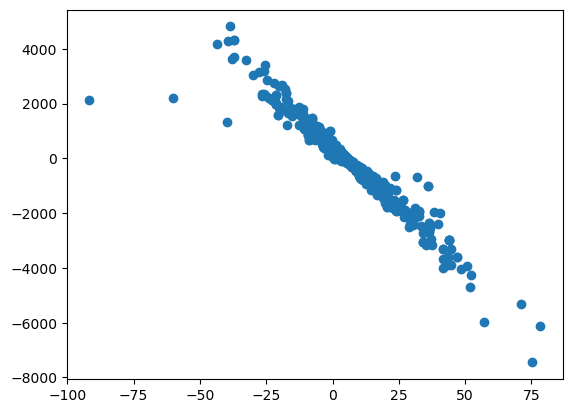

In [88]:
plt.scatter(a,b)


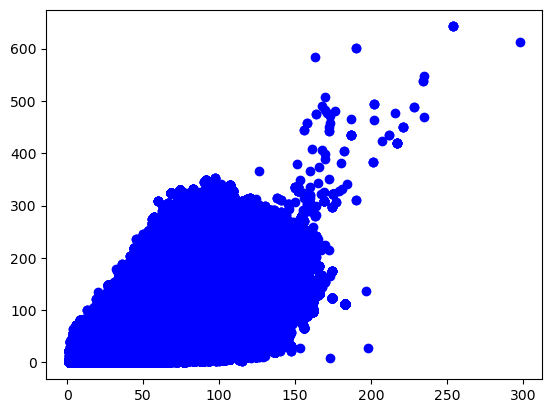

In [35]:
plt.scatter(np.concatenate(temp_x),np.concatenate(temp_y),color = 'blue')
#plt.scatter(np.concatenate(temp_x_approx),np.concatenate(temp_y_approx),color = 'red')

In [63]:
results = return_coef_sig(np.concatenate(temp_x),np.concatenate(temp_y),start = [250,0.03,5])
print(results[0],results[1],results[2])

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

array([1024,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [108]:
iss = np.array([100,1000,5000,10000,25000,50000,100000,250000,500000,750000,1000000])

starts = np.arange(10,100000,500)
result =[]

for i in range(len(iss)):
    result.append(return_coef_sig(np.concatenate(np.array(data[['age_2001','age_2011']].head(iss[i]),dtype='float')),np.concatenate( np.array(data[['vol_2001','vol_2011']].head(iss[i]),dtype='float')),start = [250,0.5,10]))
    print(result[i])

(146.08336510041548, 0.1151765508500569, 121.20803802988817)
(142.31033525210213, 0.05812632238835908, 7.868113047418507)
(164.43320304336353, 0.025954467856781353, 2.0)
(219.35255140246173, 0.018617775485039928, 2.0)
(202.3270765533637, 0.020205260136868054, 2.0)
(194.16756169064766, 0.020086125338422786, 2.0)
(191.70760578447423, 0.019632131917422566, 2.0)
(175.37888824609638, 0.023179885087904094, 2.0)
(184.6922477287229, 0.023106347351261724, 2.0)


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [ ]:
x = np.arange(0.01,200,0.5)
y=[]
for i in range(len(result)):
    y.append(volume_age(x,result[i][0],result[i][1],result[i][2]))
    plt.plot(x,y[i],label = iss[i])
    plt.legend()
plt.scatter(np.concatenate(temp_x),np.concatenate(temp_y),s=0.01)

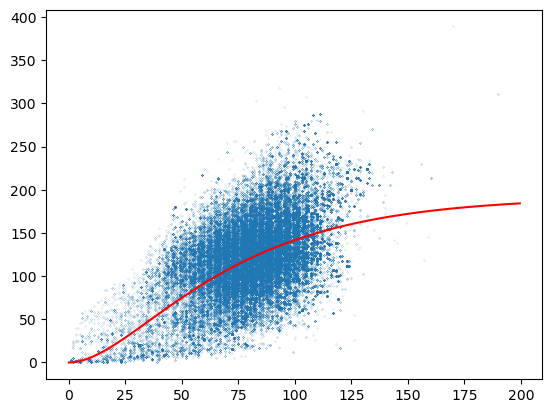

In [57]:
x = np.arange(0.01,200,0.5)
y = volume_age(x,result[0],results[1],results[2])
plt.plot(x,y,color='red')
plt.scatter(np.concatenate(temp_x),np.concatenate(temp_y),s=0.01)

In [37]:
plt.scatter(np.concatenate(temp_x),np.concatenate(temp_y))

Error in callback <function flush_figures at 0x0000017D9C8444A0> (for post_execute):


KeyboardInterrupt: 

In [55]:
for i in range (len(a)):
    plt.plot(x_fit[i],y_fit[i],label = [a,b])
    

IndexError: list index out of range

In [56]:
plt.plot(x_fit[1],y_fit[1])
plt.scatter(x[1],y[1])

IndexError: list index out of range

In [ ]:
def vol_forest(data):
    """
    """
    
    m=1
    
    #Firts condition is if there are no fires and no harvest
    if (data.isna()['number_fires'] == True) & (data.isna()['year_harvested'] == True):
        set_years = np.array([2001,2011,2015])
        set_vol = np.array(data[['vol_2001','vol_2011','vol_2015']])
        popt, pcov=curve_fit(volume_age,set_years, set_vol, method='dogbox',nan_policy='omit')

        y_vol_fit = volume_age(x_vol_fit,popt[0],popt[1])
        
        b = np.nanmean(set_ages-set_years*m)
        years = np.arange(2001,2021,1)
        if (str(popt[0]) != 'nan') | (str(popt[1]) != 'nan'):
            ages = (years*m+b).astype('int')
            harvested = np.zeros(20).astype('int')
            fires = np.zeros(20).astype('int')
            dict_data = {'ages'}
            return ages, fires, harvested
        
    #next condition is if it was not harvested, but fires occured
    elif data.isna()['number_fires'] == False:
        if data.isna()['year_harvested'] == True:
            disturbance_years= np.array(data['year'],dtype='float')
            disturbance_factors = np.array(data['area_intersect_perc'],dtype='float')
            
            disturbance_years, inv = np.unique(disturbance_years, return_inverse=True)      
            temp_df = np.zeros(len(disturbance_years), dtype=disturbance_factors.dtype)
            np.add.at(temp_df, inv, disturbance_factors)  
            disturbance_factors=temp_df
            
        else:
            
            disturbance_years= np.append(np.array(data['year'],dtype='float'),data['year_harvested'])
            disturbance_factors = np.append(np.array(data['area_intersect_perc'],dtype='float'),1.0)
            
            disturbance_years, inv = np.unique(disturbance_years, return_inverse=True)      
            temp_df = np.zeros(len(disturbance_years), dtype=disturbance_factors.dtype)
            np.add.at(temp_df, inv, disturbance_factors)  
            disturbance_factors=temp_df
            
            print(disturbance_years)
            print(disturbance_factors)

        fire_prev = 0
        year = 2001
        print("Starting new pixel at age {}".format(year))
        j=0
        for fire,area,i in zip(disturbance_years,disturbance_factors,range(len(disturbance_years))):
            print("abcdefg:",len(disturbance_years))
            print("year is currently {}".format(year))
            fire = float(fire)
            area = float(area)
            
            if area > 1:
                area = 1.0
            print("area of fire is:",area)
            print("year of distrubance is {} with {}% reductions".format(fire,area*100))
            print("we are on the {}th fire on this pixel out of {}".format(i+1,len(disturbance_years)))
            
            
            if fire < 2001:
                print("Years are out of bounds")
                j=0
                continue
            elif (fire >= 2001) & (fire < 2011):
                if (i == 0) | (j==0):
                    set_years=np.array([2001])
                    set_ages=np.array(data['vol_2001'])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    years = np.arange(year,fire,1)
                    ages = (years*m+b).astype('int')
                    year = fire
                    year_age = int((fire*m+b)*(1-area))
                    #print(year_age)
                    fire_prev = fire
                    j=1
                    continue
                else:
                    set_years=np.array([year])
                    set_ages=np.array([year_age])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    temp_years = np.arange(year,fire,1)
                    years = np.append(years,temp_years)
                    ages = np.append(ages,(temp_years*m+b).astype('int'))
                    year = fire
                    year_age = int((fire*m+b)*(1-area))
                    #print(year_age)
                    fire_prev = fire
                    j=1
                    continue
            
            elif (fire >= 2011) & (fire < 2015):
                if (i == 0) | (j==0):
                    set_years=np.array([2001,2011])
                    set_ages=np.array(data[['col_2001','vol_2011']])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    years = np.arange(year,fire,1)
                    ages = (years*m+b).astype('int')
                    year = fire
                    year_age = int((fire*m+b)*(1-area))
                    #print(year_age)
                    fire_prev = fire
                    j=1
                    continue
                else:
                    set_years=np.array([year])
                    set_ages=np.array([year_age])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    temp_years = np.arange(year,fire,1)
                    years = np.append(years,temp_years)
                    ages = np.append(ages,(temp_years*m+b).astype('int'))
                    year = fire
                    year_age = int((fire*m+b)*(1-area))
                    #print(year_age)
                    fire_prev = fire
                    j=1
                    continue
                
            elif (fire >= 2015) & (fire <= 2021):
                if (i == 0) | (j==0):
                    set_years=np.array([2001,2011,2015])
                    set_ages=np.array(data[['vol_2001','vol_2011','vol_2015']])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    years = np.arange(year,fire,1)
                    ages = (years*m+b).astype('int')
                    year = fire
                    year_age = int((fire*m+b)*(1-area))
                    #print(year_age)
                    fire_prev = fire
                    j=1
                    continue
                else:
                    set_years=np.array([year])
                    set_ages=np.array([year_age])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    temp_years = np.arange(year,fire,1)
                    years = np.append(years,temp_years)
                    ages = np.append(ages,(temp_years*m+b).astype('int'))
                    year = fire
                    year_age = int((fire*m+b)*(1-area))
                    print(year_age)
                    fire_prev = fire
                    j=1
                    continue
                

        if year < 2011:
            set_years=np.array([year,2011,2015])
            set_ages=np.append(year_age,np.array(data[['vol_2011','vol_2015']]))
            b = linear_reg_fixed_slope(set_years,set_ages,m)
            temp_years = np.arange(year,2022,1)
            years = np.append(years,temp_years)
            ages = np.append(ages,(temp_years*m+b).astype('int'))
        elif (year >= 2011) & (year < 2015):

            set_years=np.array([year,2015])
            set_ages=np.append(year_age,np.array(data[['vol_2015']]))
            b = linear_reg_fixed_slope(set_years,set_ages,m)
            temp_years = np.arange(year,2022,1)
            years = np.append(years,temp_years)
            ages = np.append(ages,(temp_years*m+b).astype('int'))
        elif (year >= 2015) & (year <= 2021):

            set_years=np.array([year])
            set_ages=np.array(year_age)
            b = linear_reg_fixed_slope(set_years,set_ages,m)
            temp_years = np.arange(year,2022,1)
            years = np.append(years,temp_years)
            ages = np.append(ages,(temp_years*m+b).astype('int'))
    return ages,years,disturbance_years#harvest
            
    
    #last condition is if it was harvested, and fires occured
    #elif (data.isna()['number_fires'] == False) & (data.isna()['year_harvested'] == False):
    

In [ ]:
ages,fires,harvested,years = [],[],[],[]
#data = ON_forest_and_fires[(ON_forest_and_fires.number_fires == 1) & (ON_forest_and_fires.year_harvested.isna() == False)].head(2)
data = ON_forest_and_fires.head(1)
print(data)
for i in range(len(data)):
    print("\n we are on data row",i)
    result = vol_forest(data.iloc[i,:])
    ages.append(result[0])
    years.append(result[1])
    fires.append(result[2])
#    #harvested.append(result[2])

In [ ]:
ytemp=np.array(data[['age_2001','age_2011','age_2019']])[0]
ytemp

In [ ]:
plt.plot(np.arange(2001,2009,1),ages[0])
plt.plot(np.array([2001,2011,2019]),ytemp)

In [ ]:
np.zeros(10).astype('int')

In [ ]:
[fire[0] for fire in ON_forest_and_fires[ON_forest_and_fires.number_fires == 1].head(1)['year']]

In [ ]:
col = 'age_2019'
temp = ON_joined_gdf_red[['geometry',col]]
plt.figure(figsize=[20,20])

ax = ON_boundary.plot()
temp.plot(ax=ax,column = col,markersize=0.00001,legend=True)
plt.title("Age of Ontario's Forest in 2019")
plt.xlabel('lon')
plt.ylabel('lat')
plt.savefig(path+col+".png",dpi=2400)

plt.show()

In [ ]:
col = 'year_harvested'
temp = ON_joined_gdf_red[['geometry',col]]
plt.figure(figsize=[20,20])

ax = ON_boundary.plot()
temp.head(10000).plot(ax=ax,column = col,marker = '.',markersize=0.000001,legend=True)
plt.title("Areas Harvested in Ontario by Year")
plt.xlabel('lon')
plt.ylabel('lat')
plt.savefig(path+col+".png",dpi=4800)

plt.show()